In [1]:
# Import required modules
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from wordcloud import WordCloud
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.special import rel_entr

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Use ggplot
matplotlib.style.use('ggplot')

features = ['target_material','target_thickness','pulse_width','energy','spot_size','intensity','power','cutoff_energy']
numeric_features = ['target_thickness', 'pulse_width', 'energy', 'spot_size', 'intensity', 'power', 'cutoff_energy']

# Load original dataset that was used to generate samples
df_original = pd.read_csv('../1_sample_preparation/source/d_clean_remove_small_samples.csv')
# Make sure required features are numeric
df_original[numeric_features] = df_original[numeric_features].astype(float)
df_original.reset_index(drop=True,inplace=True)

# Load synthetic data set
df_synthetic = pd.read_csv('../4_response_extraction/synthetic_data_rows.csv')
# Drop column
df_synthetic.drop(columns=['Unnamed: 0'],inplace=True)
# Make sure required features are numeric
df_synthetic[numeric_features] = df_synthetic[numeric_features].astype(float)
df_synthetic.reset_index(drop=True,inplace=True)

# Create a copy of the original DataFrame
df_synth_raw = df_synthetic.copy()

# Function to remove outliers for a specific feature
def remove_outliers(df, feature, lower_percentile, upper_percentile):
    Q1 = df[feature].quantile(lower_percentile)
    Q3 = df[feature].quantile(upper_percentile)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    return df[(df[feature] >= lower_bound) & (df[feature] <= upper_bound)]

# Remove outliers for all numeric features
for nf in numeric_features:
    df_synth_raw = remove_outliers(df_synth_raw, nf, 0.005, 0.995)

print(f"Original DataFrame length: {len(df_synthetic)}")
print(f"DataFrame length after removing outliers 'RAW' for Inf values: {len(df_synth_raw)} - Rows lost: {len(df_synthetic) - len(df_synth_raw)}")

print("\ndf_original head:",df_original.head())
print("\ndf_original info:",df_original.info())
print("\ndf_original unique prompt_method: NA")
print("\ndf_original unique prompt_short: NA")
print("\ndf_original unique sample_size: NA")
print("\ndf_original unique target_material:",df_original['target_material'].unique())
print("\ndf_original unique model: NA")

print("\ndf_synth_raw head:",df_synth_raw.head())
print("\ndf_synth_raw info:",df_synth_raw.info())
print("\ndf_synth_raw unique prompt_method:",df_synth_raw['prompt_method'].unique())
print("\ndf_synth_raw unique prompt_short:",df_synth_raw['prompt_short'].unique())
print("\ndf_synth_raw unique sample_size:",df_synth_raw['sample_size'].unique())
print("\ndf_synth_raw unique target_material:",df_synth_raw['target_material'].unique())
print("\ndf_synth_raw unique model:",df_synth_raw['model'].unique())

df_synthetic.head()


Original DataFrame length: 163300
DataFrame length after removing outliers 'RAW' for Inf values: 159860 - Rows lost: 3440

df_original head:   target_material  target_thickness  pulse_width  energy  spot_size  \
0         plastic             0.537         30.0   2.427        3.3   
1         plastic             0.293         30.0   2.395        3.3   
2         plastic             0.610         30.0   2.425        3.3   
3         plastic             0.509         30.0   2.344        3.3   
4         plastic             0.527         30.0   2.351        3.3   

      intensity         power  cutoff_energy  
0  6.561000e+20  8.091000e+13            3.3  
1  6.473000e+20  7.983000e+13            3.4  
2  6.554000e+20  8.083000e+13            3.4  
3  6.335000e+20  7.813000e+13            3.4  
4  6.356000e+20  7.838000e+13            3.4  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067 entries, 0 to 1066
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype

model     prompt_method prompt_short sample_size  \
0  claude-3-5-sonnet-20240620  chain_of_thought          cot   rs_size_5   
1  claude-3-5-sonnet-20240620  chain_of_thought          cot   rs_size_5   
2  claude-3-5-sonnet-20240620  chain_of_thought          cot   rs_size_5   
3  claude-3-5-sonnet-20240620  chain_of_thought          cot   rs_size_5   
4  claude-3-5-sonnet-20240620  chain_of_thought          cot   rs_size_5   

  target_material  target_thickness  pulse_width  energy  spot_size  \
0         plastic             0.301         35.0    1.87        3.3   
1            gold             0.685        180.0    3.25        3.3   
2       aluminium             0.952         42.0    2.39        3.3   
3   polypropylene             1.230        320.0   15.60        4.1   
4         plastic             0.488         30.0    2.33        3.3   

      intensity         power  cutoff_energy  
0  5.120000e+20  5.340000e+13            4.2  
1  7.210000e+20  1.810000e+13            6.8  
2  6.380000e+20  5.690000e+13            5.1  
3  1.450000e+21  4.880000e+13           18.3  
4  6.300000e+20  7.770000e+13            4.5

In [2]:
df_original.head()

target_material  target_thickness  pulse_width  energy  spot_size  \
0         plastic             0.537         30.0   2.427        3.3   
1         plastic             0.293         30.0   2.395        3.3   
2         plastic             0.610         30.0   2.425        3.3   
3         plastic             0.509         30.0   2.344        3.3   
4         plastic             0.527         30.0   2.351        3.3   

      intensity         power  cutoff_energy  
0  6.561000e+20  8.091000e+13            3.3  
1  6.473000e+20  7.983000e+13            3.4  
2  6.554000e+20  8.083000e+13            3.4  
3  6.335000e+20  7.813000e+13            3.4  
4  6.356000e+20  7.838000e+13            3.4

Unique Materials: 447


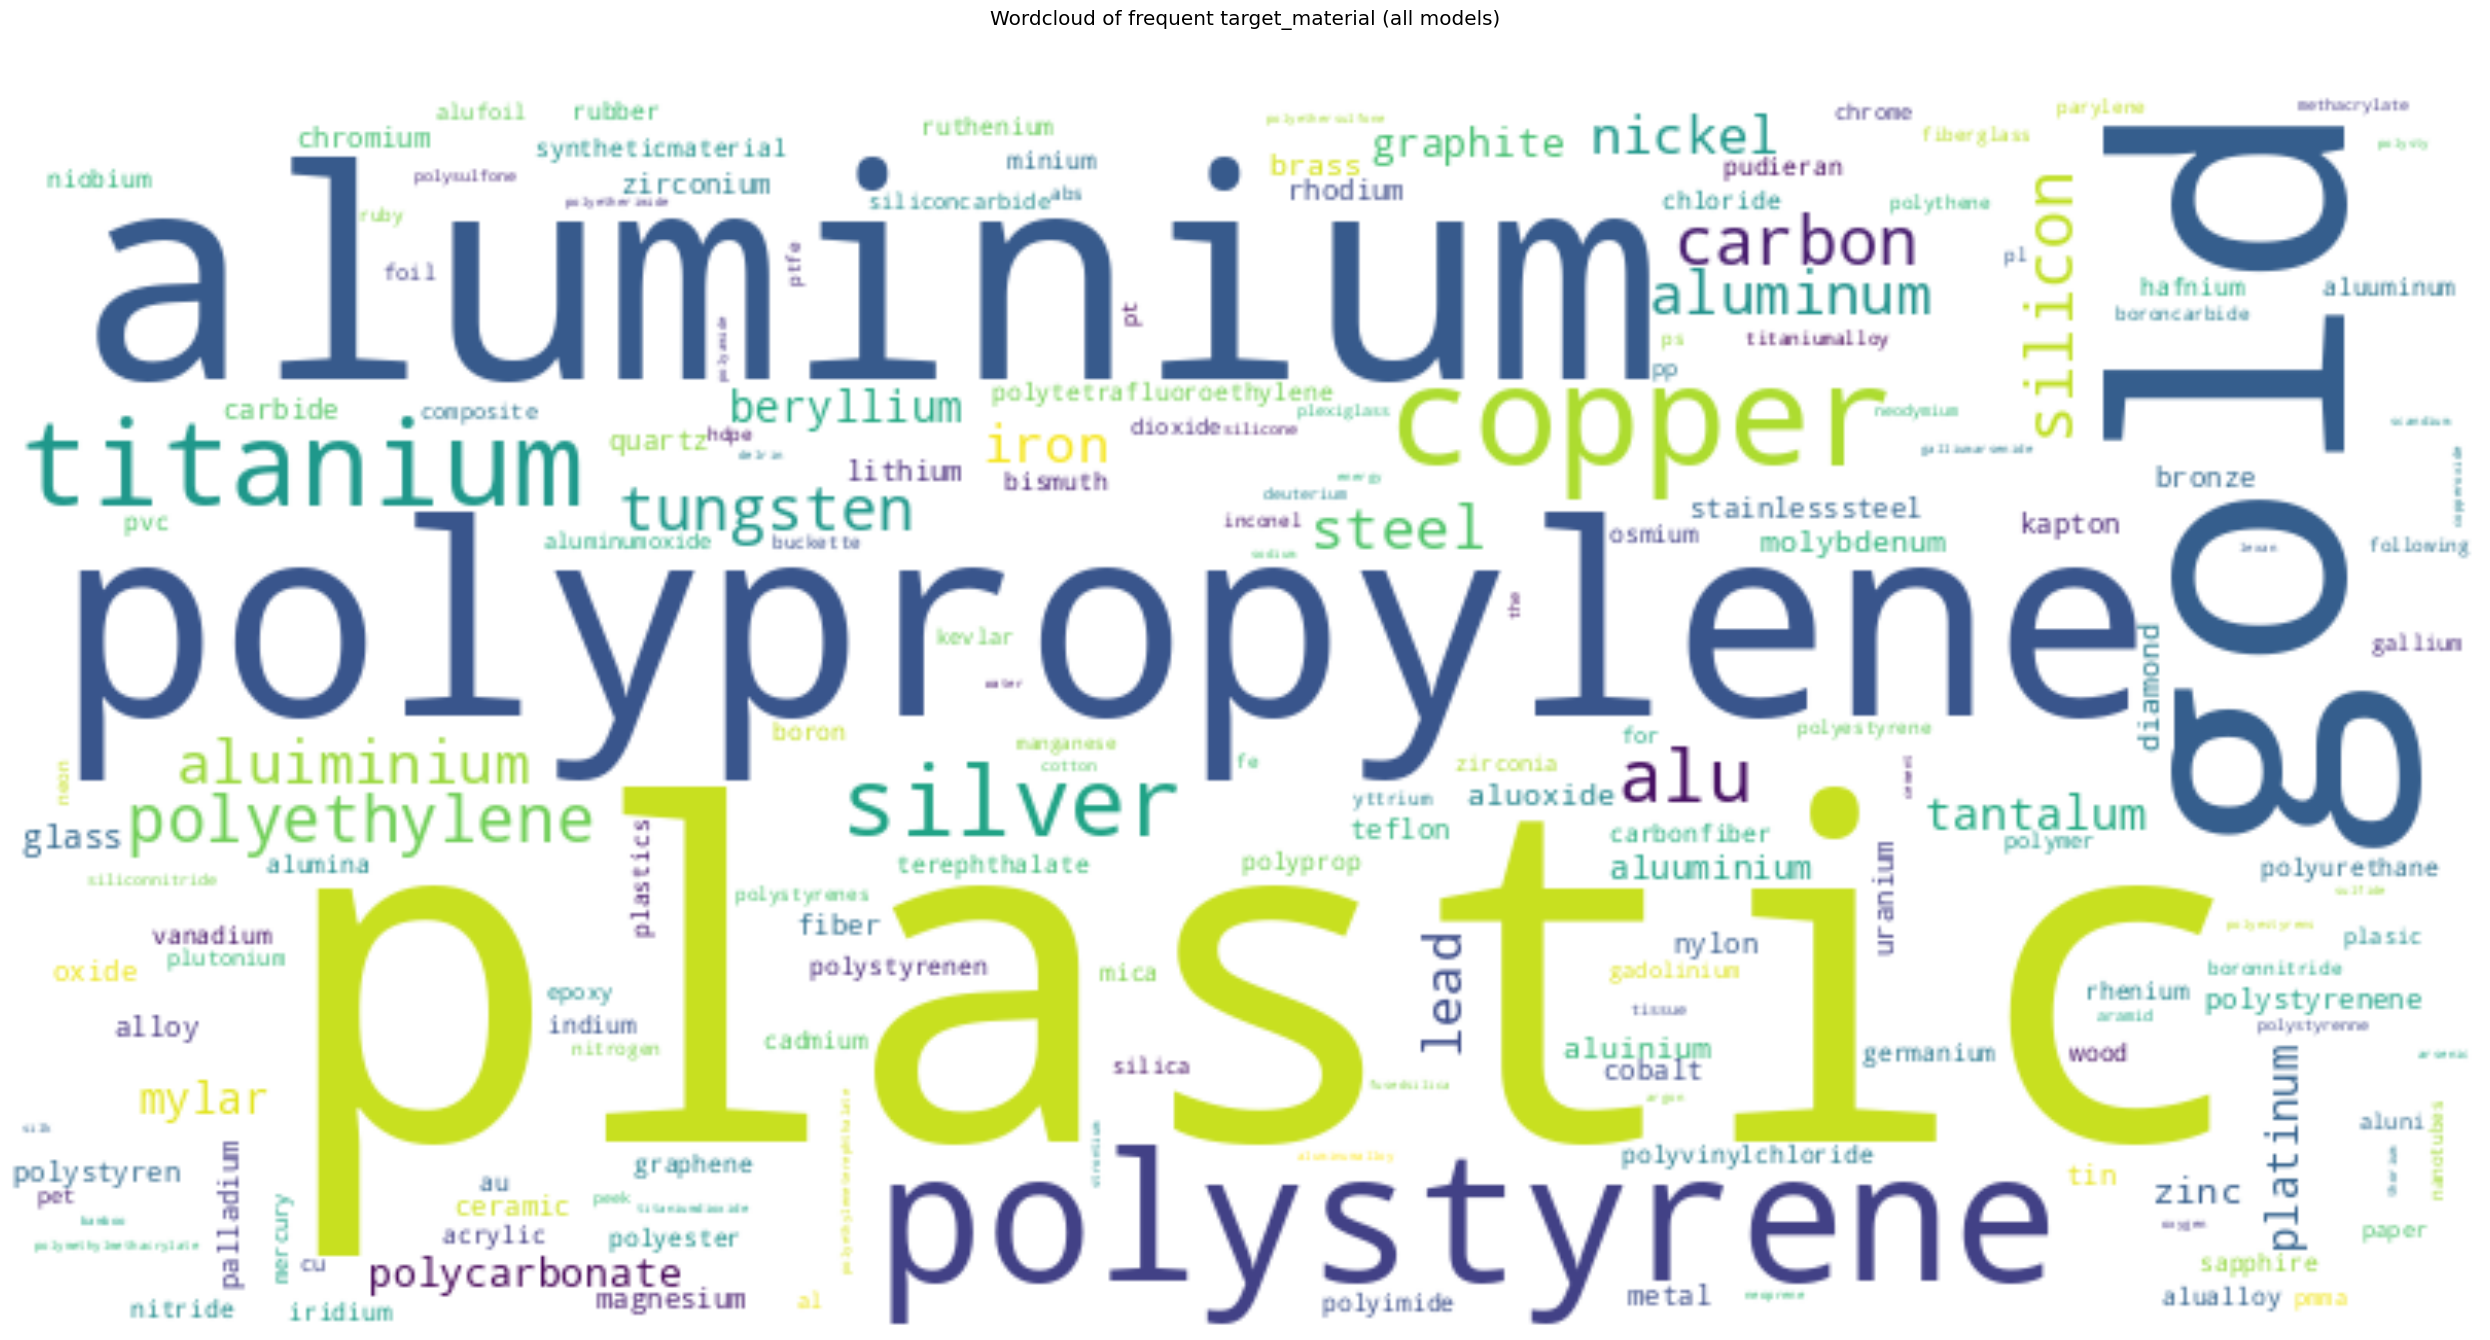

In [4]:
# Count the occurrences of each 'target_material'
material_counts = df_synth_raw['target_material'].value_counts()

print('Unique Materials:',len(df_synth_raw['target_material'].unique()))

# Create a WordCloud object
wordcloud = WordCloud(width = 800, height = 400, background_color ='white')

# Generate a word cloud using the frequencies
wordcloud.generate_from_frequencies(material_counts.to_dict())

# Display the WordCloud image:
plt.figure(figsize=(25, 15))
plt.title('Wordcloud of frequent target_material (all models)',y=1.05)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axis labels

plt.tight_layout()

plt.savefig('./images/word_cloud_target_material.jpg',dpi=800)
plt.show()

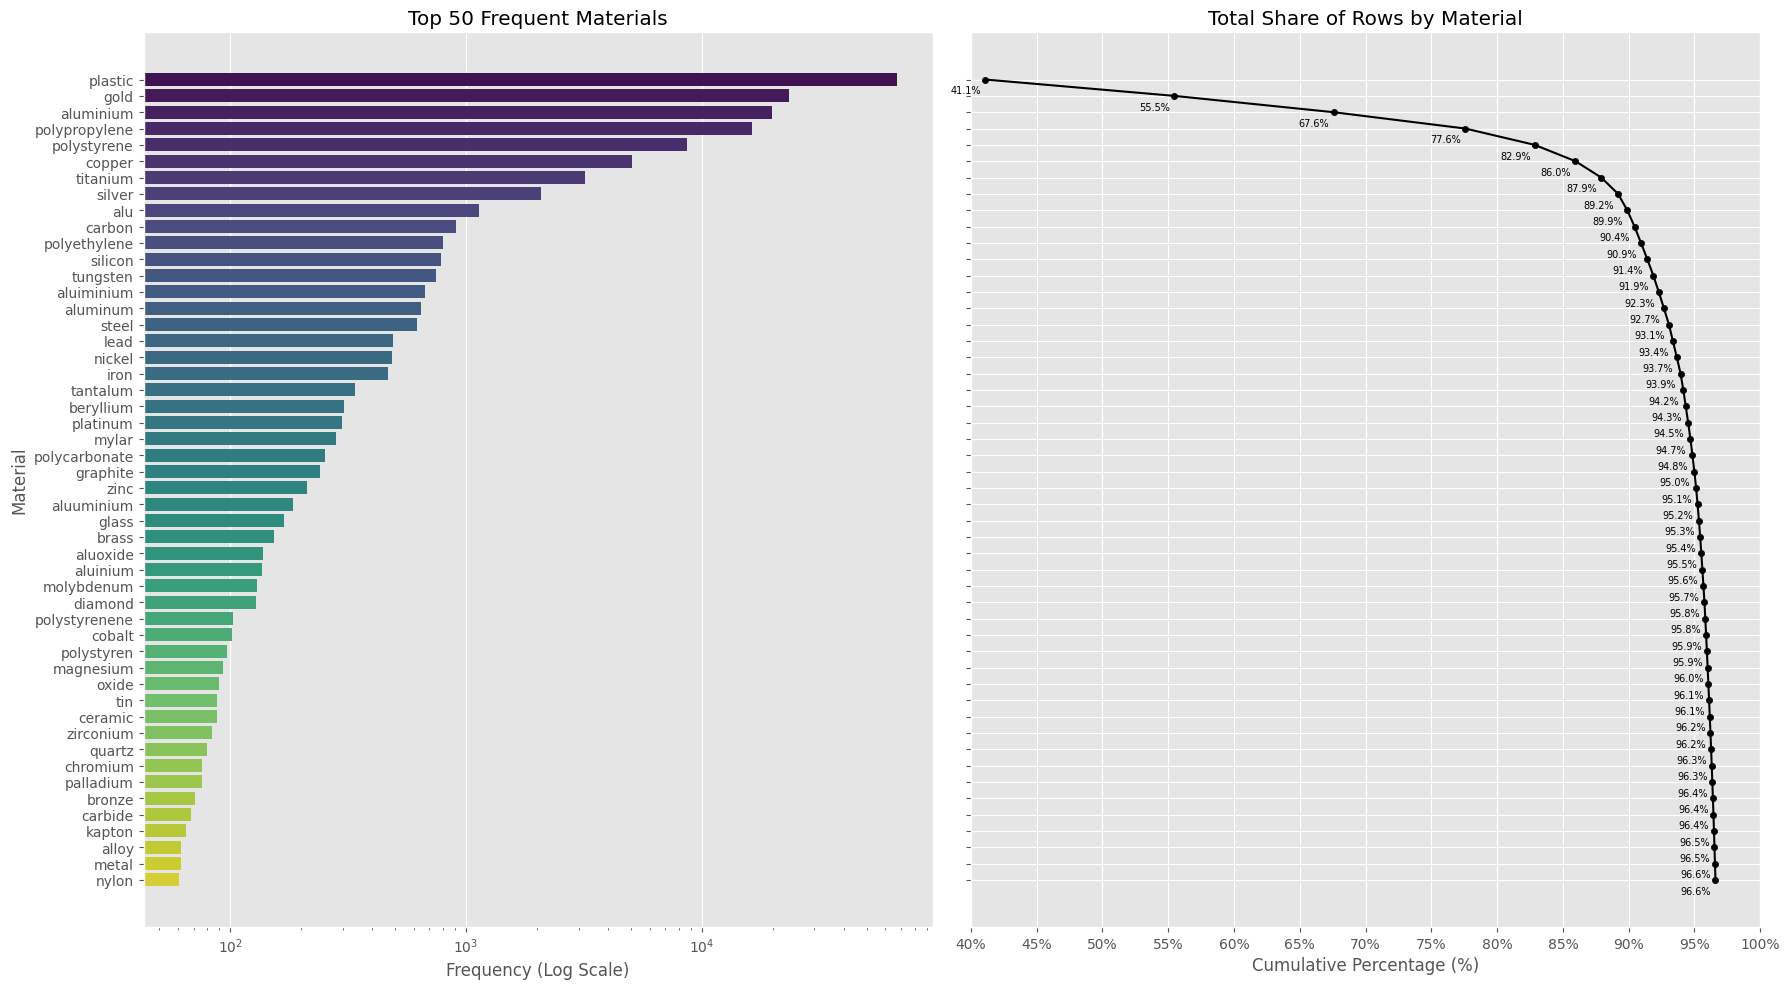

In [6]:
# Count the occurrences of each 'target_material'
material_counts = df_synth_raw['target_material'].value_counts()

# Assuming 'material_counts' holds the value counts of 'target_material' from your DataFrame
top_25_materials = material_counts.head(50)  # Get the top 50 materials for better illustration

# Create a DataFrame from the top 25 materials for easier plotting
top_25_df = pd.DataFrame(top_25_materials).reset_index()
top_25_df.columns = ['target_material', 'count']

# Calculate cumulative percentage
total_rows = df_synthetic.shape[0]  # Total number of rows in the original DataFrame
top_25_df['cumulative_percent'] = top_25_df['count'].cumsum() / total_rows * 100

# Initialize the matplotlib figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 10), sharey=True)  # Share y-axis across subplots

# Left subplot for frequency
sns.barplot(x='count', y='target_material', data=top_25_df, ax=axes[0], hue='target_material',palette='viridis')
axes[0].set_xscale('log')
axes[0].set_xlabel('Frequency (Log Scale)')
axes[0].set_ylabel('Material')
axes[0].set_title('Top 50 Frequent Materials')

# Right subplot for cumulative percentage
sns.lineplot(x='cumulative_percent', y='target_material', data=top_25_df, ax=axes[1],color='black')
axes[1].set_xlabel('Cumulative Percentage (%)')
axes[1].set_title('Total Share of Rows by Material')

# Set x-axis to have a tick every 5 percent
axes[1].xaxis.set_major_locator(ticker.MultipleLocator(5))

# Optionally, you can format the ticks to show them as percentages
axes[1].xaxis.set_major_formatter(ticker.PercentFormatter(xmax=100))

# If you want to limit the x-axis to show up to 100% only
axes[1].set_xlim(40, 100)

# Annotate each point on the line plot
for index, row in top_25_df.iterrows():
    axes[1].annotate(f"{row['cumulative_percent']:.1f}%", 
                     (row['cumulative_percent'], row['target_material']), 
                     textcoords="offset points", 
                     xytext=(-14,-10), 
                     ha='center', 
                     color='black', 
                     size=7,
    )
# Plotting the points as black dots
axes[1].scatter(top_25_df['cumulative_percent'], top_25_df['target_material'], color='black', s=20)  # s is the size of the dot

# Improve layout
plt.tight_layout()

# Save the figure
plt.savefig('./images/top_50_materials_comparison.jpg', dpi=300)
# Display the plot
plt.show()

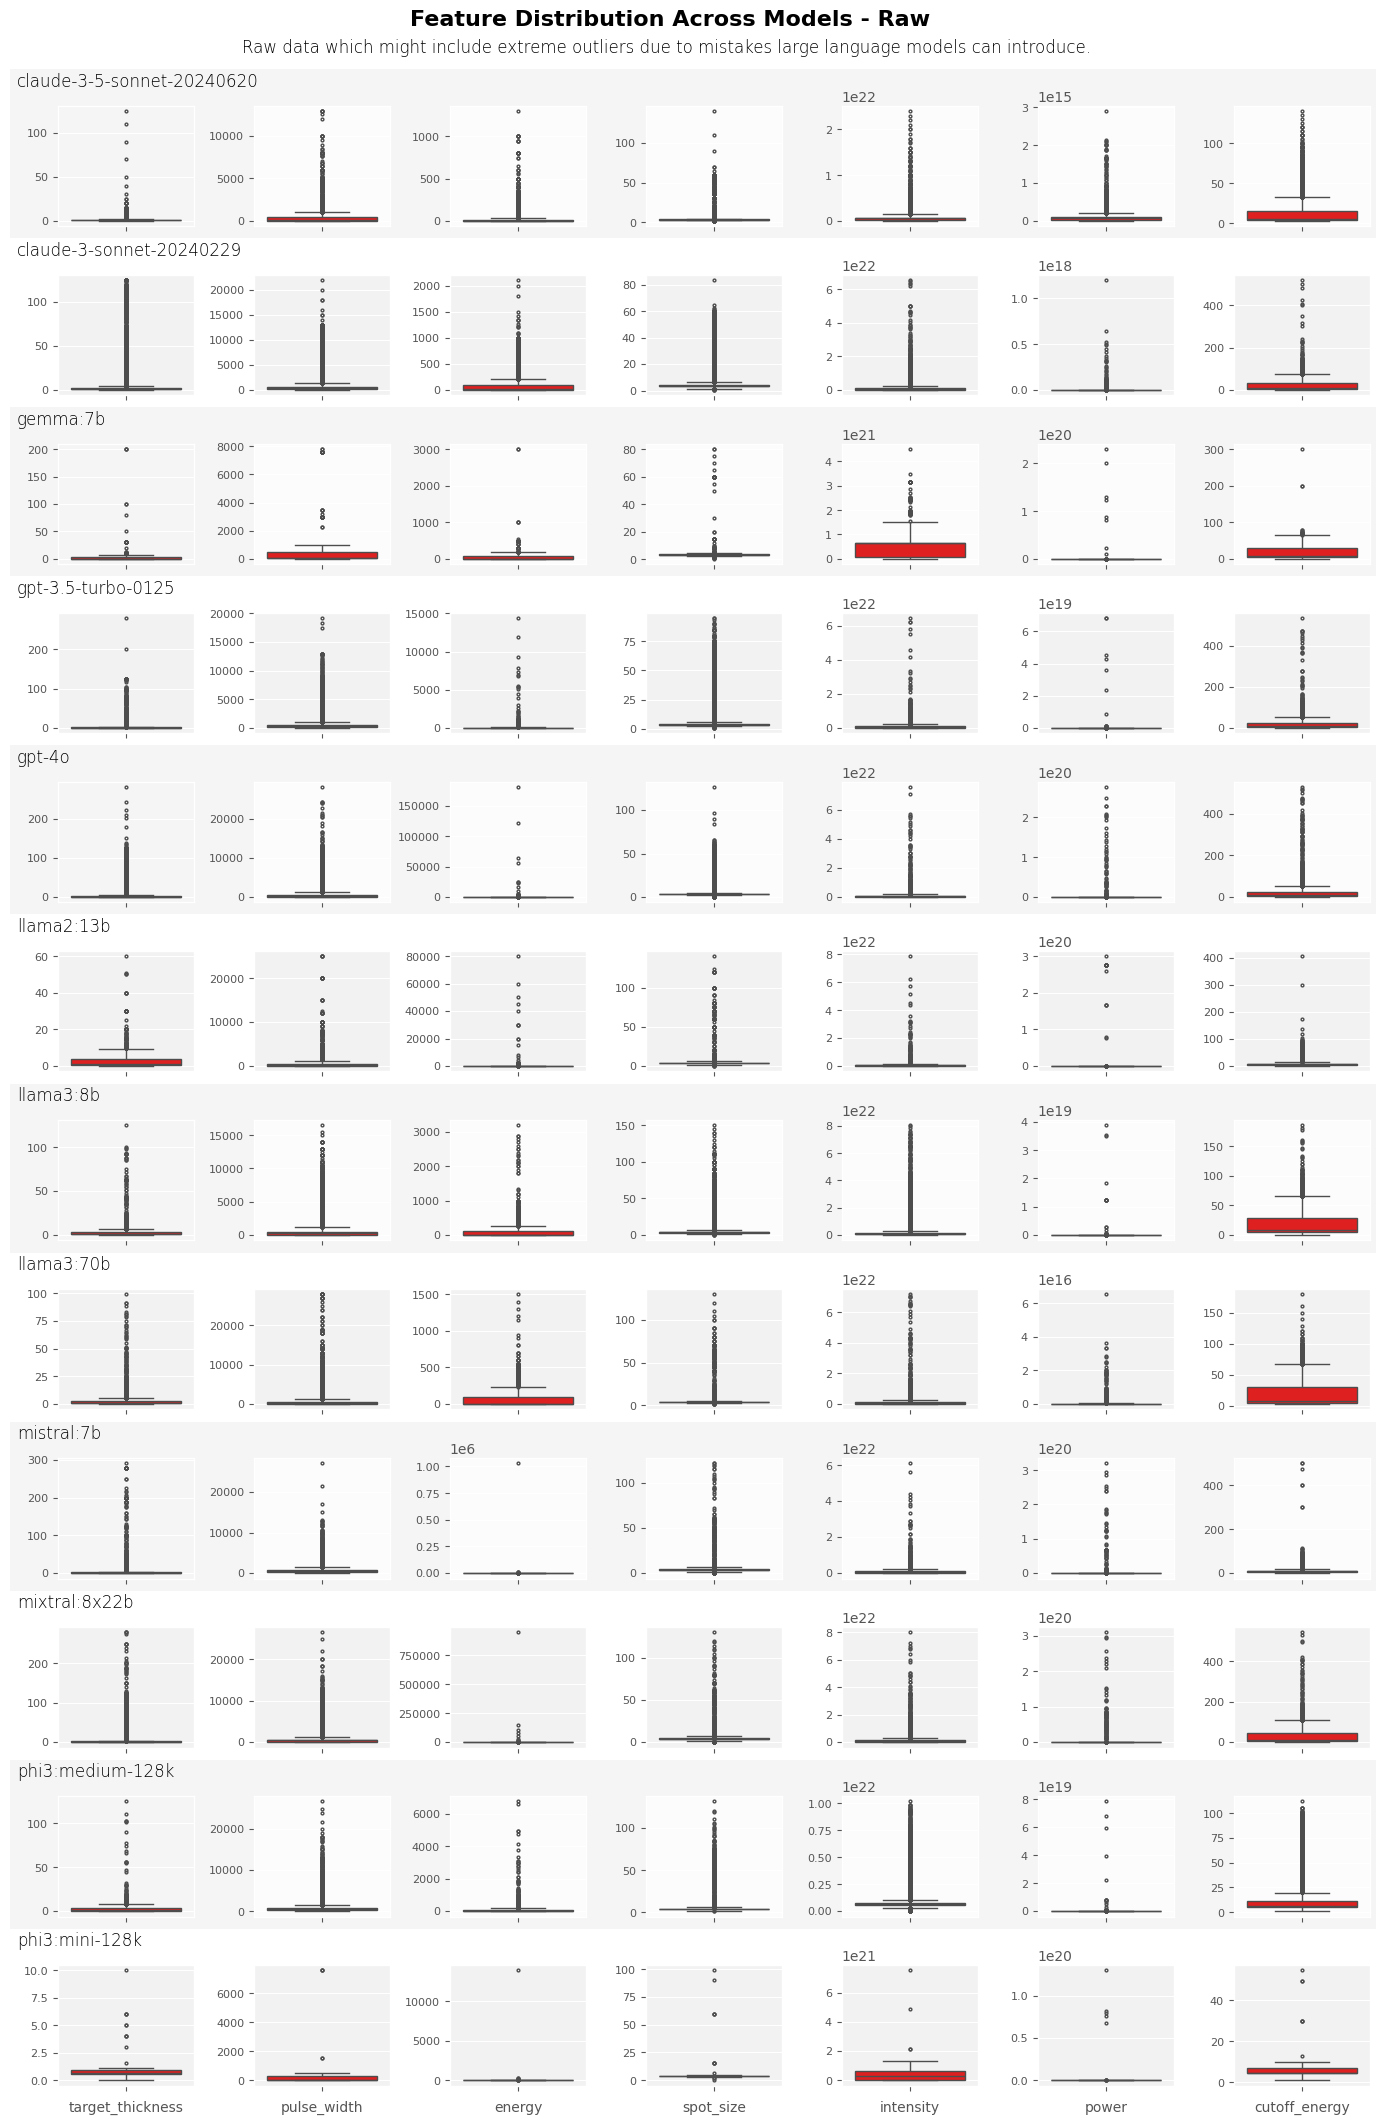

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

num_models = len(df_synth_raw['model'].unique())
num_features = len(numeric_features)

# Calculate the optimal figure size
fig_width = min(20, 2.5 * num_features)  # Cap the width at 20 inches
fig_height = min(30, 2 * num_models)  # Cap the height at 30 inches

# Initialize the matplotlib figure with subplots
fig, axes = plt.subplots(num_models, num_features, figsize=(fig_width, fig_height))

# If there's only one model, wrap axes in a list to make it 2D
if num_models == 1:
    axes = np.array([axes])

for i, model_name in enumerate(df_synth_raw['model'].unique()):
    # Filter the DataFrame for the specific model
    model_df = df_synth_raw[df_synth_raw['model'] == model_name].copy()

    for j, feature in enumerate(numeric_features):
        # Create a boxplot for the numeric features of this specific model
        sns.boxplot(data=model_df, y=feature, ax=axes[i, j], orient='v', color='red', fliersize=2)
        
        # Set the xlabel on each subplot
        axes[i, j].set_xlabel('')
        
        # Only set the feature name for the bottom row
        if i == num_models - 1:
            axes[i, j].set_xlabel(feature, fontsize=10, fontweight='normal')
        
        # Remove y-label for all subplots
        axes[i, j].set_ylabel('')

        # Rotate x-axis labels for better readability
        axes[i, j].tick_params(axis='x', rotation=45, labelsize=8)
        axes[i, j].tick_params(axis='y', labelsize=8)

        if i % 2 != 0:
            axes[i, j].patch.set_facecolor((0.95, 0.95, 0.95))  # Light grey color
        else:
            axes[i, j].patch.set_facecolor((0.99, 0.99, 0.99))  # Light grey color

    # Add model name to the top left corner of each row
    axes[i, 0].text(-0.3, 1.125, model_name, transform=axes[i, 0].transAxes, 
                    fontsize=12, fontweight='light', ha='left', va='bottom')

    # Extend the shaded background to include the model name area for shaded rows
    if i % 2 == 0:
        axes[i, 0].add_patch(plt.Rectangle((-0.35, -0.1), 10, 1.4, 
                                           fill=True, transform=axes[i, 0].transAxes, 
                                           facecolor=(0.96, 0.96, 0.96), clip_on=False, zorder=0))

# Adjust the layout and spacing
plt.tight_layout()
plt.subplots_adjust(hspace=0.4, wspace=0.435, top=0.935, left=0.15)

# Add a main title
fig.suptitle('Feature Distribution Across Models - Raw', fontsize=16, fontweight='bold', y=0.975)
fig.text(s='Raw data which might include extreme outliers due to mistakes large language models can introduce.',y=0.957,x=0.255,fontsize=12, fontweight='light')

# Save the figure with high resolution
plt.savefig('./images/boxplot_outliers_models_raw.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

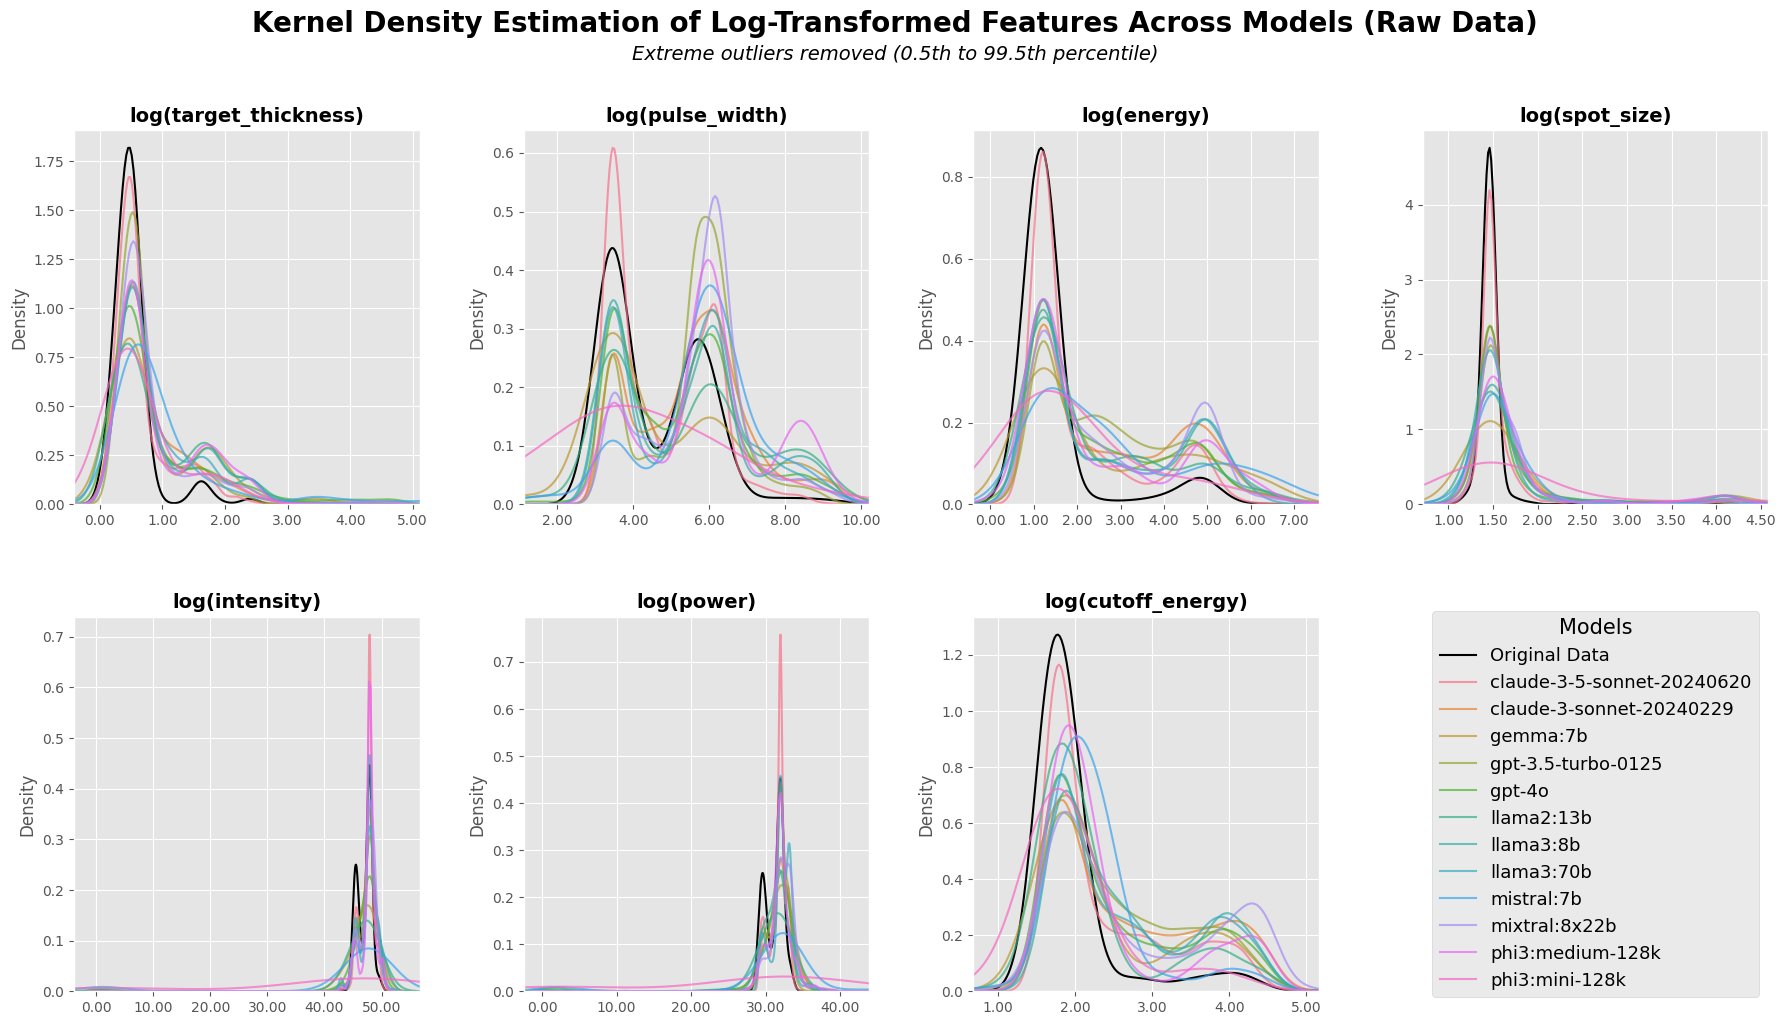

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

def create_kde_plot(data, title, subtitle):
    fig, axes = plt.subplots(2, 4, figsize=(18, 10))
    axes = axes.flatten()

    synthetic_models = [model for model in data['model'].unique() if model != 'original data']
    color_palette = sns.color_palette("husl", n_colors=len(synthetic_models))

    for i, feature in enumerate(numeric_features):
        ax = axes[i]
        
        # Determine the x-axis range
        x_min = max(0, data[feature].quantile(0.0025))  # Use 1st percentile, but never go below 0
        x_max = data[feature].quantile(0.9975)  # Use 99th percentile to exclude extreme outliers
        x_range = x_max - x_min
        x_padding = x_range * 0.1  # Add 10% padding on each side
        
        original_data = data[data['model'] == 'original data']
        if not original_data.empty:
            sns.kdeplot(data=original_data, x=feature, ax=ax, color='black', alpha=1, label='Original Data', bw_adjust=1.5)
        
        for j, model in enumerate(synthetic_models):
            model_data = data[data['model'] == model]

            if model_data[feature].nunique() == 1:
                print(f"  Skipping plot for {model} - all values are the same")
                continue
            
            sns.kdeplot(data=model_data, x=feature, ax=ax, color=color_palette[j], alpha=0.7, label=model, bw_adjust=1.5)
        
        ax.set_title(f"log({feature})", fontsize=14, fontweight='bold')
        ax.set_xlabel('')
        ax.set_ylabel('Density', fontsize=12)
        ax.tick_params(axis='both', which='major', labelsize=10)
        ax.set_xlim(x_min - x_padding, x_max + x_padding)
        ax.legend().remove()
        
        # Remove scientific notation from x-axis
        ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))

    handles, labels = axes[0].get_legend_handles_labels()
    axes[-1].legend(handles, labels, title='Models', title_fontsize='15', fontsize='13', loc='center', bbox_to_anchor=(0.5, 0.5), bbox_transform=axes[-1].transAxes)
    axes[-1].axis('off')

    plt.tight_layout()
    fig.suptitle(title, fontsize=20, fontweight='bold', y=1.02)
    fig.text(0.5, 0.97, subtitle, ha='center', fontsize=14, fontstyle='italic')
    plt.subplots_adjust(top=0.9, hspace=0.3, wspace=0.3)

    return fig

df_original_log = df_original.copy()
df_synth_raw_log = df_synth_raw.copy()

# Add 'model' column to df_original and select only numeric features
df_original_log['model'] = 'original data'
df_original_log = df_original_log[['model'] + numeric_features]

# Log transform numeric features
for feature in numeric_features:
    df_original_log[feature]            = np.log1p(df_original_log[feature])
    df_synth_raw_log[feature] = np.log1p(df_synth_raw[feature])

# Add original data to cleaned dataframes
df_clean_raw_with_original = pd.concat([df_synth_raw_log, df_original_log], ignore_index=True)

# Create and save plots for raw data (without inf/NaN values), IQR-cleaned data, and IPR-cleaned data
raw_plot = create_kde_plot(df_clean_raw_with_original, 'Kernel Density Estimation of Log-Transformed Features Across Models (Raw Data)', 'Extreme outliers removed (0.5th to 99.5th percentile)')
raw_plot.savefig('./images/kde_features_across_models_raw_log.png', dpi=300, bbox_inches='tight')

plt.show()

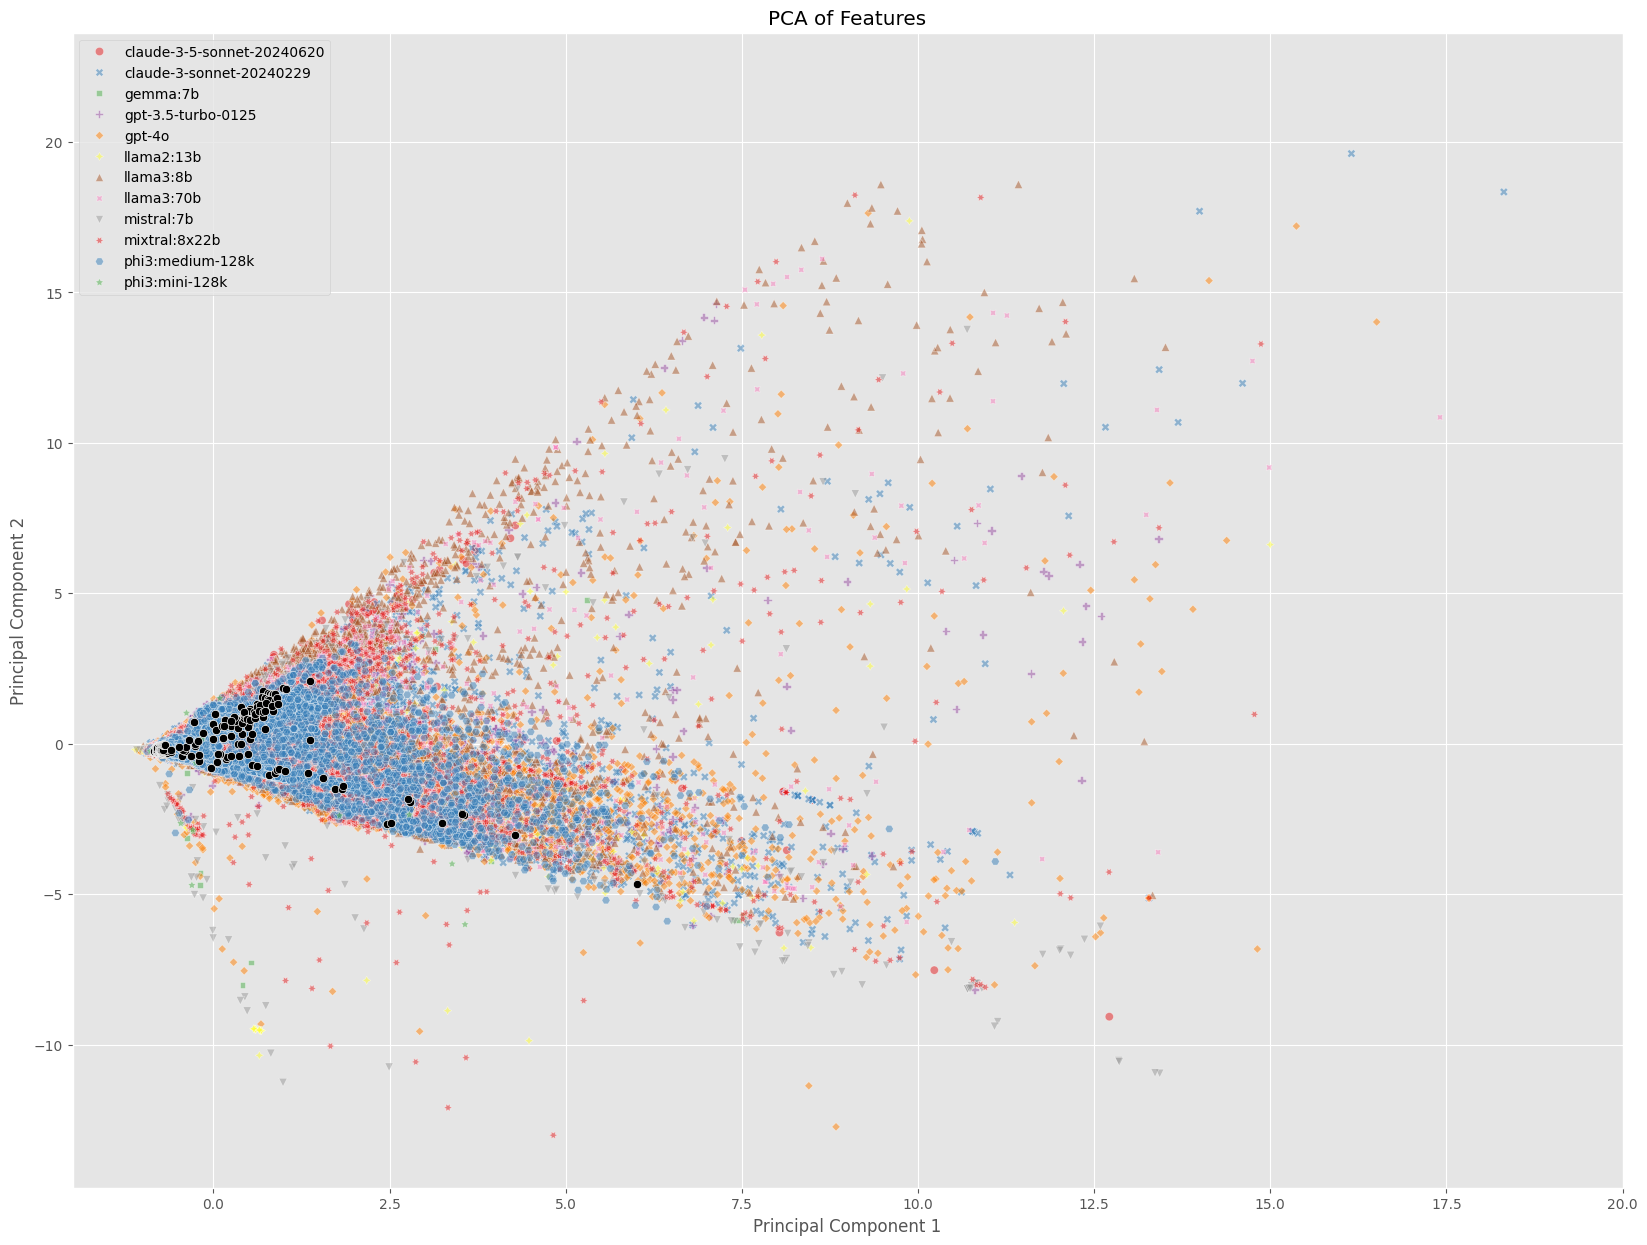

In [7]:
# Assuming df_remove_outliers and df_original are already loaded

# Selecting numerical features for PCA
features = ['target_thickness', 'pulse_width', 'energy', 'spot_size', 'intensity', 'power', 'cutoff_energy']

# Ensure df_original has all columns from df_remove_outliers
missing_cols = set(df_synth_raw.columns) - set(df_original.columns)
for col in missing_cols:
    df_original[col] = np.nan

# Add 'source' column
df_synth_raw['source'] = 'synthetic'
df_original['source'] = 'original'

# Drop NaN values only from the synthetic data
df_synth_raw_copy = df_synth_raw.copy()
df_synth_raw_copy.replace([np.inf, -np.inf], np.nan, inplace=True)
df_synth_raw_copy.dropna(subset=features, inplace=True)

# Combine the cleaned synthetic DataFrame with the original DataFrame
combined_df = pd.concat([df_synth_raw_copy, df_original], ignore_index=True)

# Now proceed with PCA on the combined DataFrame
X = combined_df[features].copy()  # Create a copy to avoid SettingWithCopyWarning

# Standardizing the features
X_scaled = StandardScaler().fit_transform(X)

# Proceed with PCA
pca = PCA(n_components=2)  # Example: reducing to 2 principal components
principal_components = pca.fit_transform(X_scaled)

# Create a DataFrame with the principal components
pca_df = pd.DataFrame(data=principal_components, columns=['Principal Component 1', 'Principal Component 2'])

# Adding the source and model information back to the PCA DataFrame
pca_df = pd.concat([pca_df, combined_df.reset_index(drop=True)[['source', 'model']]], axis=1)

# Handle NaNs in the 'model' column for original data
pca_df['model'].fillna('original', inplace=True)

# Separate the synthetic and original data points
synthetic_points = pca_df[pca_df['source'] == 'synthetic']
original_points = pca_df[pca_df['source'] == 'original']

# Plotting the PCA result
plt.figure(figsize=(20, 15))
plt.xlim([-2,20])

# Plot synthetic points first
sns.scatterplot(data=synthetic_points, x='Principal Component 1', y='Principal Component 2', hue='model', style='model', palette='Set1', alpha=0.5, legend=True)

# Plot original points on top in black
sns.scatterplot(data=original_points, x='Principal Component 1', y='Principal Component 2', color='black')

plt.title('PCA of Features')
plt.savefig('./images/pca_all_models_single_plot.jpg')
plt.show()


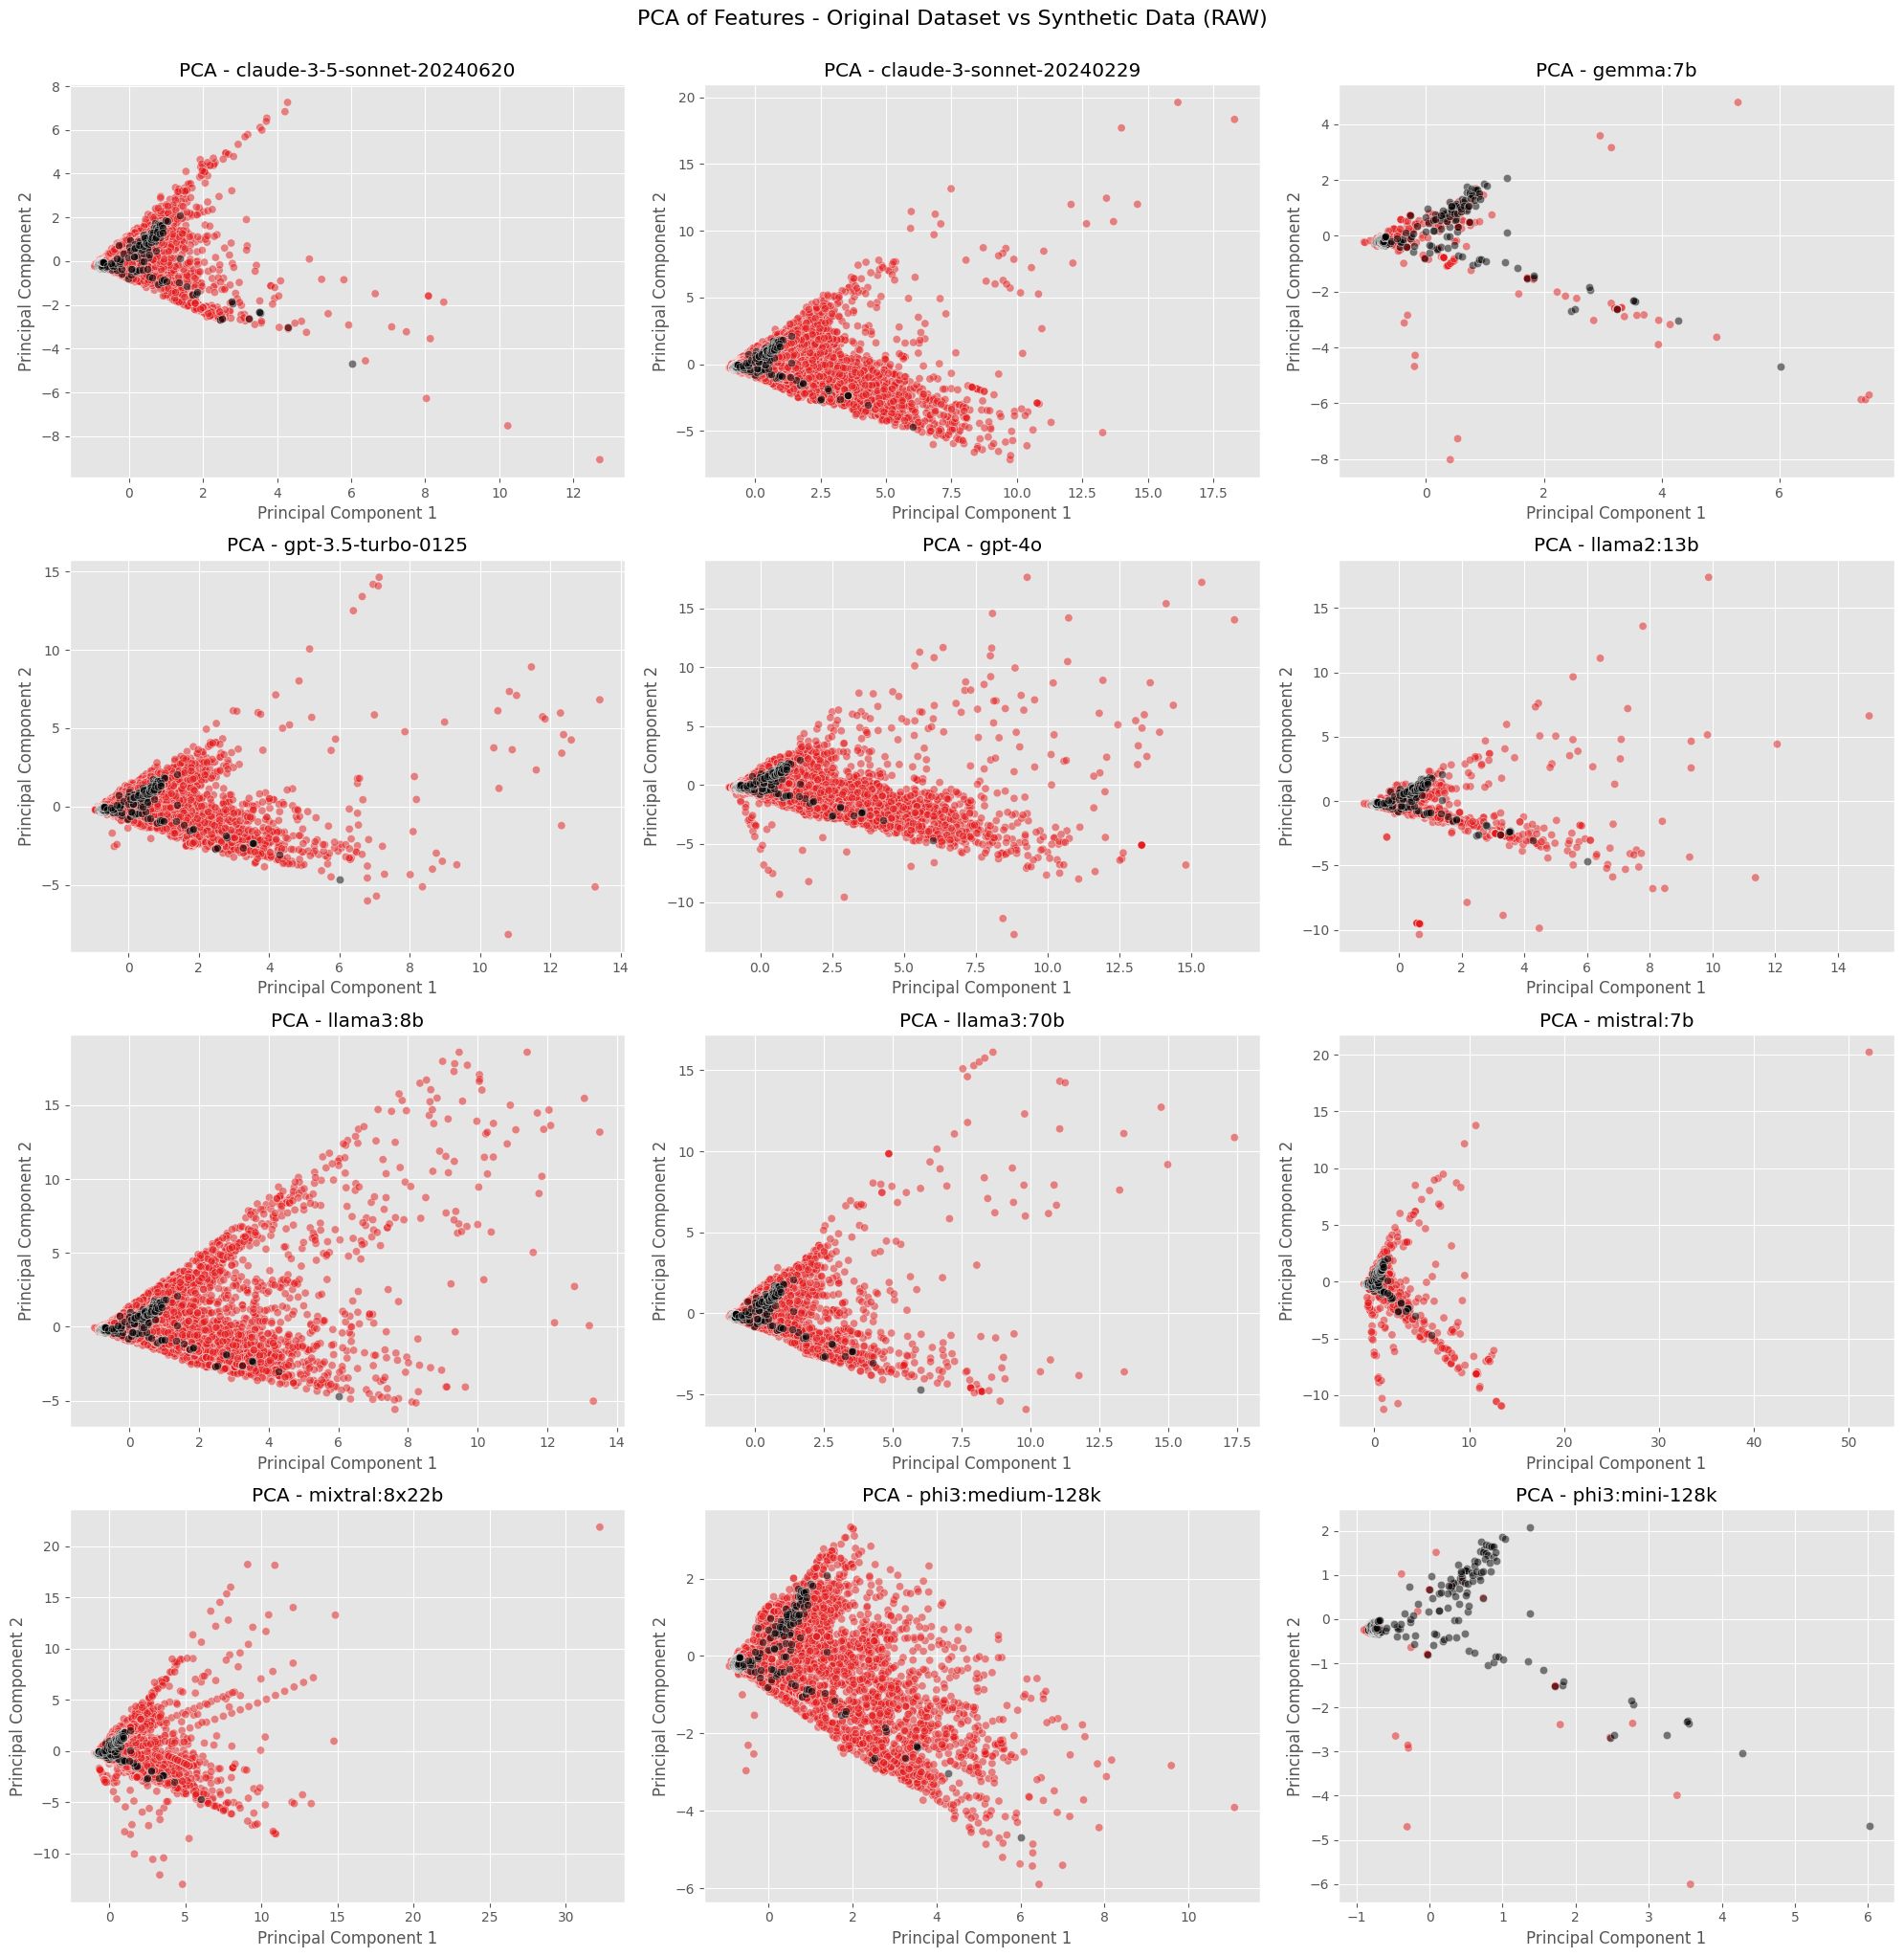

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def create_scatter_pca(synthetic, original,synthetic_name):
    # Selecting numerical features for PCA
    features = ['target_thickness', 'pulse_width', 'energy', 'spot_size', 'intensity', 'power', 'cutoff_energy']

    # Ensure original has all columns from synthetic
    missing_cols = set(synthetic.columns) - set(original.columns)
    for col in missing_cols:
        original[col] = np.nan

    # Add 'source' column
    synthetic['source'] = 'synthetic'
    original['source'] = 'original'

    # Drop NaN values only from the synthetic data
    df_synth_raw_copy = synthetic.copy()
    df_synth_raw_copy.replace([np.inf, -np.inf], np.nan, inplace=True)
    df_synth_raw_copy.dropna(subset=features, inplace=True)

    # Combine the cleaned synthetic DataFrame with the original DataFrame
    combined_df = pd.concat([df_synth_raw_copy, original], ignore_index=True)

    # Now proceed with PCA on the combined DataFrame
    X = combined_df[features].copy()

    # Standardizing the features
    X_scaled = StandardScaler().fit_transform(X)

    # Proceed with PCA
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(X_scaled)

    # Create a DataFrame with the principal components
    pca_df = pd.DataFrame(data=principal_components, columns=['Principal Component 1', 'Principal Component 2'])

    # Adding the source and model information back to the PCA DataFrame
    pca_df = pd.concat([pca_df, combined_df.reset_index(drop=True)[['source', 'model']]], axis=1)

    # Handle NaNs in the 'model' column for original data
    pca_df['model'].fillna('original', inplace=True)

    # Separate the synthetic and original data points
    synthetic_points = pca_df[pca_df['source'] == 'synthetic']
    original_points = pca_df[pca_df['source'] == 'original']

    # Get unique models
    unique_models = combined_df['model'].unique()
    unique_models = [model for model in unique_models if isinstance(model, str)]

    # Calculate number of rows and columns for subplots
    n_models = len(unique_models)
    n_cols = 3
    n_rows = (n_models + n_cols - 1) // n_cols

    # Create subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
    axes = axes.flatten()  # Flatten the 2D array of axes to iterate easily

    for i, model_name in enumerate(unique_models):
        ax = axes[i]
        # Plot synthetic points first
        sns.scatterplot(data=synthetic_points[synthetic_points['model'] == model_name], 
                        x='Principal Component 1', y='Principal Component 2', 
                        hue='model', style='model', palette='Set1', alpha=0.5, 
                        legend=False, ax=ax)

        # Plot original points on top in black
        sns.scatterplot(data=original_points, x='Principal Component 1', y='Principal Component 2', 
                        color='black', alpha=0.5, ax=ax)

        ax.set_title(f'PCA - {model_name}')
        ax.set_xlabel('Principal Component 1')
        ax.set_ylabel('Principal Component 2')

    # Remove any unused subplots
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    # Adjust layout
    plt.tight_layout()

    # Add a main title
    fig.suptitle(f'PCA of Features - Original Dataset vs Synthetic Data ({synthetic_name.upper()})', 
                 fontsize=16, y=1.02)

    # Save the figure
    plt.savefig(f'./images/pca_all_models_orig_vs_synth_{synthetic_name}.jpg', dpi=300, bbox_inches='tight')
    plt.show()

# Call the function
create_scatter_pca(df_synth_raw, df_original,'raw')

In [9]:
# Assuming df_remove_outliers and df_original are already loaded
### UNIVARIATE KL-DISTANCES FOR FEATURES

# Selecting numerical features for KL Divergence
features = ['target_thickness', 'pulse_width', 'energy', 'spot_size', 'intensity', 'power', 'cutoff_energy']

# Ensure df_original has all columns from df_remove_outliers
missing_cols = set(df_synth_raw.columns) - set(df_original.columns)
for col in missing_cols:
    df_original[col] = np.nan

# Add 'source' column
df_synth_raw['source'] = 'synthetic'
df_original['source'] = 'original'

# Drop NaN values only from the synthetic data
df_synth_raw_copy = df_synth_raw.copy()
df_synth_raw_copy.replace([np.inf, -np.inf], np.nan, inplace=True)
df_synth_raw_copy.dropna(subset=features, inplace=True)

# Combine the cleaned synthetic DataFrame with the original DataFrame
combined_df = pd.concat([df_synth_raw_copy, df_original], ignore_index=True)

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(combined_df[features])

# Create a DataFrame with the scaled features
scaled_df = pd.DataFrame(scaled_features, columns=features)

# Add the source and model columns back to the scaled DataFrame
scaled_df['source'] = combined_df['source'].values
scaled_df['model'] = combined_df['model'].values

# Function to calculate KL Divergence with smoothing
def calculate_kl_divergence(p, q, epsilon=1e-10):
    p = p + epsilon
    q = q + epsilon
    p = p / np.sum(p)
    q = q / np.sum(q)
    return np.sum(rel_entr(p, q))

# Calculate KL Divergence for each feature within each model
kl_results = {}
models = df_synth_raw['model'].unique()

for model_name in models:
    kl_results[model_name] = {}
    for feature in features:
        # Extract data for the current model
        synthetic_data = scaled_df[(scaled_df['model'] == model_name) & (scaled_df['source'] == 'synthetic')][feature]
        original_data = scaled_df[scaled_df['source'] == 'original'][feature]
        
        # Calculate histograms (distributions) with smoothing
        bins = 30
        hist_synthetic, _ = np.histogram(synthetic_data, bins=bins, density=True)
        hist_original, _ = np.histogram(original_data, bins=bins, density=True)

        # Calculate KL Divergence
        kl_divergence = calculate_kl_divergence(hist_synthetic, hist_original)
        kl_results[model_name][feature] = kl_divergence

# Convert the KL results into a DataFrame
kl_df = pd.DataFrame(kl_results).T
kl_df.reset_index(inplace=True)
kl_df.rename(columns={'index': 'model'}, inplace=True)

# Create a MultiIndex for the columns
kl_df.columns = pd.MultiIndex.from_tuples([('Model', '')] + [('KL Divergence', feature) for feature in kl_df.columns[1:]])

# Print KL Divergence DataFrame
#kl_df

# Calculate the mean of the KL divergence features for each row
kl_df['median_kl'] = kl_df.iloc[:, 2:].median(axis=1)
kl_df['mean_kl'] = kl_df.iloc[:, 2:].mean(axis=1)

# Sort the DataFrame by this new column in descending order
kl_df_sorted = kl_df.sort_values(by='median_kl', ascending=True)
kl_df_sorted.dropna(inplace=True)

# Drop the temporary mean column
# kl_df_sorted = kl_df_sorted.drop(columns=['median_kl'])

# Print the sorted DataFrame
kl_df_sorted

Model    KL Divergence                        \
                               target_thickness pulse_width    energy   
0   claude-3-5-sonnet-20240620         0.063930    0.217764  0.196094   
3           gpt-3.5-turbo-0125         0.061752    0.231500  0.079544   
8                   mistral:7b         0.872877    0.378849  0.092561   
4                       gpt-4o         0.542980    0.324989  0.093700   
9                mixtral:8x22b         0.253338    0.238956  0.091563   
7                   llama3:70b         1.198824    0.351034  0.504902   
1     claude-3-sonnet-20240229         0.521158    0.492732  0.576411   
6                    llama3:8b         0.477243    0.968690  0.453574   
5                   llama2:13b         2.530849    1.089466  0.126197   
11              phi3:mini-128k         5.882204    0.267190  0.123934   
10            phi3:medium-128k         0.460208    0.817466  0.110302   
2                     gemma:7b         0.146283    2.159787  0.274399   

                                               median_kl   mean_kl  
   spot_size intensity     power cutoff_energy                      
0   0.257930  0.628909  0.832880      0.308699  0.283314  0.389370  
3   1.356811  0.788981  1.098622      0.273253  0.531117  0.622833  
8   1.125718  0.751058  1.029496      0.123396  0.564954  0.580862  
4   0.879628  0.816148  1.088273      0.258920  0.570569  0.576032  
9   0.981173  0.812152  1.076919      0.439627  0.625889  0.609468  
7   0.943614  0.773634  1.035061      0.568166  0.670900  0.692473  
1   3.230253  0.780102  1.079736      0.370896  0.678257  1.029769  
6   1.470020  0.642489  1.096093      0.845496  0.907093  0.911922  
5   1.098876  0.866941  1.090061      0.273960  0.978203  0.789101  
11  1.930604  0.988491  1.099037      2.846499  1.043764  1.185645  
10  1.440880  1.336175  1.094054      1.153212  1.123633  1.010818  
2   4.405742  1.876590  1.077098      0.438418  1.476844  1.672697

In [10]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from stats.statistical_distances import (
    calculate_distances,
    nested_dict_to_df,
)

# Prepare data
features = ['target_thickness', 'pulse_width', 'energy', 'spot_size', 'intensity', 'power', 'cutoff_energy']
missing_cols = set(df_synth_raw.columns) - set(df_original.columns)
for col in missing_cols:
    df_original[col] = np.nan

df_synth_raw['source'] = 'synthetic'
df_original['source'] = 'original'

df_synth_raw_copy = df_synth_raw.copy()
df_synth_raw_copy.replace([np.inf, -np.inf], np.nan, inplace=True)
df_synth_raw_copy.dropna(subset=features, inplace=True)

combined_df = pd.concat([df_synth_raw_copy, df_original], ignore_index=True)

scaler = StandardScaler()
scaled_features = scaler.fit_transform(combined_df[features])

scaled_df = pd.DataFrame(scaled_features, columns=features)
scaled_df['source'] = combined_df['source'].values
scaled_df['model'] = combined_df['model'].values
scaled_df['prompt_method'] = combined_df['prompt_method'].values
scaled_df['sample_size'] = combined_df['sample_size'].values

# Calculate distances for different groupings
results_model = calculate_distances(scaled_df, ['model'], features)
results_prompt = calculate_distances(scaled_df, ['prompt_method'], features)
results_sample = calculate_distances(scaled_df, ['sample_size'], features)

results_model_prompt = calculate_distances(scaled_df, ['model', 'prompt_method'], features)
results_model_sample_size = calculate_distances(scaled_df, ['model', 'sample_size'], features)

results_model_prompt_sample = calculate_distances(scaled_df, ['model', 'prompt_method', 'sample_size'], features)

# Convert results to DataFrames
df_model = nested_dict_to_df(results_model, ['model'])
df_prompt = nested_dict_to_df(results_prompt, ['prompt_method'])
df_sample = nested_dict_to_df(results_sample, ['sample_size'])

df_model_prompt = nested_dict_to_df(results_model_prompt, ['model', 'prompt_method'])
df_model_sample_size = nested_dict_to_df(results_model_sample_size, ['model', 'sample_size'])

df_model_prompt_sample = nested_dict_to_df(results_model_prompt_sample, ['model', 'prompt_method', 'sample_size'])

# Convert n_samples to integer
for df in [df_model, df_model_prompt, df_model_prompt_sample]:
    df['n_samples'] = df['n_samples'].astype(int)

# Sort DataFrames by KL Divergence
df_model_sorted = df_model.sort_values('KL Divergence')
df_prompt_sorted = df_prompt.sort_values('KL Divergence')
df_sample_size_sorted = df_sample.sort_values('KL Divergence')

df_model_prompt_sorted = df_model_prompt.sort_values('KL Divergence')
df_model_sample_size_sorted = df_model_sample_size.sort_values('KL Divergence')

df_model_prompt_sample_sorted = df_model_prompt_sample.sort_values('KL Divergence')

# Print results
print("Results grouped by model:")
print(df_model_sorted)
print("Results grouped by prompt:")
print(df_prompt_sorted)
print("Results grouped by sample_size:")
print(df_sample_size_sorted)

print("\nResults grouped by model and prompt_method:")
print(df_model_prompt_sorted)
print("\nResults grouped by model and sample_size:")
print(df_model_sample_size_sorted)

print("\nResults grouped by model, prompt_method, and sample_size:")
print(df_model_prompt_sample_sorted)


Calculating for group: ('claude-3-5-sonnet-20240620',)
Original data shape: (1067, 7) || Synthetic data shape: (26997, 7)
Results for group ('claude-3-5-sonnet-20240620',): {'n_samples': 26997, 'multivariate_kl': 7.454937842308485, 'multivariate_wasserstein': 0.07516981874724037, 'multivariate_mmd': 0.02930538162546248}

Calculating for group: ('claude-3-sonnet-20240229',)
Original data shape: (1067, 7) || Synthetic data shape: (24200, 7)
Results for group ('claude-3-sonnet-20240229',): {'n_samples': 24200, 'multivariate_kl': 5.5829634033036, 'multivariate_wasserstein': 0.2122699525850457, 'multivariate_mmd': 0.0941452478473146}

Calculating for group: ('gemma:7b',)
Original data shape: (1067, 7) || Synthetic data shape: (1118, 7)
Results for group ('gemma:7b',): {'n_samples': 1118, 'multivariate_kl': 30.342838617070004, 'multivariate_wasserstein': 0.23157854990042998, 'multivariate_mmd': 0.08953083438766685}

Calculating for group: ('gpt-3.5-turbo-0125',)
Original data shape: (1067, 

In [11]:
df_model_sorted.to_csv('./distance_csv/distances_metrics_model_sorted_by_kl.csv')
df_model_sorted.head(15)

model  n_samples  KL Divergence  Wasserstein  \
3           gpt-3.5-turbo-0125      23080       4.651509     0.159010   
1     claude-3-sonnet-20240229      24200       5.582963     0.212270   
0   claude-3-5-sonnet-20240620      26997       7.454938     0.075170   
5                   llama2:13b       3260       8.847591     0.245417   
6                   llama3:70b      11697      12.795980     0.217295   
10            phi3:medium-128k      10478      12.871683     0.257466   
7                    llama3:8b      13397      14.019353     0.317340   
4                       gpt-4o      23498      14.071757     0.219705   
11              phi3:mini-128k         59      16.350865     0.377995   
8                   mistral:7b       3158      21.506048     0.312786   
9                mixtral:8x22b      18918      21.992395     0.251947   
2                     gemma:7b       1118      30.342839     0.231579   

         MMD  
3   0.084733  
1   0.094145  
0   0.029305  
5   0.070336  
6   0.105552  
10  0.111810  
7   0.132689  
4   0.078709  
11  0.080209  
8   0.089882  
9   0.148980  
2   0.089531

In [12]:
df_prompt_sorted.to_csv('./distance_csv/distances_metrics_prompt_sorted_by_kl.csv')
df_prompt_sorted.head(15)

prompt_method  n_samples  KL Divergence  \
9                      self_consistency      14979       4.426691   
5                         least_to_most      12193       5.281795   
10                  skeleton_of_thought      14250       5.409794   
0                      chain_of_thought      10261       5.451449   
6   recursive_criticism_and_improvement      12317       5.490487   
8                     reverse_prompting       9721       5.613982   
7                  rephrase_and_respond      16973       7.919525   
3                        emotion_prompt      16689      10.334756   
1                 chain_of_verification      10807      10.375163   
4                   generated_knowledge      15914      11.173883   
11                  step_back_prompting      11481      18.199965   
2                   directional_stimuli      14275      20.676011   

    Wasserstein       MMD  
9      0.102858  0.028741  
5      0.181277  0.062509  
10     0.167926  0.069679  
0      0.192770  0.066045  
6      0.207858  0.098219  
8      0.197966  0.059982  
7      0.195462  0.099689  
3      0.299669  0.166891  
1      0.234625  0.078330  
4      0.159812  0.059502  
11     0.214627  0.069656  
2      0.240505  0.141259

In [13]:
df_sample_size_sorted.to_csv('./distance_csv/distances_metrics_sample_sorted_by_kl.csv')
df_sample_size_sorted.head(15)

sample_size  n_samples  KL Divergence  Wasserstein       MMD
3   rs_size_25      27889       4.495152     0.089176  0.026877
0   rs_size_10      28016       4.636862     0.160788  0.061749
5   rs_size_50      25689       5.112210     0.159239  0.052298
2  rs_size_150      26206      13.556439     0.273203  0.200448
1  rs_size_100      24672      21.982616     0.193358  0.143671
4    rs_size_5      27388      22.356315     0.336944  0.121674

In [14]:
df_model_prompt_sorted.to_csv('./distance_csv/distances_metrics_model_prompt_sorted_by_kl.csv')
df_model_prompt_sorted.head(5)

model        prompt_method  n_samples  KL Divergence  \
21    claude-3-sonnet-20240229     self_consistency       2092       6.856178   
11  claude-3-5-sonnet-20240620  step_back_prompting       2249       7.785555   
17    claude-3-sonnet-20240229        least_to_most       2175       8.955624   
45          gpt-3.5-turbo-0125     self_consistency       2176       9.076089   
53                      gpt-4o        least_to_most       1873       9.418822   

    Wasserstein       MMD  
21     0.049036  0.008000  
11     0.030825  0.004465  
17     0.352970  0.097077  
45     0.065586  0.015040  
53     0.199635  0.065897

In [15]:
df_model_sample_size_sorted.to_csv('./distance_csv/distances_metrics_model_sample_sorted_by_kl.csv')
df_model_sample_size_sorted.head(5)

model  sample_size  n_samples  KL Divergence  \
0   claude-3-5-sonnet-20240620   rs_size_10       4498       5.272287   
10    claude-3-sonnet-20240229    rs_size_5       3455       6.912699   
25                      gpt-4o  rs_size_100       4065       6.990900   
26                      gpt-4o  rs_size_150       3965       7.399336   
56               mixtral:8x22b    rs_size_5       2908       7.937686   

    Wasserstein       MMD  
0      0.057816  0.018011  
10     0.229562  0.069028  
25     0.189511  0.099098  
26     0.286677  0.158789  
56     0.355016  0.152101

In [16]:
df_model_prompt_sample_sorted.to_csv('./distance_csv/distances_metrics_model_prompt_sample_sorted_by_kl.csv')
df_model_prompt_sample_sorted.head(5)

model                        prompt_method  \
56   claude-3-5-sonnet-20240620                     self_consistency   
229          gpt-3.5-turbo-0125  recursive_criticism_and_improvement   
34   claude-3-5-sonnet-20240620                        least_to_most   
68   claude-3-5-sonnet-20240620                  step_back_prompting   
101    claude-3-sonnet-20240229                  generated_knowledge   

     sample_size  n_samples  KL Divergence  Wasserstein       MMD  
56   rs_size_150        375       7.398525     0.030899  0.001089  
229   rs_size_10        373       7.646788     0.102061  0.030127  
34     rs_size_5        375       7.688353     0.037492  0.006323  
68   rs_size_150        374       7.877296     0.065171  0.011235  
101   rs_size_50        375       8.281419     0.060801  0.004875

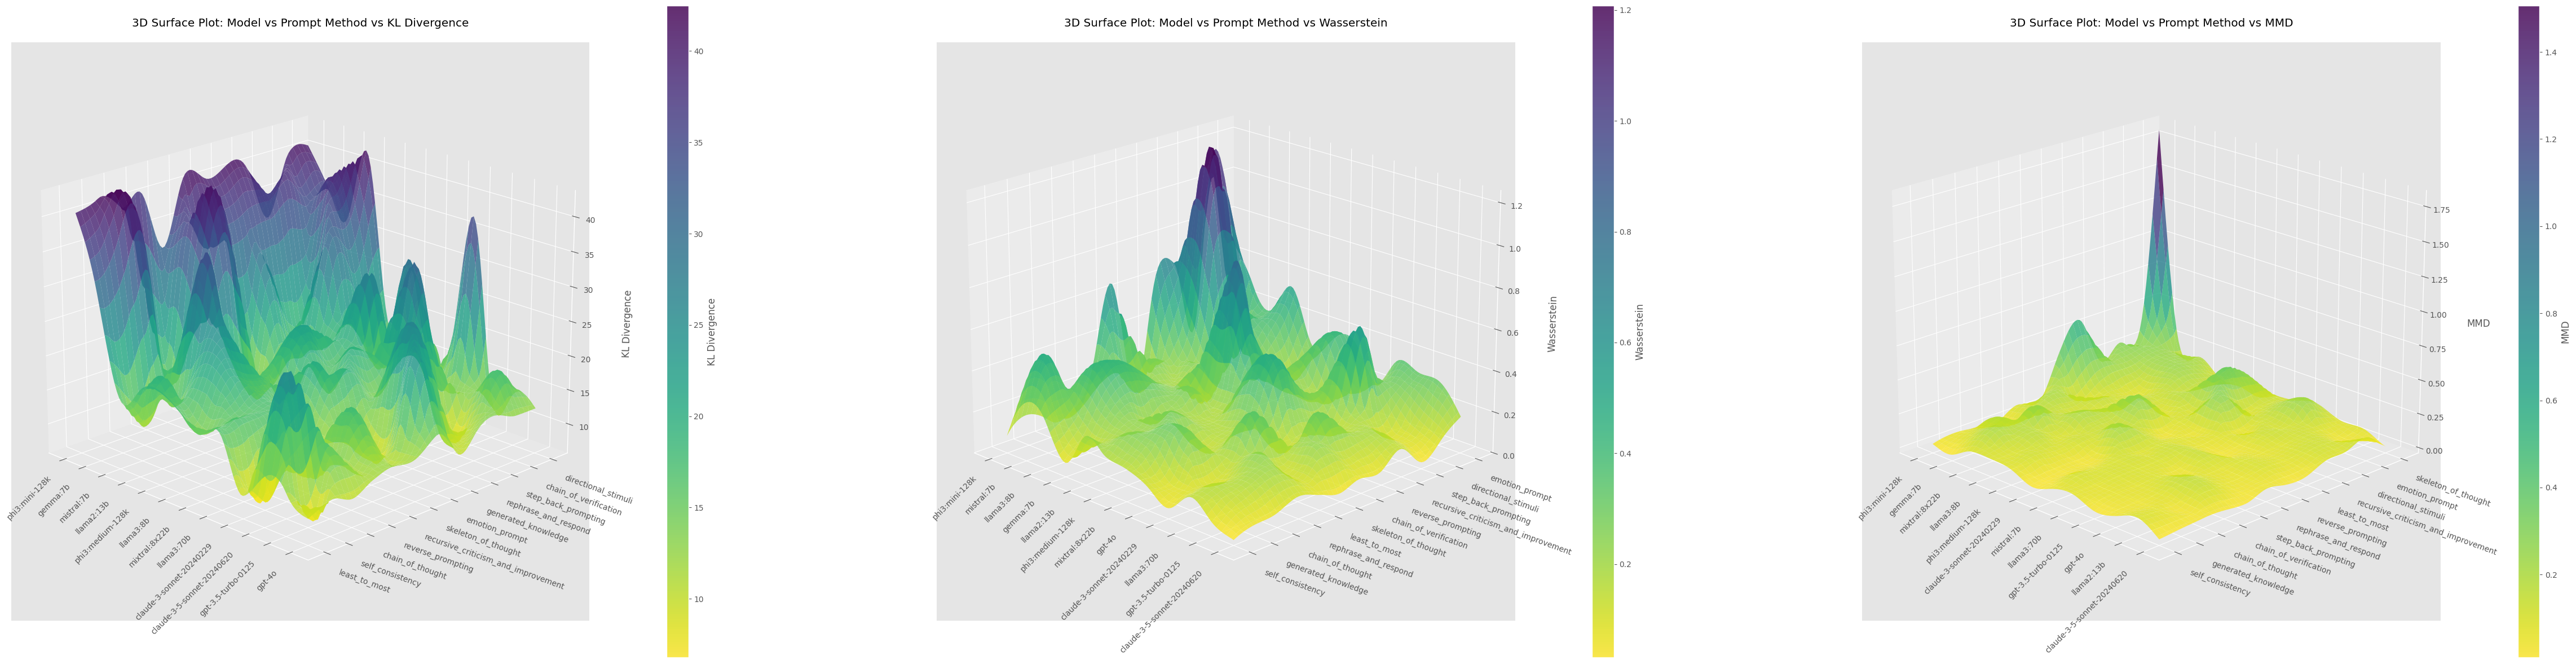

In [17]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from scipy.interpolate import griddata

# Assuming df_model_prompt_sorted is already loaded
numeric_metrics = ['KL Divergence', 'Wasserstein', 'MMD']

df_ordered = df_model_prompt_sorted

# Create a figure with subplots for each metric
fig = plt.figure(figsize=(60, 15))

for i, metric in enumerate(numeric_metrics, 1):
    # Order models based on average metric value (reversed)
    model_order = df_ordered.groupby('model')[metric].mean().sort_values(ascending=True).index

    # Order prompt_method based on average metric value (reversed)
    prompt_order = df_ordered.groupby('prompt_method')[metric].mean().sort_values(ascending=True).index

    # Create numeric mappings for ordered models and prompt methods
    model_map = {model: i for i, model in enumerate(reversed(model_order))}
    prompt_map = {method: i for i, method in enumerate(prompt_order)}

    # Create a grid of x, y coordinates
    x = np.array([model_map[m] for m in df_ordered['model']])
    y = np.array([prompt_map[p] for p in df_ordered['prompt_method']])
    z = df_ordered[metric].values

    # Create a grid for the surface plot
    xi = np.linspace(x.min(), x.max(), 100)
    yi = np.linspace(y.min(), y.max(), 100)
    X, Y = np.meshgrid(xi, yi)

    # Interpolate the z values on the grid
    Z = griddata((x, y), z, (X, Y), method='cubic')

    # Create 3D axes
    ax = fig.add_subplot(1, 3, i, projection='3d')

    # Create a custom colormap (inverted viridis)
    colors = plt.cm.viridis(np.linspace(0, 1, 256))[::-1]
    custom_cmap = LinearSegmentedColormap.from_list("inverted_viridis", colors)

    # Create the surface plot
    surf = ax.plot_surface(X, Y, Z, cmap=custom_cmap, edgecolor='none', alpha=0.8)

    # Set labels and title
    ax.set_zlabel(metric, labelpad=20)
    ax.set_title(f'3D Surface Plot: Model vs Prompt Method vs {metric}', pad=20)

    # Set tick labels
    ax.set_xticks(list(model_map.values()))
    ax.set_xticklabels(list(model_map.keys()), rotation=45, ha='right', va='top')
    ax.set_yticks(list(prompt_map.values()))
    ax.set_yticklabels(list(prompt_map.keys()), rotation=-20, ha='left')

    # Adjust tick label positions
    ax.tick_params(axis='x', which='major', pad=8)
    ax.tick_params(axis='y', which='major', pad=8)

    # Add a color bar
    cbar = fig.colorbar(surf, ax=ax, label=metric, pad=0.1, aspect=30)

    # Set view angle
    ax.view_init(elev=20, azim=-45)  # Adjusted view angle

# Adjust layout
plt.tight_layout()
plt.savefig('./images/3d_model_prompt_method.jpg')

# Show the plot
plt.show()

In [19]:
import numpy as np
import pandas as pd
from itertools import product
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

# Prepare data
features = ['target_thickness', 'pulse_width', 'energy', 'spot_size', 'intensity', 'power', 'cutoff_energy']
missing_cols = set(df_synth_raw.columns) - set(df_original.columns)
for col in missing_cols:
    df_original[col] = np.nan

df_synth_raw['source'] = 'synthetic'
df_original['source'] = 'original'

df_synth_raw_copy = df_synth_raw.copy()
df_synth_raw_copy.replace([np.inf, -np.inf], np.nan, inplace=True)
df_synth_raw_copy.dropna(subset=features, inplace=True)

combined_df = pd.concat([df_synth_raw_copy, df_original], ignore_index=True)

scaler = StandardScaler()
scaled_features = scaler.fit_transform(combined_df[features])

scaled_df = pd.DataFrame(scaled_features, columns=features)
scaled_df['source'] = combined_df['source'].values
scaled_df['model'] = combined_df['model'].values
scaled_df['prompt_method'] = combined_df['prompt_method'].values
scaled_df['sample_size'] = combined_df['sample_size'].values

from stats.statistical_tests import (
    kl_divergence_permutation_test_knn,
    multivariate_ks_test,
)

# Example usage
# model = 'claude-3-5-sonnet-20240620'
# prompt_method = 'self_consistency'
# sample_size = 'rs_size_150'

def run_tests(X, Y, alpha_level=0.05):
    # Perform the permutation test for KL divergence using KNN
    kl_stat, kl_pvalue, kl_effect = kl_divergence_permutation_test_knn(Y, X, k=5, permutations=99)

    # Perform the multivariate KS test
    ks_stat, ks_pvalue, ks_effect = multivariate_ks_test(X, Y, permutations=99)

    # Return the results in the desired format
    results = {
        'kl_statistic': kl_stat,
        'ks_statistic': ks_stat,
        'p_value_kl': kl_pvalue,
        'p_value_ks': ks_pvalue,
        'effect_size_kl': kl_effect,
        'effect_size_ks': ks_effect,
        'significant_5_kl': kl_pvalue < alpha_level,
        'significant_5_ks': ks_pvalue < alpha_level,
    }

    print('\n')

    return results

# Initialize an empty list to store results
results_list = []

# Get unique values for model, prompt_method, and sample_size
models = scaled_df['model'].unique()
prompt_methods = scaled_df['prompt_method'].unique()
sample_sizes = scaled_df['sample_size'].unique()

# Define a function to run the tests and store results
def run_and_store_results(selector, model=None, prompt_method=None, sample_size=None):
    X = scaled_df[(scaled_df['source'] == 'synthetic') & (selector)][features].values
    Y = scaled_df[scaled_df['source'] == 'original'][features].values

    if len(X) < 100:
        print('Skipping because synthetic data has less than 100 samples!')
        return

    # Calculate statistics
    print(f'Current Testing for Mode:l {model}, Prompt Method: {prompt_method}, Sample Size: {sample_size} ....')
    results = run_tests(X, Y, 0.05)

    # Add model, prompt_method, sample_size, and n_samples to results
    results['model_name'] = model
    results['prompt_method'] = prompt_method
    results['sample_size'] = sample_size
    results['n_samples'] = len(X)

    results_list.append(results)

# Progress bar setup
total_combinations = len(models) * len(prompt_methods) * len(sample_sizes) + \
                     len(models) * len(prompt_methods) + \
                     len(models) * len(sample_sizes) + \
                     len(models) + \
                     len(prompt_methods) + \
                     len(sample_sizes)
pbar = tqdm(total=total_combinations, desc="Processing combinations")

# Test for model, prompt_method, sample_size
for model, prompt_method, sample_size in product(models, prompt_methods, sample_sizes):
    selector = (scaled_df['model'] == model) & (scaled_df['prompt_method'] == prompt_method) & (scaled_df['sample_size'] == sample_size)
    run_and_store_results(selector, model, prompt_method, sample_size)
    pbar.update(1)

# Test for model, prompt_method
for model, prompt_method in product(models, prompt_methods):
    selector = (scaled_df['model'] == model) & (scaled_df['prompt_method'] == prompt_method)
    run_and_store_results(selector, model, prompt_method, None)
    pbar.update(1)

# Test for model, sample_size
for model, sample_size in product(models, sample_sizes):
    selector = (scaled_df['model'] == model) & (scaled_df['sample_size'] == sample_size)
    run_and_store_results(selector, model, None, sample_size)
    pbar.update(1)

# Test for model
for model in models:
    selector = (scaled_df['model'] == model)
    run_and_store_results(selector, model, None, None)
    pbar.update(1)

# Test for prompt_method
for prompt_method in prompt_methods:
    selector = (scaled_df['prompt_method'] == prompt_method)
    run_and_store_results(selector, None, prompt_method, None)
    pbar.update(1)

# Test for sample_size
for sample_size in sample_sizes:
    selector = (scaled_df['sample_size'] == sample_size)
    run_and_store_results(selector, None, None, sample_size)
    pbar.update(1)

pbar.close()

# Create DataFrame from results_list
results_df = pd.DataFrame(results_list)

# Reorder columns as specified
column_order = ['model_name', 'prompt_method', 'sample_size', 'n_samples', 
                'kl_statistic', 'ks_statistic', 'p_value_kl', 'p_value_ks', 
                'effect_size_kl', 'effect_size_ks', 'significant_5_kl', 'significant_5_ks']
results_df = results_df[column_order]

# Display the results
print(results_df)

# Optionally, save to CSV
results_df.to_csv('./testing_csv/hypothesis_test_results.csv', index=False)

Processing combinations:   0%|          | 0/1476 [00:00<?, ?it/s]

Current Testing for Mode:l claude-3-5-sonnet-20240620, Prompt Method: chain_of_thought, Sample Size: rs_size_5 ....
Observed KL Divergence: 12.120990534311638


Processing combinations:   0%|          | 1/1476 [00:04<1:44:01,  4.23s/it]



Current Testing for Mode:l claude-3-5-sonnet-20240620, Prompt Method: chain_of_thought, Sample Size: rs_size_10 ....
Observed KL Divergence: 11.81176329306564


Processing combinations:   0%|          | 2/1476 [00:08<1:42:18,  4.16s/it]



Current Testing for Mode:l claude-3-5-sonnet-20240620, Prompt Method: chain_of_thought, Sample Size: rs_size_25 ....
Observed KL Divergence: 4.849091033893424


Processing combinations:   0%|          | 3/1476 [00:12<1:40:07,  4.08s/it]



Current Testing for Mode:l claude-3-5-sonnet-20240620, Prompt Method: chain_of_thought, Sample Size: rs_size_50 ....
Observed KL Divergence: 8.005857609284828


Processing combinations:   0%|          | 4/1476 [00:16<1:39:08,  4.04s/it]



Current Testing for Mode:l claude-3-5-sonnet-20240620, Prompt Method: chain_of_thought, Sample Size: rs_size_100 ....
Observed KL Divergence: 12.167700061975216


Processing combinations:   0%|          | 5/1476 [00:20<1:38:24,  4.01s/it]



Current Testing for Mode:l claude-3-5-sonnet-20240620, Prompt Method: chain_of_thought, Sample Size: rs_size_150 ....
Observed KL Divergence: 11.767715609402376


Processing combinations:   0%|          | 6/1476 [00:24<1:38:11,  4.01s/it]



Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l claude-3-5-sonnet-20240620, Prompt Method: skeleton_of_thought, Sample Size: rs_size_5 ....
Observed KL Divergence: 10.898229910943524


Processing combinations:   1%|          | 8/1476 [00:28<1:14:40,  3.05s/it]



Current Testing for Mode:l claude-3-5-sonnet-20240620, Prompt Method: skeleton_of_thought, Sample Size: rs_size_10 ....
Observed KL Divergence: 10.486692927576152


Processing combinations:   1%|          | 9/1476 [00:32<1:20:57,  3.31s/it]



Current Testing for Mode:l claude-3-5-sonnet-20240620, Prompt Method: skeleton_of_thought, Sample Size: rs_size_25 ....
Observed KL Divergence: 6.722054567201723


Processing combinations:   1%|          | 10/1476 [00:36<1:26:16,  3.53s/it]



Current Testing for Mode:l claude-3-5-sonnet-20240620, Prompt Method: skeleton_of_thought, Sample Size: rs_size_50 ....
Observed KL Divergence: 1.0608310014921845


Processing combinations:   1%|          | 11/1476 [00:40<1:29:21,  3.66s/it]



Current Testing for Mode:l claude-3-5-sonnet-20240620, Prompt Method: skeleton_of_thought, Sample Size: rs_size_100 ....
Observed KL Divergence: 6.401293988865048


Processing combinations:   1%|          | 12/1476 [00:44<1:31:38,  3.76s/it]



Current Testing for Mode:l claude-3-5-sonnet-20240620, Prompt Method: skeleton_of_thought, Sample Size: rs_size_150 ....
Observed KL Divergence: 0


Processing combinations:   1%|          | 13/1476 [00:48<1:33:20,  3.83s/it]



Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l claude-3-5-sonnet-20240620, Prompt Method: self_consistency, Sample Size: rs_size_5 ....
Observed KL Divergence: 6.774214711759509


Processing combinations:   1%|          | 15/1476 [00:52<1:13:59,  3.04s/it]



Current Testing for Mode:l claude-3-5-sonnet-20240620, Prompt Method: self_consistency, Sample Size: rs_size_10 ....
Observed KL Divergence: 8.34342969845962


Processing combinations:   1%|          | 16/1476 [00:56<1:20:42,  3.32s/it]



Current Testing for Mode:l claude-3-5-sonnet-20240620, Prompt Method: self_consistency, Sample Size: rs_size_25 ....
Observed KL Divergence: 3.967827245137128


Processing combinations:   1%|          | 17/1476 [01:00<1:24:46,  3.49s/it]



Current Testing for Mode:l claude-3-5-sonnet-20240620, Prompt Method: self_consistency, Sample Size: rs_size_50 ....
Observed KL Divergence: 3.075386807264254


Processing combinations:   1%|          | 18/1476 [01:04<1:28:07,  3.63s/it]



Current Testing for Mode:l claude-3-5-sonnet-20240620, Prompt Method: self_consistency, Sample Size: rs_size_100 ....
Observed KL Divergence: 5.725843435794944


Processing combinations:   1%|▏         | 19/1476 [01:08<1:30:28,  3.73s/it]



Current Testing for Mode:l claude-3-5-sonnet-20240620, Prompt Method: self_consistency, Sample Size: rs_size_150 ....
Observed KL Divergence: 3.253142068900757


Processing combinations:   1%|▏         | 20/1476 [01:12<1:32:03,  3.79s/it]



Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l claude-3-5-sonnet-20240620, Prompt Method: generated_knowledge, Sample Size: rs_size_5 ....
Observed KL Divergence: 10.97688668387021


Processing combinations:   1%|▏         | 22/1476 [01:16<1:12:27,  2.99s/it]



Current Testing for Mode:l claude-3-5-sonnet-20240620, Prompt Method: generated_knowledge, Sample Size: rs_size_10 ....
Observed KL Divergence: 12.83096568253658


Processing combinations:   2%|▏         | 23/1476 [01:20<1:18:16,  3.23s/it]



Current Testing for Mode:l claude-3-5-sonnet-20240620, Prompt Method: generated_knowledge, Sample Size: rs_size_25 ....
Observed KL Divergence: 3.141797405923797


Processing combinations:   2%|▏         | 24/1476 [01:24<1:23:49,  3.46s/it]



Current Testing for Mode:l claude-3-5-sonnet-20240620, Prompt Method: generated_knowledge, Sample Size: rs_size_50 ....
Observed KL Divergence: 5.435342517606756


Processing combinations:   2%|▏         | 25/1476 [01:28<1:27:28,  3.62s/it]



Current Testing for Mode:l claude-3-5-sonnet-20240620, Prompt Method: generated_knowledge, Sample Size: rs_size_100 ....
Observed KL Divergence: 9.492802394080277


Processing combinations:   2%|▏         | 26/1476 [01:33<1:30:08,  3.73s/it]



Current Testing for Mode:l claude-3-5-sonnet-20240620, Prompt Method: generated_knowledge, Sample Size: rs_size_150 ....
Observed KL Divergence: 8.847415896244001


Processing combinations:   2%|▏         | 27/1476 [01:37<1:32:26,  3.83s/it]



Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l claude-3-5-sonnet-20240620, Prompt Method: least_to_most, Sample Size: rs_size_5 ....
Observed KL Divergence: 7.475312516235945


Processing combinations:   2%|▏         | 29/1476 [01:41<1:13:01,  3.03s/it]



Current Testing for Mode:l claude-3-5-sonnet-20240620, Prompt Method: least_to_most, Sample Size: rs_size_10 ....
Observed KL Divergence: 9.932252767481613


Processing combinations:   2%|▏         | 30/1476 [01:45<1:18:53,  3.27s/it]



Current Testing for Mode:l claude-3-5-sonnet-20240620, Prompt Method: least_to_most, Sample Size: rs_size_25 ....
Observed KL Divergence: 5.978745348714355


Processing combinations:   2%|▏         | 31/1476 [01:49<1:23:34,  3.47s/it]



Current Testing for Mode:l claude-3-5-sonnet-20240620, Prompt Method: least_to_most, Sample Size: rs_size_50 ....
Observed KL Divergence: 4.167028528758937


Processing combinations:   2%|▏         | 32/1476 [01:53<1:27:03,  3.62s/it]



Current Testing for Mode:l claude-3-5-sonnet-20240620, Prompt Method: least_to_most, Sample Size: rs_size_100 ....
Observed KL Divergence: 14.095719698311047


Processing combinations:   2%|▏         | 33/1476 [01:57<1:29:40,  3.73s/it]



Current Testing for Mode:l claude-3-5-sonnet-20240620, Prompt Method: least_to_most, Sample Size: rs_size_150 ....
Observed KL Divergence: 8.140885145167605


Processing combinations:   2%|▏         | 34/1476 [02:01<1:32:50,  3.86s/it]



Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l claude-3-5-sonnet-20240620, Prompt Method: chain_of_verification, Sample Size: rs_size_5 ....
Observed KL Divergence: 5.569659495092402


Processing combinations:   2%|▏         | 36/1476 [02:05<1:13:05,  3.05s/it]



Current Testing for Mode:l claude-3-5-sonnet-20240620, Prompt Method: chain_of_verification, Sample Size: rs_size_10 ....
Observed KL Divergence: 7.1007702020031624


Processing combinations:   3%|▎         | 37/1476 [02:09<1:18:36,  3.28s/it]



Current Testing for Mode:l claude-3-5-sonnet-20240620, Prompt Method: chain_of_verification, Sample Size: rs_size_25 ....
Observed KL Divergence: 7.216327582219511


Processing combinations:   3%|▎         | 38/1476 [02:13<1:22:56,  3.46s/it]



Current Testing for Mode:l claude-3-5-sonnet-20240620, Prompt Method: chain_of_verification, Sample Size: rs_size_50 ....
Observed KL Divergence: 8.699588628377457


Processing combinations:   3%|▎         | 39/1476 [02:17<1:26:46,  3.62s/it]



Current Testing for Mode:l claude-3-5-sonnet-20240620, Prompt Method: chain_of_verification, Sample Size: rs_size_100 ....
Observed KL Divergence: 12.2578114936135


Processing combinations:   3%|▎         | 40/1476 [02:21<1:29:48,  3.75s/it]



Current Testing for Mode:l claude-3-5-sonnet-20240620, Prompt Method: chain_of_verification, Sample Size: rs_size_150 ....
Observed KL Divergence: 10.401560164438994


Processing combinations:   3%|▎         | 41/1476 [02:25<1:32:28,  3.87s/it]



Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l claude-3-5-sonnet-20240620, Prompt Method: step_back_prompting, Sample Size: rs_size_5 ....
Observed KL Divergence: 5.394987513917565


Processing combinations:   3%|▎         | 43/1476 [02:29<1:12:52,  3.05s/it]



Current Testing for Mode:l claude-3-5-sonnet-20240620, Prompt Method: step_back_prompting, Sample Size: rs_size_10 ....
Observed KL Divergence: 9.28511021222994


Processing combinations:   3%|▎         | 44/1476 [02:34<1:18:56,  3.31s/it]



Current Testing for Mode:l claude-3-5-sonnet-20240620, Prompt Method: step_back_prompting, Sample Size: rs_size_25 ....
Observed KL Divergence: 5.607837354626032


Processing combinations:   3%|▎         | 45/1476 [02:38<1:23:49,  3.52s/it]



Current Testing for Mode:l claude-3-5-sonnet-20240620, Prompt Method: step_back_prompting, Sample Size: rs_size_50 ....
Observed KL Divergence: 5.031054299893714


Processing combinations:   3%|▎         | 46/1476 [02:42<1:27:15,  3.66s/it]



Current Testing for Mode:l claude-3-5-sonnet-20240620, Prompt Method: step_back_prompting, Sample Size: rs_size_100 ....
Observed KL Divergence: 9.286775264633231


Processing combinations:   3%|▎         | 47/1476 [02:46<1:30:03,  3.78s/it]



Current Testing for Mode:l claude-3-5-sonnet-20240620, Prompt Method: step_back_prompting, Sample Size: rs_size_150 ....
Observed KL Divergence: 2.7516707746421245


Processing combinations:   3%|▎         | 48/1476 [02:50<1:33:19,  3.92s/it]



Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l claude-3-5-sonnet-20240620, Prompt Method: rephrase_and_respond, Sample Size: rs_size_5 ....
Observed KL Divergence: 10.806816500224695


Processing combinations:   3%|▎         | 50/1476 [02:54<1:13:33,  3.09s/it]



Current Testing for Mode:l claude-3-5-sonnet-20240620, Prompt Method: rephrase_and_respond, Sample Size: rs_size_10 ....
Observed KL Divergence: 11.944857351724963


Processing combinations:   3%|▎         | 51/1476 [02:58<1:19:19,  3.34s/it]



Current Testing for Mode:l claude-3-5-sonnet-20240620, Prompt Method: rephrase_and_respond, Sample Size: rs_size_25 ....
Observed KL Divergence: 7.019322623151572


Processing combinations:   4%|▎         | 52/1476 [03:02<1:22:47,  3.49s/it]



Current Testing for Mode:l claude-3-5-sonnet-20240620, Prompt Method: rephrase_and_respond, Sample Size: rs_size_50 ....
Observed KL Divergence: 12.865603387041851


Processing combinations:   4%|▎         | 53/1476 [03:06<1:25:49,  3.62s/it]



Current Testing for Mode:l claude-3-5-sonnet-20240620, Prompt Method: rephrase_and_respond, Sample Size: rs_size_100 ....
Observed KL Divergence: 14.573787555587563


Processing combinations:   4%|▎         | 54/1476 [03:10<1:27:45,  3.70s/it]



Current Testing for Mode:l claude-3-5-sonnet-20240620, Prompt Method: rephrase_and_respond, Sample Size: rs_size_150 ....
Observed KL Divergence: 12.478669325627282


Processing combinations:   4%|▎         | 55/1476 [03:14<1:29:41,  3.79s/it]



Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l claude-3-5-sonnet-20240620, Prompt Method: emotion_prompt, Sample Size: rs_size_5 ....
Observed KL Divergence: 16.395983626585036


Processing combinations:   4%|▍         | 57/1476 [03:18<1:11:14,  3.01s/it]



Current Testing for Mode:l claude-3-5-sonnet-20240620, Prompt Method: emotion_prompt, Sample Size: rs_size_10 ....
Observed KL Divergence: 18.2477132616152


Processing combinations:   4%|▍         | 58/1476 [03:22<1:17:50,  3.29s/it]



Current Testing for Mode:l claude-3-5-sonnet-20240620, Prompt Method: emotion_prompt, Sample Size: rs_size_25 ....
Observed KL Divergence: 17.846809285902022


Processing combinations:   4%|▍         | 59/1476 [03:26<1:21:52,  3.47s/it]



Current Testing for Mode:l claude-3-5-sonnet-20240620, Prompt Method: emotion_prompt, Sample Size: rs_size_50 ....
Observed KL Divergence: 21.316006854046602


Processing combinations:   4%|▍         | 60/1476 [03:30<1:25:15,  3.61s/it]



Current Testing for Mode:l claude-3-5-sonnet-20240620, Prompt Method: emotion_prompt, Sample Size: rs_size_100 ....
Observed KL Divergence: 22.204533862450912


Processing combinations:   4%|▍         | 61/1476 [03:34<1:27:46,  3.72s/it]



Current Testing for Mode:l claude-3-5-sonnet-20240620, Prompt Method: emotion_prompt, Sample Size: rs_size_150 ....
Observed KL Divergence: 27.146196953266195


Processing combinations:   4%|▍         | 62/1476 [03:38<1:29:30,  3.80s/it]



Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l claude-3-5-sonnet-20240620, Prompt Method: directional_stimuli, Sample Size: rs_size_5 ....
Observed KL Divergence: 15.713734725794462


Processing combinations:   4%|▍         | 64/1476 [03:43<1:10:43,  3.01s/it]



Current Testing for Mode:l claude-3-5-sonnet-20240620, Prompt Method: directional_stimuli, Sample Size: rs_size_10 ....
Observed KL Divergence: 22.181644160722303


Processing combinations:   4%|▍         | 65/1476 [03:46<1:16:05,  3.24s/it]



Current Testing for Mode:l claude-3-5-sonnet-20240620, Prompt Method: directional_stimuli, Sample Size: rs_size_25 ....
Observed KL Divergence: 14.920210963095375


Processing combinations:   4%|▍         | 66/1476 [03:51<1:21:26,  3.47s/it]



Current Testing for Mode:l claude-3-5-sonnet-20240620, Prompt Method: directional_stimuli, Sample Size: rs_size_50 ....
Observed KL Divergence: 15.51341415070215


Processing combinations:   5%|▍         | 67/1476 [03:55<1:25:03,  3.62s/it]



Current Testing for Mode:l claude-3-5-sonnet-20240620, Prompt Method: directional_stimuli, Sample Size: rs_size_100 ....
Observed KL Divergence: 19.8563274566836


Processing combinations:   5%|▍         | 68/1476 [03:59<1:28:51,  3.79s/it]



Current Testing for Mode:l claude-3-5-sonnet-20240620, Prompt Method: directional_stimuli, Sample Size: rs_size_150 ....
Observed KL Divergence: 21.172284649679558


Processing combinations:   5%|▍         | 69/1476 [04:03<1:31:20,  3.89s/it]



Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l claude-3-5-sonnet-20240620, Prompt Method: recursive_criticism_and_improvement, Sample Size: rs_size_5 ....
Observed KL Divergence: 16.618662965533325


Processing combinations:   5%|▍         | 71/1476 [04:07<1:11:16,  3.04s/it]



Current Testing for Mode:l claude-3-5-sonnet-20240620, Prompt Method: recursive_criticism_and_improvement, Sample Size: rs_size_10 ....
Observed KL Divergence: 21.659795564312958


Processing combinations:   5%|▍         | 72/1476 [04:11<1:16:46,  3.28s/it]



Current Testing for Mode:l claude-3-5-sonnet-20240620, Prompt Method: recursive_criticism_and_improvement, Sample Size: rs_size_25 ....
Observed KL Divergence: 15.225326768512772


Processing combinations:   5%|▍         | 73/1476 [04:15<1:21:06,  3.47s/it]



Current Testing for Mode:l claude-3-5-sonnet-20240620, Prompt Method: recursive_criticism_and_improvement, Sample Size: rs_size_50 ....
Observed KL Divergence: 18.73678997574056


Processing combinations:   5%|▌         | 74/1476 [04:19<1:24:34,  3.62s/it]



Current Testing for Mode:l claude-3-5-sonnet-20240620, Prompt Method: recursive_criticism_and_improvement, Sample Size: rs_size_100 ....
Observed KL Divergence: 20.962157494868883


Processing combinations:   5%|▌         | 75/1476 [04:23<1:27:20,  3.74s/it]



Current Testing for Mode:l claude-3-5-sonnet-20240620, Prompt Method: recursive_criticism_and_improvement, Sample Size: rs_size_150 ....
Observed KL Divergence: 19.967567814085946


Processing combinations:   5%|▌         | 76/1476 [04:27<1:29:24,  3.83s/it]



Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l claude-3-5-sonnet-20240620, Prompt Method: reverse_prompting, Sample Size: rs_size_5 ....
Observed KL Divergence: 9.529053949839923


Processing combinations:   5%|▌         | 78/1476 [04:31<1:10:52,  3.04s/it]



Current Testing for Mode:l claude-3-5-sonnet-20240620, Prompt Method: reverse_prompting, Sample Size: rs_size_10 ....
Observed KL Divergence: 12.50400545197211


Processing combinations:   5%|▌         | 79/1476 [04:35<1:16:28,  3.28s/it]



Current Testing for Mode:l claude-3-5-sonnet-20240620, Prompt Method: reverse_prompting, Sample Size: rs_size_25 ....
Observed KL Divergence: 6.537771494911864


Processing combinations:   5%|▌         | 80/1476 [04:39<1:20:49,  3.47s/it]



Current Testing for Mode:l claude-3-5-sonnet-20240620, Prompt Method: reverse_prompting, Sample Size: rs_size_50 ....
Observed KL Divergence: 6.394511719430761


Processing combinations:   5%|▌         | 81/1476 [04:43<1:24:26,  3.63s/it]



Current Testing for Mode:l claude-3-5-sonnet-20240620, Prompt Method: reverse_prompting, Sample Size: rs_size_100 ....
Observed KL Divergence: 15.71741846486664


Processing combinations:   6%|▌         | 82/1476 [04:47<1:26:45,  3.73s/it]



Current Testing for Mode:l claude-3-5-sonnet-20240620, Prompt Method: reverse_prompting, Sample Size: rs_size_150 ....
Observed KL Divergence: 7.872625628732249


Processing combinations:   6%|▌         | 87/1476 [04:52<34:09,  1.48s/it]  



Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!


Processing combinations:   6%|▌         | 91/1476 [04:52<18:21,  1.26it/s]

Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l claude-3-sonnet-20240229, Prompt Method: chain_of_thought, Sample Size: rs_size_10 ....
Observed KL Divergence: 21.861275154108476


Processing combinations:   6%|▋         | 93/1476 [04:55<23:56,  1.04s/it]



Current Testing for Mode:l claude-3-sonnet-20240229, Prompt Method: chain_of_thought, Sample Size: rs_size_25 ....
Observed KL Divergence: 14.52506600498444


KS Test Permutations: 100%|██████████| 99/99 [00:03<00:00, 28.90it/s]




Current Testing for Mode:l claude-3-sonnet-20240229, Prompt Method: chain_of_thought, Sample Size: rs_size_50 ....
Observed KL Divergence: 15.62178299422357


Processing combinations:   6%|▋         | 95/1476 [05:03<40:09,  1.74s/it]



Current Testing for Mode:l claude-3-sonnet-20240229, Prompt Method: chain_of_thought, Sample Size: rs_size_100 ....
Observed KL Divergence: 16.760192007824127


Processing combinations:   7%|▋         | 96/1476 [05:06<47:30,  2.07s/it]



Current Testing for Mode:l claude-3-sonnet-20240229, Prompt Method: chain_of_thought, Sample Size: rs_size_150 ....
Observed KL Divergence: 18.86589488077047


Processing combinations:   7%|▋         | 97/1476 [05:10<55:35,  2.42s/it]



Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l claude-3-sonnet-20240229, Prompt Method: skeleton_of_thought, Sample Size: rs_size_5 ....
Observed KL Divergence: 21.886555534778328


Processing combinations:   7%|▋         | 99/1476 [05:14<52:11,  2.27s/it]



Current Testing for Mode:l claude-3-sonnet-20240229, Prompt Method: skeleton_of_thought, Sample Size: rs_size_10 ....
Observed KL Divergence: 21.92445196818053


Processing combinations:   7%|▋         | 100/1476 [05:18<58:00,  2.53s/it]



Current Testing for Mode:l claude-3-sonnet-20240229, Prompt Method: skeleton_of_thought, Sample Size: rs_size_25 ....
Observed KL Divergence: 16.951308869547717


Processing combinations:   7%|▋         | 101/1476 [05:22<1:04:43,  2.82s/it]



Current Testing for Mode:l claude-3-sonnet-20240229, Prompt Method: skeleton_of_thought, Sample Size: rs_size_50 ....
Observed KL Divergence: 8.771718568507096


Processing combinations:   7%|▋         | 102/1476 [05:26<1:11:52,  3.14s/it]



Current Testing for Mode:l claude-3-sonnet-20240229, Prompt Method: skeleton_of_thought, Sample Size: rs_size_100 ....
Observed KL Divergence: 14.468523431957493


Processing combinations:   7%|▋         | 103/1476 [05:30<1:16:26,  3.34s/it]



Current Testing for Mode:l claude-3-sonnet-20240229, Prompt Method: skeleton_of_thought, Sample Size: rs_size_150 ....
Observed KL Divergence: 21.73647592731997


Processing combinations:   7%|▋         | 104/1476 [05:34<1:19:14,  3.47s/it]



Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l claude-3-sonnet-20240229, Prompt Method: self_consistency, Sample Size: rs_size_5 ....
Observed KL Divergence: 21.891680160224304


Processing combinations:   7%|▋         | 106/1476 [05:37<1:03:01,  2.76s/it]



Current Testing for Mode:l claude-3-sonnet-20240229, Prompt Method: self_consistency, Sample Size: rs_size_10 ....
Observed KL Divergence: 17.017265721978134


Processing combinations:   7%|▋         | 107/1476 [05:41<1:09:01,  3.02s/it]



Current Testing for Mode:l claude-3-sonnet-20240229, Prompt Method: self_consistency, Sample Size: rs_size_25 ....
Observed KL Divergence: 8.842375777985614


Processing combinations:   7%|▋         | 108/1476 [05:45<1:15:08,  3.30s/it]



Current Testing for Mode:l claude-3-sonnet-20240229, Prompt Method: self_consistency, Sample Size: rs_size_50 ....
Observed KL Divergence: 5.539098855794711


Processing combinations:   7%|▋         | 109/1476 [05:49<1:18:52,  3.46s/it]



Current Testing for Mode:l claude-3-sonnet-20240229, Prompt Method: self_consistency, Sample Size: rs_size_100 ....
Observed KL Divergence: 8.692963051457406


Processing combinations:   7%|▋         | 110/1476 [05:53<1:22:09,  3.61s/it]



Current Testing for Mode:l claude-3-sonnet-20240229, Prompt Method: self_consistency, Sample Size: rs_size_150 ....
Observed KL Divergence: 6.8292799924004175


Processing combinations:   8%|▊         | 111/1476 [05:57<1:25:08,  3.74s/it]



Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l claude-3-sonnet-20240229, Prompt Method: generated_knowledge, Sample Size: rs_size_5 ....
Observed KL Divergence: 23.253789463205123


Processing combinations:   8%|▊         | 113/1476 [06:01<1:07:41,  2.98s/it]



Current Testing for Mode:l claude-3-sonnet-20240229, Prompt Method: generated_knowledge, Sample Size: rs_size_10 ....
Observed KL Divergence: 15.841202925201033


Processing combinations:   8%|▊         | 114/1476 [06:05<1:13:03,  3.22s/it]



Current Testing for Mode:l claude-3-sonnet-20240229, Prompt Method: generated_knowledge, Sample Size: rs_size_25 ....
Observed KL Divergence: 10.06223132219853


Processing combinations:   8%|▊         | 115/1476 [06:09<1:17:13,  3.40s/it]



Current Testing for Mode:l claude-3-sonnet-20240229, Prompt Method: generated_knowledge, Sample Size: rs_size_50 ....
Observed KL Divergence: 9.32082233770768


Processing combinations:   8%|▊         | 116/1476 [06:13<1:21:05,  3.58s/it]



Current Testing for Mode:l claude-3-sonnet-20240229, Prompt Method: generated_knowledge, Sample Size: rs_size_100 ....
Observed KL Divergence: 8.114081440325325


Processing combinations:   8%|▊         | 117/1476 [06:17<1:23:26,  3.68s/it]



Current Testing for Mode:l claude-3-sonnet-20240229, Prompt Method: generated_knowledge, Sample Size: rs_size_150 ....
Observed KL Divergence: 12.497031246412988


Processing combinations:   8%|▊         | 118/1476 [06:21<1:25:26,  3.78s/it]



Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l claude-3-sonnet-20240229, Prompt Method: least_to_most, Sample Size: rs_size_5 ....
Observed KL Divergence: 26.56956446585624


Processing combinations:   8%|▊         | 120/1476 [06:25<1:07:09,  2.97s/it]



Current Testing for Mode:l claude-3-sonnet-20240229, Prompt Method: least_to_most, Sample Size: rs_size_10 ....
Observed KL Divergence: 25.137701655652418


Processing combinations:   8%|▊         | 121/1476 [06:29<1:12:42,  3.22s/it]



Current Testing for Mode:l claude-3-sonnet-20240229, Prompt Method: least_to_most, Sample Size: rs_size_25 ....
Observed KL Divergence: 18.105456508722025


Processing combinations:   8%|▊         | 122/1476 [06:33<1:16:49,  3.40s/it]



Current Testing for Mode:l claude-3-sonnet-20240229, Prompt Method: least_to_most, Sample Size: rs_size_50 ....
Observed KL Divergence: 18.00860422384919


Processing combinations:   8%|▊         | 123/1476 [06:37<1:20:55,  3.59s/it]



Current Testing for Mode:l claude-3-sonnet-20240229, Prompt Method: least_to_most, Sample Size: rs_size_100 ....
Observed KL Divergence: 26.35068812077618


Processing combinations:   8%|▊         | 124/1476 [06:41<1:23:56,  3.73s/it]



Current Testing for Mode:l claude-3-sonnet-20240229, Prompt Method: least_to_most, Sample Size: rs_size_150 ....
Observed KL Divergence: 26.621554826195013


Processing combinations:   8%|▊         | 125/1476 [06:46<1:26:14,  3.83s/it]



Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l claude-3-sonnet-20240229, Prompt Method: chain_of_verification, Sample Size: rs_size_5 ....
Observed KL Divergence: 22.137197733153656


Processing combinations:   9%|▊         | 127/1476 [06:50<1:07:44,  3.01s/it]



Current Testing for Mode:l claude-3-sonnet-20240229, Prompt Method: chain_of_verification, Sample Size: rs_size_10 ....
Observed KL Divergence: 21.93094301649683


Processing combinations:   9%|▊         | 128/1476 [06:53<1:12:02,  3.21s/it]



Current Testing for Mode:l claude-3-sonnet-20240229, Prompt Method: chain_of_verification, Sample Size: rs_size_25 ....
Observed KL Divergence: 18.780392359690286


Processing combinations:   9%|▊         | 129/1476 [06:57<1:15:42,  3.37s/it]



Current Testing for Mode:l claude-3-sonnet-20240229, Prompt Method: chain_of_verification, Sample Size: rs_size_50 ....
Observed KL Divergence: 25.657723462384467


Processing combinations:   9%|▉         | 130/1476 [07:01<1:19:05,  3.53s/it]



Current Testing for Mode:l claude-3-sonnet-20240229, Prompt Method: chain_of_verification, Sample Size: rs_size_100 ....
Observed KL Divergence: 15.975671151368458


Processing combinations:   9%|▉         | 131/1476 [07:05<1:22:25,  3.68s/it]



Current Testing for Mode:l claude-3-sonnet-20240229, Prompt Method: chain_of_verification, Sample Size: rs_size_150 ....
Observed KL Divergence: 19.355289663691654


Processing combinations:   9%|▉         | 132/1476 [07:09<1:24:56,  3.79s/it]



Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l claude-3-sonnet-20240229, Prompt Method: step_back_prompting, Sample Size: rs_size_5 ....
Observed KL Divergence: 35.97674491398275


Processing combinations:   9%|▉         | 134/1476 [07:13<1:03:41,  2.85s/it]



Current Testing for Mode:l claude-3-sonnet-20240229, Prompt Method: step_back_prompting, Sample Size: rs_size_10 ....
Observed KL Divergence: 34.47023090146984


Processing combinations:   9%|▉         | 135/1476 [07:16<1:07:21,  3.01s/it]



Current Testing for Mode:l claude-3-sonnet-20240229, Prompt Method: step_back_prompting, Sample Size: rs_size_25 ....
Observed KL Divergence: 26.995041024459194


Processing combinations:   9%|▉         | 136/1476 [07:20<1:12:58,  3.27s/it]



Current Testing for Mode:l claude-3-sonnet-20240229, Prompt Method: step_back_prompting, Sample Size: rs_size_50 ....
Observed KL Divergence: 23.197210984299357


Processing combinations:   9%|▉         | 137/1476 [07:24<1:17:31,  3.47s/it]



Current Testing for Mode:l claude-3-sonnet-20240229, Prompt Method: step_back_prompting, Sample Size: rs_size_100 ....
Observed KL Divergence: 29.442011465227854


Processing combinations:   9%|▉         | 138/1476 [07:28<1:19:30,  3.57s/it]



Current Testing for Mode:l claude-3-sonnet-20240229, Prompt Method: step_back_prompting, Sample Size: rs_size_150 ....
Observed KL Divergence: 28.796972141271574


Processing combinations:   9%|▉         | 139/1476 [07:32<1:22:03,  3.68s/it]



Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l claude-3-sonnet-20240229, Prompt Method: rephrase_and_respond, Sample Size: rs_size_5 ....
Observed KL Divergence: 21.004633824837946


Processing combinations:  10%|▉         | 141/1476 [07:36<1:05:41,  2.95s/it]



Current Testing for Mode:l claude-3-sonnet-20240229, Prompt Method: rephrase_and_respond, Sample Size: rs_size_10 ....
Observed KL Divergence: 22.23909616681186


Processing combinations:  10%|▉         | 142/1476 [07:40<1:11:24,  3.21s/it]



Current Testing for Mode:l claude-3-sonnet-20240229, Prompt Method: rephrase_and_respond, Sample Size: rs_size_25 ....
Observed KL Divergence: 22.31313144925804


Processing combinations:  10%|▉         | 143/1476 [07:44<1:16:26,  3.44s/it]



Current Testing for Mode:l claude-3-sonnet-20240229, Prompt Method: rephrase_and_respond, Sample Size: rs_size_50 ....
Observed KL Divergence: 22.85040268144805


Processing combinations:  10%|▉         | 144/1476 [07:48<1:19:41,  3.59s/it]



Current Testing for Mode:l claude-3-sonnet-20240229, Prompt Method: rephrase_and_respond, Sample Size: rs_size_100 ....
Observed KL Divergence: 23.211146868149832


Processing combinations:  10%|▉         | 145/1476 [07:52<1:22:28,  3.72s/it]



Current Testing for Mode:l claude-3-sonnet-20240229, Prompt Method: rephrase_and_respond, Sample Size: rs_size_150 ....
Observed KL Divergence: 25.28563159416723


Processing combinations:  10%|▉         | 146/1476 [07:56<1:25:14,  3.85s/it]



Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l claude-3-sonnet-20240229, Prompt Method: emotion_prompt, Sample Size: rs_size_5 ....
Observed KL Divergence: 24.32113391849028


Processing combinations:  10%|█         | 148/1476 [08:01<1:07:22,  3.04s/it]



Current Testing for Mode:l claude-3-sonnet-20240229, Prompt Method: emotion_prompt, Sample Size: rs_size_10 ....
Observed KL Divergence: 25.115574097582957


Processing combinations:  10%|█         | 149/1476 [08:05<1:13:07,  3.31s/it]



Current Testing for Mode:l claude-3-sonnet-20240229, Prompt Method: emotion_prompt, Sample Size: rs_size_25 ....
Observed KL Divergence: 28.064807512460522


Processing combinations:  10%|█         | 150/1476 [08:09<1:17:18,  3.50s/it]



Current Testing for Mode:l claude-3-sonnet-20240229, Prompt Method: emotion_prompt, Sample Size: rs_size_50 ....
Observed KL Divergence: 27.912168422417505


Processing combinations:  10%|█         | 151/1476 [08:13<1:20:33,  3.65s/it]



Current Testing for Mode:l claude-3-sonnet-20240229, Prompt Method: emotion_prompt, Sample Size: rs_size_100 ....
Observed KL Divergence: 25.636300758829314


Processing combinations:  10%|█         | 152/1476 [08:17<1:22:17,  3.73s/it]



Current Testing for Mode:l claude-3-sonnet-20240229, Prompt Method: emotion_prompt, Sample Size: rs_size_150 ....
Observed KL Divergence: 28.21311671672431


Processing combinations:  10%|█         | 153/1476 [08:21<1:23:28,  3.79s/it]



Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l claude-3-sonnet-20240229, Prompt Method: directional_stimuli, Sample Size: rs_size_5 ....
Observed KL Divergence: 23.216130410531676


Processing combinations:  11%|█         | 155/1476 [08:25<1:05:41,  2.98s/it]



Current Testing for Mode:l claude-3-sonnet-20240229, Prompt Method: directional_stimuli, Sample Size: rs_size_10 ....
Observed KL Divergence: 26.62743214364482


Processing combinations:  11%|█         | 156/1476 [08:29<1:11:10,  3.24s/it]



Current Testing for Mode:l claude-3-sonnet-20240229, Prompt Method: directional_stimuli, Sample Size: rs_size_25 ....
Observed KL Divergence: 24.039175774275485


Processing combinations:  11%|█         | 157/1476 [08:33<1:15:15,  3.42s/it]



Current Testing for Mode:l claude-3-sonnet-20240229, Prompt Method: directional_stimuli, Sample Size: rs_size_50 ....
Observed KL Divergence: 26.51351473583782


Processing combinations:  11%|█         | 158/1476 [08:37<1:18:51,  3.59s/it]



Current Testing for Mode:l claude-3-sonnet-20240229, Prompt Method: directional_stimuli, Sample Size: rs_size_100 ....
Observed KL Divergence: 26.38107651242914


Processing combinations:  11%|█         | 159/1476 [08:41<1:20:59,  3.69s/it]



Current Testing for Mode:l claude-3-sonnet-20240229, Prompt Method: directional_stimuli, Sample Size: rs_size_150 ....
Observed KL Divergence: 24.740967415925965


Processing combinations:  11%|█         | 160/1476 [08:45<1:22:44,  3.77s/it]



Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l claude-3-sonnet-20240229, Prompt Method: recursive_criticism_and_improvement, Sample Size: rs_size_5 ....
Observed KL Divergence: 27.803394611447473


Processing combinations:  11%|█         | 162/1476 [08:48<1:01:48,  2.82s/it]



Current Testing for Mode:l claude-3-sonnet-20240229, Prompt Method: recursive_criticism_and_improvement, Sample Size: rs_size_10 ....
Observed KL Divergence: 24.928099312319365


Processing combinations:  11%|█         | 163/1476 [08:51<1:05:15,  2.98s/it]



Current Testing for Mode:l claude-3-sonnet-20240229, Prompt Method: recursive_criticism_and_improvement, Sample Size: rs_size_25 ....
Observed KL Divergence: 24.853104677943623


Processing combinations:  11%|█         | 164/1476 [08:55<1:09:44,  3.19s/it]



Current Testing for Mode:l claude-3-sonnet-20240229, Prompt Method: recursive_criticism_and_improvement, Sample Size: rs_size_50 ....
Observed KL Divergence: 22.67035201628932


Processing combinations:  11%|█         | 165/1476 [08:59<1:13:55,  3.38s/it]



Current Testing for Mode:l claude-3-sonnet-20240229, Prompt Method: recursive_criticism_and_improvement, Sample Size: rs_size_100 ....
Observed KL Divergence: 24.606929565076804


Processing combinations:  11%|█         | 166/1476 [09:03<1:17:14,  3.54s/it]



Current Testing for Mode:l claude-3-sonnet-20240229, Prompt Method: recursive_criticism_and_improvement, Sample Size: rs_size_150 ....
Observed KL Divergence: 25.824462123270226


Processing combinations:  11%|█▏        | 167/1476 [09:07<1:19:40,  3.65s/it]



Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l claude-3-sonnet-20240229, Prompt Method: reverse_prompting, Sample Size: rs_size_5 ....
Observed KL Divergence: 0


Processing combinations:  11%|█▏        | 169/1476 [09:10<1:00:45,  2.79s/it]



Current Testing for Mode:l claude-3-sonnet-20240229, Prompt Method: reverse_prompting, Sample Size: rs_size_10 ....
Observed KL Divergence: 23.609216170022176


Processing combinations:  12%|█▏        | 170/1476 [09:14<1:04:05,  2.94s/it]



Current Testing for Mode:l claude-3-sonnet-20240229, Prompt Method: reverse_prompting, Sample Size: rs_size_25 ....
Observed KL Divergence: 19.360599684671044


Processing combinations:  12%|█▏        | 171/1476 [09:17<1:07:24,  3.10s/it]



Current Testing for Mode:l claude-3-sonnet-20240229, Prompt Method: reverse_prompting, Sample Size: rs_size_50 ....
Observed KL Divergence: 11.960831565377696


Processing combinations:  12%|█▏        | 172/1476 [09:21<1:12:16,  3.33s/it]



Current Testing for Mode:l claude-3-sonnet-20240229, Prompt Method: reverse_prompting, Sample Size: rs_size_100 ....
Observed KL Divergence: 23.21295121563049


Processing combinations:  12%|█▏        | 173/1476 [09:25<1:13:49,  3.40s/it]



Current Testing for Mode:l claude-3-sonnet-20240229, Prompt Method: reverse_prompting, Sample Size: rs_size_150 ....
Observed KL Divergence: 22.373794559716078


Processing combinations:  12%|█▏        | 178/1476 [09:29<29:56,  1.38s/it]  



Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!


Processing combinations:  13%|█▎        | 186/1476 [09:29<10:11,  2.11it/s]

Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!


Processing combinations:  13%|█▎        | 193/1476 [09:30<04:56,  4.33it/s]

Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!


Processing combinations:  14%|█▎        | 200/1476 [09:30<02:41,  7.92it/s]

Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l gemma:7b, Prompt Method: self_consistency, Sample Size: rs_size_150 ....
Observed KL Divergence: 0.6928273983896475


Processing combinations:  14%|█▍        | 206/1476 [09:33<06:16,  3.37it/s]



Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l gemma:7b, Prompt Method: generated_knowledge, Sample Size: rs_size_100 ....
Observed KL Divergence: 9.712119674546118


Processing combinations:  14%|█▍        | 213/1476 [09:36<07:12,  2.92it/s]



Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!


Processing combinations:  15%|█▍        | 220/1476 [09:37<03:45,  5.56it/s]

Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!


Processing combinations:  15%|█▌        | 227/1476 [09:37<02:09,  9.66it/s]

Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!


Processing combinations:  16%|█▌        | 233/1476 [09:37<01:29, 13.88it/s]

Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!


Processing combinations:  16%|█▋        | 240/1476 [09:37<01:03, 19.61it/s]

Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!


Processing combinations:  17%|█▋        | 247/1476 [09:38<00:51, 23.89it/s]

Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!


Processing combinations:  17%|█▋        | 253/1476 [09:38<00:47, 25.74it/s]

Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!


Processing combinations:  18%|█▊        | 259/1476 [09:38<00:44, 27.20it/s]

Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!


Processing combinations:  18%|█▊        | 265/1476 [09:38<00:43, 27.83it/s]

Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!


Processing combinations:  18%|█▊        | 273/1476 [09:38<00:36, 32.90it/s]

Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l gpt-3.5-turbo-0125, Prompt Method: chain_of_thought, Sample Size: rs_size_10 ....
Observed KL Divergence: 22.296087680400944


KS Test Permutations: 100%|██████████| 99/99 [00:03<00:00, 32.92it/s]




Current Testing for Mode:l gpt-3.5-turbo-0125, Prompt Method: chain_of_thought, Sample Size: rs_size_25 ....
Observed KL Divergence: 16.618828906792643


KS Test Permutations: 100%|██████████| 99/99 [00:03<00:00, 31.41it/s]




Current Testing for Mode:l gpt-3.5-turbo-0125, Prompt Method: chain_of_thought, Sample Size: rs_size_50 ....
Observed KL Divergence: 22.87849951403268


Processing combinations:  19%|█▉        | 277/1476 [09:48<16:34,  1.21it/s]



Current Testing for Mode:l gpt-3.5-turbo-0125, Prompt Method: chain_of_thought, Sample Size: rs_size_100 ....
Observed KL Divergence: 25.70220929035986


KS Test Permutations: 100%|██████████| 99/99 [00:03<00:00, 31.85it/s]




Current Testing for Mode:l gpt-3.5-turbo-0125, Prompt Method: chain_of_thought, Sample Size: rs_size_150 ....
Observed KL Divergence: 22.557961622558015


Processing combinations:  19%|█▉        | 280/1476 [09:55<23:15,  1.17s/it]



Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l gpt-3.5-turbo-0125, Prompt Method: skeleton_of_thought, Sample Size: rs_size_5 ....
Observed KL Divergence: 28.644600737781953


KS Test Permutations: 100%|██████████| 99/99 [00:03<00:00, 26.54it/s]




Current Testing for Mode:l gpt-3.5-turbo-0125, Prompt Method: skeleton_of_thought, Sample Size: rs_size_10 ....
Observed KL Divergence: 19.568279102063777


Processing combinations:  19%|█▉        | 282/1476 [10:03<34:19,  1.73s/it]



Current Testing for Mode:l gpt-3.5-turbo-0125, Prompt Method: skeleton_of_thought, Sample Size: rs_size_25 ....
Observed KL Divergence: 17.04811550708562


KS Test Permutations: 100%|██████████| 99/99 [00:03<00:00, 26.17it/s]




Current Testing for Mode:l gpt-3.5-turbo-0125, Prompt Method: skeleton_of_thought, Sample Size: rs_size_50 ....
Observed KL Divergence: 23.579121397367746


Processing combinations:  19%|█▉        | 284/1476 [10:11<44:15,  2.23s/it]



Current Testing for Mode:l gpt-3.5-turbo-0125, Prompt Method: skeleton_of_thought, Sample Size: rs_size_100 ....
Observed KL Divergence: 23.551275500039296


Processing combinations:  19%|█▉        | 285/1476 [10:15<49:12,  2.48s/it]



Current Testing for Mode:l gpt-3.5-turbo-0125, Prompt Method: skeleton_of_thought, Sample Size: rs_size_150 ....
Observed KL Divergence: 25.271770617019133


Processing combinations:  19%|█▉        | 286/1476 [10:19<54:06,  2.73s/it]



Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l gpt-3.5-turbo-0125, Prompt Method: self_consistency, Sample Size: rs_size_5 ....
Observed KL Divergence: 18.56516109364177


Processing combinations:  20%|█▉        | 288/1476 [10:23<49:27,  2.50s/it]



Current Testing for Mode:l gpt-3.5-turbo-0125, Prompt Method: self_consistency, Sample Size: rs_size_10 ....
Observed KL Divergence: 16.770170765028716


Processing combinations:  20%|█▉        | 289/1476 [10:27<55:05,  2.78s/it]



Current Testing for Mode:l gpt-3.5-turbo-0125, Prompt Method: self_consistency, Sample Size: rs_size_25 ....
Observed KL Divergence: 14.943311290841317


Processing combinations:  20%|█▉        | 290/1476 [10:31<1:00:03,  3.04s/it]



Current Testing for Mode:l gpt-3.5-turbo-0125, Prompt Method: self_consistency, Sample Size: rs_size_50 ....
Observed KL Divergence: 19.04503457423775


Processing combinations:  20%|█▉        | 291/1476 [10:35<1:04:22,  3.26s/it]



Current Testing for Mode:l gpt-3.5-turbo-0125, Prompt Method: self_consistency, Sample Size: rs_size_100 ....
Observed KL Divergence: 18.298808769548152


Processing combinations:  20%|█▉        | 292/1476 [10:39<1:08:03,  3.45s/it]



Current Testing for Mode:l gpt-3.5-turbo-0125, Prompt Method: self_consistency, Sample Size: rs_size_150 ....
Observed KL Divergence: 19.73407945220114


Processing combinations:  20%|█▉        | 293/1476 [10:43<1:10:49,  3.59s/it]



Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l gpt-3.5-turbo-0125, Prompt Method: generated_knowledge, Sample Size: rs_size_5 ....
Observed KL Divergence: 21.553686309820876


Processing combinations:  20%|█▉        | 295/1476 [10:47<56:39,  2.88s/it]  



Current Testing for Mode:l gpt-3.5-turbo-0125, Prompt Method: generated_knowledge, Sample Size: rs_size_10 ....
Observed KL Divergence: 19.767218432936993


Processing combinations:  20%|██        | 296/1476 [10:51<1:02:36,  3.18s/it]



Current Testing for Mode:l gpt-3.5-turbo-0125, Prompt Method: generated_knowledge, Sample Size: rs_size_25 ....
Observed KL Divergence: 13.09858463430047


Processing combinations:  20%|██        | 297/1476 [10:55<1:06:21,  3.38s/it]



Current Testing for Mode:l gpt-3.5-turbo-0125, Prompt Method: generated_knowledge, Sample Size: rs_size_50 ....
Observed KL Divergence: 15.70289300998464


Processing combinations:  20%|██        | 298/1476 [10:59<1:09:49,  3.56s/it]



Current Testing for Mode:l gpt-3.5-turbo-0125, Prompt Method: generated_knowledge, Sample Size: rs_size_100 ....
Observed KL Divergence: 23.541218358036552


Processing combinations:  20%|██        | 299/1476 [11:03<1:12:12,  3.68s/it]



Current Testing for Mode:l gpt-3.5-turbo-0125, Prompt Method: generated_knowledge, Sample Size: rs_size_150 ....
Observed KL Divergence: 23.51725582204451


Processing combinations:  20%|██        | 300/1476 [11:07<1:14:08,  3.78s/it]



Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l gpt-3.5-turbo-0125, Prompt Method: least_to_most, Sample Size: rs_size_5 ....
Observed KL Divergence: 19.23587150584231


Processing combinations:  20%|██        | 302/1476 [11:11<58:28,  2.99s/it]  



Current Testing for Mode:l gpt-3.5-turbo-0125, Prompt Method: least_to_most, Sample Size: rs_size_10 ....
Observed KL Divergence: 16.314354631545385


Processing combinations:  21%|██        | 303/1476 [11:15<1:02:59,  3.22s/it]



Current Testing for Mode:l gpt-3.5-turbo-0125, Prompt Method: least_to_most, Sample Size: rs_size_25 ....
Observed KL Divergence: 18.6840696585699


Processing combinations:  21%|██        | 304/1476 [11:19<1:06:47,  3.42s/it]



Current Testing for Mode:l gpt-3.5-turbo-0125, Prompt Method: least_to_most, Sample Size: rs_size_50 ....
Observed KL Divergence: 21.067485712319463


Processing combinations:  21%|██        | 305/1476 [11:23<1:09:40,  3.57s/it]



Current Testing for Mode:l gpt-3.5-turbo-0125, Prompt Method: least_to_most, Sample Size: rs_size_100 ....
Observed KL Divergence: 22.14881626685396


Processing combinations:  21%|██        | 306/1476 [11:27<1:12:28,  3.72s/it]



Current Testing for Mode:l gpt-3.5-turbo-0125, Prompt Method: least_to_most, Sample Size: rs_size_150 ....
Observed KL Divergence: 23.097619498048847


Processing combinations:  21%|██        | 307/1476 [11:31<1:13:55,  3.79s/it]



Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l gpt-3.5-turbo-0125, Prompt Method: chain_of_verification, Sample Size: rs_size_5 ....
Observed KL Divergence: 23.926614242380875


Processing combinations:  21%|██        | 309/1476 [11:35<56:22,  2.90s/it]  



Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l gpt-3.5-turbo-0125, Prompt Method: chain_of_verification, Sample Size: rs_size_25 ....
Observed KL Divergence: 16.864352657391926


Processing combinations:  21%|██        | 311/1476 [11:38<45:47,  2.36s/it]



Current Testing for Mode:l gpt-3.5-turbo-0125, Prompt Method: chain_of_verification, Sample Size: rs_size_50 ....
Observed KL Divergence: 21.832554512614223


Processing combinations:  21%|██        | 312/1476 [11:41<50:29,  2.60s/it]



Current Testing for Mode:l gpt-3.5-turbo-0125, Prompt Method: chain_of_verification, Sample Size: rs_size_100 ....
Observed KL Divergence: 23.254808587447997


Processing combinations:  21%|██        | 313/1476 [11:44<53:38,  2.77s/it]



Current Testing for Mode:l gpt-3.5-turbo-0125, Prompt Method: chain_of_verification, Sample Size: rs_size_150 ....
Observed KL Divergence: 23.072723364988487


Processing combinations:  21%|██▏       | 314/1476 [11:48<55:47,  2.88s/it]



Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l gpt-3.5-turbo-0125, Prompt Method: step_back_prompting, Sample Size: rs_size_5 ....
Observed KL Divergence: 22.837443013294642


Processing combinations:  21%|██▏       | 316/1476 [11:52<48:42,  2.52s/it]



Current Testing for Mode:l gpt-3.5-turbo-0125, Prompt Method: step_back_prompting, Sample Size: rs_size_10 ....
Observed KL Divergence: 21.170803175834962


Processing combinations:  21%|██▏       | 317/1476 [11:56<55:29,  2.87s/it]



Current Testing for Mode:l gpt-3.5-turbo-0125, Prompt Method: step_back_prompting, Sample Size: rs_size_25 ....
Observed KL Divergence: 18.832162403122233


Processing combinations:  22%|██▏       | 318/1476 [12:00<1:01:06,  3.17s/it]



Current Testing for Mode:l gpt-3.5-turbo-0125, Prompt Method: step_back_prompting, Sample Size: rs_size_50 ....
Observed KL Divergence: 18.538308178843323


Processing combinations:  22%|██▏       | 319/1476 [12:04<1:05:16,  3.39s/it]



Current Testing for Mode:l gpt-3.5-turbo-0125, Prompt Method: step_back_prompting, Sample Size: rs_size_100 ....
Observed KL Divergence: 21.18138967678562


Processing combinations:  22%|██▏       | 320/1476 [12:08<1:07:49,  3.52s/it]



Current Testing for Mode:l gpt-3.5-turbo-0125, Prompt Method: step_back_prompting, Sample Size: rs_size_150 ....
Observed KL Divergence: 19.654130093587824


Processing combinations:  22%|██▏       | 321/1476 [12:12<1:11:23,  3.71s/it]



Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l gpt-3.5-turbo-0125, Prompt Method: rephrase_and_respond, Sample Size: rs_size_5 ....
Observed KL Divergence: 24.862635300630153


Processing combinations:  22%|██▏       | 323/1476 [12:16<56:46,  2.95s/it]  



Current Testing for Mode:l gpt-3.5-turbo-0125, Prompt Method: rephrase_and_respond, Sample Size: rs_size_10 ....
Observed KL Divergence: 24.31640494851795


Processing combinations:  22%|██▏       | 324/1476 [12:20<1:02:03,  3.23s/it]



Current Testing for Mode:l gpt-3.5-turbo-0125, Prompt Method: rephrase_and_respond, Sample Size: rs_size_25 ....
Observed KL Divergence: 21.75390730132005


Processing combinations:  22%|██▏       | 325/1476 [12:24<1:06:06,  3.45s/it]



Current Testing for Mode:l gpt-3.5-turbo-0125, Prompt Method: rephrase_and_respond, Sample Size: rs_size_50 ....
Observed KL Divergence: 22.29368977540928


Processing combinations:  22%|██▏       | 326/1476 [12:28<1:08:42,  3.58s/it]



Current Testing for Mode:l gpt-3.5-turbo-0125, Prompt Method: rephrase_and_respond, Sample Size: rs_size_100 ....
Observed KL Divergence: 24.93931281992452


Processing combinations:  22%|██▏       | 327/1476 [12:32<1:10:59,  3.71s/it]



Current Testing for Mode:l gpt-3.5-turbo-0125, Prompt Method: rephrase_and_respond, Sample Size: rs_size_150 ....
Observed KL Divergence: 28.64064509241646


Processing combinations:  22%|██▏       | 328/1476 [12:36<1:13:57,  3.87s/it]



Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l gpt-3.5-turbo-0125, Prompt Method: emotion_prompt, Sample Size: rs_size_5 ....
Observed KL Divergence: 27.208928798698366


Processing combinations:  22%|██▏       | 330/1476 [12:40<57:51,  3.03s/it]  



Current Testing for Mode:l gpt-3.5-turbo-0125, Prompt Method: emotion_prompt, Sample Size: rs_size_10 ....
Observed KL Divergence: 25.337604142886534


Processing combinations:  22%|██▏       | 331/1476 [12:44<1:02:23,  3.27s/it]



Current Testing for Mode:l gpt-3.5-turbo-0125, Prompt Method: emotion_prompt, Sample Size: rs_size_25 ....
Observed KL Divergence: 23.857462703145476


Processing combinations:  22%|██▏       | 332/1476 [12:48<1:06:29,  3.49s/it]



Current Testing for Mode:l gpt-3.5-turbo-0125, Prompt Method: emotion_prompt, Sample Size: rs_size_50 ....
Observed KL Divergence: 28.52023240140864


Processing combinations:  23%|██▎       | 333/1476 [12:52<1:08:59,  3.62s/it]



Current Testing for Mode:l gpt-3.5-turbo-0125, Prompt Method: emotion_prompt, Sample Size: rs_size_100 ....
Observed KL Divergence: 25.491696391715383


Processing combinations:  23%|██▎       | 334/1476 [12:57<1:11:27,  3.75s/it]



Current Testing for Mode:l gpt-3.5-turbo-0125, Prompt Method: emotion_prompt, Sample Size: rs_size_150 ....
Observed KL Divergence: 24.649456165714167


Processing combinations:  23%|██▎       | 335/1476 [13:01<1:13:37,  3.87s/it]



Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l gpt-3.5-turbo-0125, Prompt Method: directional_stimuli, Sample Size: rs_size_5 ....
Observed KL Divergence: 24.248925665930347


Processing combinations:  23%|██▎       | 337/1476 [13:05<57:57,  3.05s/it]  



Current Testing for Mode:l gpt-3.5-turbo-0125, Prompt Method: directional_stimuli, Sample Size: rs_size_10 ....
Observed KL Divergence: 23.8369351883465


Processing combinations:  23%|██▎       | 338/1476 [13:09<1:02:21,  3.29s/it]



Current Testing for Mode:l gpt-3.5-turbo-0125, Prompt Method: directional_stimuli, Sample Size: rs_size_25 ....
Observed KL Divergence: 24.067839563478675


Processing combinations:  23%|██▎       | 339/1476 [13:13<1:05:55,  3.48s/it]



Current Testing for Mode:l gpt-3.5-turbo-0125, Prompt Method: directional_stimuli, Sample Size: rs_size_50 ....
Observed KL Divergence: 21.443829621618594


Processing combinations:  23%|██▎       | 340/1476 [13:17<1:08:53,  3.64s/it]



Current Testing for Mode:l gpt-3.5-turbo-0125, Prompt Method: directional_stimuli, Sample Size: rs_size_100 ....
Observed KL Divergence: 24.69916913776186


Processing combinations:  23%|██▎       | 341/1476 [13:21<1:11:30,  3.78s/it]



Current Testing for Mode:l gpt-3.5-turbo-0125, Prompt Method: directional_stimuli, Sample Size: rs_size_150 ....
Observed KL Divergence: 25.954718183520715


Processing combinations:  23%|██▎       | 342/1476 [13:25<1:12:03,  3.81s/it]



Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l gpt-3.5-turbo-0125, Prompt Method: recursive_criticism_and_improvement, Sample Size: rs_size_5 ....
Observed KL Divergence: 25.8780051442165


Processing combinations:  23%|██▎       | 344/1476 [13:29<57:29,  3.05s/it]  



Current Testing for Mode:l gpt-3.5-turbo-0125, Prompt Method: recursive_criticism_and_improvement, Sample Size: rs_size_10 ....
Observed KL Divergence: 21.627832275916013


Processing combinations:  23%|██▎       | 345/1476 [13:33<1:01:59,  3.29s/it]



Current Testing for Mode:l gpt-3.5-turbo-0125, Prompt Method: recursive_criticism_and_improvement, Sample Size: rs_size_25 ....
Observed KL Divergence: 18.28933314041713


Processing combinations:  23%|██▎       | 346/1476 [13:37<1:04:59,  3.45s/it]



Current Testing for Mode:l gpt-3.5-turbo-0125, Prompt Method: recursive_criticism_and_improvement, Sample Size: rs_size_50 ....
Observed KL Divergence: 19.58138199158248


Processing combinations:  24%|██▎       | 347/1476 [13:41<1:07:41,  3.60s/it]



Current Testing for Mode:l gpt-3.5-turbo-0125, Prompt Method: recursive_criticism_and_improvement, Sample Size: rs_size_100 ....
Observed KL Divergence: 24.707032264965186


Processing combinations:  24%|██▎       | 348/1476 [13:45<1:09:56,  3.72s/it]



Current Testing for Mode:l gpt-3.5-turbo-0125, Prompt Method: recursive_criticism_and_improvement, Sample Size: rs_size_150 ....
Observed KL Divergence: 20.999152108160644


Processing combinations:  24%|██▎       | 349/1476 [13:49<1:12:03,  3.84s/it]



Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l gpt-3.5-turbo-0125, Prompt Method: reverse_prompting, Sample Size: rs_size_5 ....
Observed KL Divergence: 25.356803027634225


Processing combinations:  24%|██▍       | 351/1476 [13:53<56:02,  2.99s/it]  



Current Testing for Mode:l gpt-3.5-turbo-0125, Prompt Method: reverse_prompting, Sample Size: rs_size_10 ....
Observed KL Divergence: 16.47940651779676


Processing combinations:  24%|██▍       | 352/1476 [13:57<58:55,  3.15s/it]



Current Testing for Mode:l gpt-3.5-turbo-0125, Prompt Method: reverse_prompting, Sample Size: rs_size_25 ....
Observed KL Divergence: 8.56458319097306


Processing combinations:  24%|██▍       | 353/1476 [14:00<1:01:03,  3.26s/it]



Current Testing for Mode:l gpt-3.5-turbo-0125, Prompt Method: reverse_prompting, Sample Size: rs_size_50 ....
Observed KL Divergence: 19.294011288654833


Processing combinations:  24%|██▍       | 354/1476 [14:04<1:04:37,  3.46s/it]



Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l gpt-3.5-turbo-0125, Prompt Method: reverse_prompting, Sample Size: rs_size_150 ....
Observed KL Divergence: 16.968473614358142


Processing combinations:  24%|██▍       | 360/1476 [14:09<23:46,  1.28s/it]  



Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!


Processing combinations:  25%|██▍       | 364/1476 [14:09<13:25,  1.38it/s]

Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l gpt-4o, Prompt Method: chain_of_thought, Sample Size: rs_size_5 ....
Observed KL Divergence: 26.907661433811374


KS Test Permutations: 100%|██████████| 99/99 [00:03<00:00, 28.17it/s]




Current Testing for Mode:l gpt-4o, Prompt Method: chain_of_thought, Sample Size: rs_size_10 ....
Observed KL Divergence: 28.51707635311521


Processing combinations:  25%|██▍       | 366/1476 [14:16<26:38,  1.44s/it]



Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l gpt-4o, Prompt Method: chain_of_thought, Sample Size: rs_size_50 ....
Observed KL Divergence: 25.45964427970258


Processing combinations:  25%|██▍       | 368/1476 [14:20<28:32,  1.55s/it]



Current Testing for Mode:l gpt-4o, Prompt Method: chain_of_thought, Sample Size: rs_size_100 ....
Observed KL Divergence: 29.686849122364805


Processing combinations:  25%|██▌       | 369/1476 [14:23<33:55,  1.84s/it]



Current Testing for Mode:l gpt-4o, Prompt Method: chain_of_thought, Sample Size: rs_size_150 ....
Observed KL Divergence: 30.188453872609248


Processing combinations:  25%|██▌       | 370/1476 [14:27<39:37,  2.15s/it]



Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l gpt-4o, Prompt Method: skeleton_of_thought, Sample Size: rs_size_5 ....
Observed KL Divergence: 25.75653406940275


Processing combinations:  25%|██▌       | 372/1476 [14:31<38:38,  2.10s/it]



Current Testing for Mode:l gpt-4o, Prompt Method: skeleton_of_thought, Sample Size: rs_size_10 ....
Observed KL Divergence: 21.77725581932949


Processing combinations:  25%|██▌       | 373/1476 [14:35<45:26,  2.47s/it]



Current Testing for Mode:l gpt-4o, Prompt Method: skeleton_of_thought, Sample Size: rs_size_25 ....
Observed KL Divergence: 12.447571635206955


Processing combinations:  25%|██▌       | 374/1476 [14:39<52:13,  2.84s/it]



Current Testing for Mode:l gpt-4o, Prompt Method: skeleton_of_thought, Sample Size: rs_size_50 ....
Observed KL Divergence: 23.11655561715873


Processing combinations:  25%|██▌       | 375/1476 [14:43<58:15,  3.17s/it]



Current Testing for Mode:l gpt-4o, Prompt Method: skeleton_of_thought, Sample Size: rs_size_100 ....
Observed KL Divergence: 22.766941033075298


Processing combinations:  25%|██▌       | 376/1476 [14:47<1:02:38,  3.42s/it]



Current Testing for Mode:l gpt-4o, Prompt Method: skeleton_of_thought, Sample Size: rs_size_150 ....
Observed KL Divergence: 21.055823935555978


Processing combinations:  26%|██▌       | 377/1476 [14:51<1:05:51,  3.60s/it]



Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l gpt-4o, Prompt Method: self_consistency, Sample Size: rs_size_5 ....
Observed KL Divergence: 21.483709340250055


Processing combinations:  26%|██▌       | 379/1476 [14:56<53:33,  2.93s/it]  



Current Testing for Mode:l gpt-4o, Prompt Method: self_consistency, Sample Size: rs_size_10 ....
Observed KL Divergence: 20.554162669008253


Processing combinations:  26%|██▌       | 380/1476 [15:00<58:30,  3.20s/it]



Current Testing for Mode:l gpt-4o, Prompt Method: self_consistency, Sample Size: rs_size_25 ....
Observed KL Divergence: 5.258205029281104


Processing combinations:  26%|██▌       | 381/1476 [15:04<1:02:14,  3.41s/it]



Current Testing for Mode:l gpt-4o, Prompt Method: self_consistency, Sample Size: rs_size_50 ....
Observed KL Divergence: 12.107724329951692


Processing combinations:  26%|██▌       | 382/1476 [15:08<1:05:24,  3.59s/it]



Current Testing for Mode:l gpt-4o, Prompt Method: self_consistency, Sample Size: rs_size_100 ....
Observed KL Divergence: 18.11549156749371


Processing combinations:  26%|██▌       | 383/1476 [15:12<1:06:56,  3.67s/it]



Current Testing for Mode:l gpt-4o, Prompt Method: self_consistency, Sample Size: rs_size_150 ....
Observed KL Divergence: 17.810978679080915


Processing combinations:  26%|██▌       | 384/1476 [15:16<1:09:30,  3.82s/it]



Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l gpt-4o, Prompt Method: generated_knowledge, Sample Size: rs_size_5 ....
Observed KL Divergence: 24.82540280022813


Processing combinations:  26%|██▌       | 386/1476 [15:20<55:13,  3.04s/it]  



Current Testing for Mode:l gpt-4o, Prompt Method: generated_knowledge, Sample Size: rs_size_10 ....
Observed KL Divergence: 16.434361856011453


Processing combinations:  26%|██▌       | 387/1476 [15:24<59:55,  3.30s/it]



Current Testing for Mode:l gpt-4o, Prompt Method: generated_knowledge, Sample Size: rs_size_25 ....
Observed KL Divergence: 6.41341629639811


Processing combinations:  26%|██▋       | 388/1476 [15:28<1:03:26,  3.50s/it]



Current Testing for Mode:l gpt-4o, Prompt Method: generated_knowledge, Sample Size: rs_size_50 ....
Observed KL Divergence: 12.51134832402142


Processing combinations:  26%|██▋       | 389/1476 [15:32<1:05:58,  3.64s/it]



Current Testing for Mode:l gpt-4o, Prompt Method: generated_knowledge, Sample Size: rs_size_100 ....
Observed KL Divergence: 17.987575888716528


Processing combinations:  26%|██▋       | 390/1476 [15:36<1:07:29,  3.73s/it]



Current Testing for Mode:l gpt-4o, Prompt Method: generated_knowledge, Sample Size: rs_size_150 ....
Observed KL Divergence: 17.862169674569433


Processing combinations:  26%|██▋       | 391/1476 [15:40<1:08:33,  3.79s/it]



Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l gpt-4o, Prompt Method: least_to_most, Sample Size: rs_size_5 ....
Observed KL Divergence: 28.866934557089387


Processing combinations:  27%|██▋       | 393/1476 [15:44<53:32,  2.97s/it]  



Current Testing for Mode:l gpt-4o, Prompt Method: least_to_most, Sample Size: rs_size_10 ....
Observed KL Divergence: 21.313256749267573


Processing combinations:  27%|██▋       | 394/1476 [15:48<57:49,  3.21s/it]



Current Testing for Mode:l gpt-4o, Prompt Method: least_to_most, Sample Size: rs_size_25 ....
Observed KL Divergence: 18.180621539145513


Processing combinations:  27%|██▋       | 395/1476 [15:52<1:00:37,  3.37s/it]



Current Testing for Mode:l gpt-4o, Prompt Method: least_to_most, Sample Size: rs_size_50 ....
Observed KL Divergence: 23.84283096492621


Processing combinations:  27%|██▋       | 396/1476 [15:56<1:02:46,  3.49s/it]



Current Testing for Mode:l gpt-4o, Prompt Method: least_to_most, Sample Size: rs_size_100 ....
Observed KL Divergence: 26.145820844808906


Processing combinations:  27%|██▋       | 397/1476 [16:00<1:05:02,  3.62s/it]



Current Testing for Mode:l gpt-4o, Prompt Method: least_to_most, Sample Size: rs_size_150 ....
Observed KL Divergence: 28.684143087369762


Processing combinations:  27%|██▋       | 398/1476 [16:03<1:04:50,  3.61s/it]



Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l gpt-4o, Prompt Method: chain_of_verification, Sample Size: rs_size_5 ....
Observed KL Divergence: 30.370898778819228


Processing combinations:  27%|██▋       | 400/1476 [16:07<50:17,  2.80s/it]  



Current Testing for Mode:l gpt-4o, Prompt Method: chain_of_verification, Sample Size: rs_size_10 ....
Observed KL Divergence: 31.739387036243123


Processing combinations:  27%|██▋       | 401/1476 [16:11<54:26,  3.04s/it]



Current Testing for Mode:l gpt-4o, Prompt Method: chain_of_verification, Sample Size: rs_size_25 ....
Observed KL Divergence: 27.38884365752888


Processing combinations:  27%|██▋       | 402/1476 [16:15<58:57,  3.29s/it]



Current Testing for Mode:l gpt-4o, Prompt Method: chain_of_verification, Sample Size: rs_size_50 ....
Observed KL Divergence: 29.092645268602727


Processing combinations:  27%|██▋       | 403/1476 [16:18<1:01:05,  3.42s/it]



Current Testing for Mode:l gpt-4o, Prompt Method: chain_of_verification, Sample Size: rs_size_100 ....
Observed KL Divergence: 27.555230531800845


Processing combinations:  27%|██▋       | 404/1476 [16:22<1:04:29,  3.61s/it]



Current Testing for Mode:l gpt-4o, Prompt Method: chain_of_verification, Sample Size: rs_size_150 ....
Observed KL Divergence: 31.651519030077594


Processing combinations:  27%|██▋       | 405/1476 [16:27<1:07:06,  3.76s/it]



Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l gpt-4o, Prompt Method: step_back_prompting, Sample Size: rs_size_5 ....
Observed KL Divergence: 34.536221875824936


Processing combinations:  28%|██▊       | 407/1476 [16:30<50:42,  2.85s/it]  



Current Testing for Mode:l gpt-4o, Prompt Method: step_back_prompting, Sample Size: rs_size_10 ....
Observed KL Divergence: 27.46612643446714


Processing combinations:  28%|██▊       | 408/1476 [16:33<53:06,  2.98s/it]



Current Testing for Mode:l gpt-4o, Prompt Method: step_back_prompting, Sample Size: rs_size_25 ....
Observed KL Divergence: 24.644105428536193


Processing combinations:  28%|██▊       | 409/1476 [16:37<54:52,  3.09s/it]



Current Testing for Mode:l gpt-4o, Prompt Method: step_back_prompting, Sample Size: rs_size_50 ....
Observed KL Divergence: 25.53136523427107


Processing combinations:  28%|██▊       | 410/1476 [16:40<57:12,  3.22s/it]



Current Testing for Mode:l gpt-4o, Prompt Method: step_back_prompting, Sample Size: rs_size_100 ....
Observed KL Divergence: 27.28216783324516


Processing combinations:  28%|██▊       | 411/1476 [16:44<58:36,  3.30s/it]



Current Testing for Mode:l gpt-4o, Prompt Method: step_back_prompting, Sample Size: rs_size_150 ....
Observed KL Divergence: 25.52403821550669


Processing combinations:  28%|██▊       | 412/1476 [16:47<59:33,  3.36s/it]



Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l gpt-4o, Prompt Method: rephrase_and_respond, Sample Size: rs_size_5 ....
Observed KL Divergence: 24.773995701186045


Processing combinations:  28%|██▊       | 414/1476 [16:52<49:46,  2.81s/it]



Current Testing for Mode:l gpt-4o, Prompt Method: rephrase_and_respond, Sample Size: rs_size_10 ....
Observed KL Divergence: 21.035982678495206


Processing combinations:  28%|██▊       | 415/1476 [16:56<54:46,  3.10s/it]



Current Testing for Mode:l gpt-4o, Prompt Method: rephrase_and_respond, Sample Size: rs_size_25 ....
Observed KL Divergence: 16.09500827501006


Processing combinations:  28%|██▊       | 416/1476 [17:00<59:05,  3.34s/it]



Current Testing for Mode:l gpt-4o, Prompt Method: rephrase_and_respond, Sample Size: rs_size_50 ....
Observed KL Divergence: 20.898821581169454


Processing combinations:  28%|██▊       | 417/1476 [17:04<1:03:14,  3.58s/it]



Current Testing for Mode:l gpt-4o, Prompt Method: rephrase_and_respond, Sample Size: rs_size_100 ....
Observed KL Divergence: 18.948756019642204


Processing combinations:  28%|██▊       | 418/1476 [17:08<1:05:06,  3.69s/it]



Current Testing for Mode:l gpt-4o, Prompt Method: rephrase_and_respond, Sample Size: rs_size_150 ....
Observed KL Divergence: 23.419640017214473


Processing combinations:  28%|██▊       | 419/1476 [17:12<1:06:37,  3.78s/it]



Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l gpt-4o, Prompt Method: emotion_prompt, Sample Size: rs_size_5 ....
Observed KL Divergence: 25.240949608229077


Processing combinations:  29%|██▊       | 421/1476 [17:16<52:48,  3.00s/it]  



Current Testing for Mode:l gpt-4o, Prompt Method: emotion_prompt, Sample Size: rs_size_10 ....
Observed KL Divergence: 21.897678087638294


Processing combinations:  29%|██▊       | 422/1476 [17:20<56:58,  3.24s/it]



Current Testing for Mode:l gpt-4o, Prompt Method: emotion_prompt, Sample Size: rs_size_25 ....
Observed KL Divergence: 14.896535924824981


Processing combinations:  29%|██▊       | 423/1476 [17:24<1:00:53,  3.47s/it]



Current Testing for Mode:l gpt-4o, Prompt Method: emotion_prompt, Sample Size: rs_size_50 ....
Observed KL Divergence: 23.66487537827443


Processing combinations:  29%|██▊       | 424/1476 [17:28<1:03:42,  3.63s/it]



Current Testing for Mode:l gpt-4o, Prompt Method: emotion_prompt, Sample Size: rs_size_100 ....
Observed KL Divergence: 22.10063481653092


Processing combinations:  29%|██▉       | 425/1476 [17:32<1:05:55,  3.76s/it]



Current Testing for Mode:l gpt-4o, Prompt Method: emotion_prompt, Sample Size: rs_size_150 ....
Observed KL Divergence: 23.886693883394244


Processing combinations:  29%|██▉       | 426/1476 [17:36<1:07:16,  3.84s/it]



Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l gpt-4o, Prompt Method: directional_stimuli, Sample Size: rs_size_5 ....
Observed KL Divergence: 26.870888006262497


Processing combinations:  29%|██▉       | 428/1476 [17:40<53:11,  3.05s/it]  



Current Testing for Mode:l gpt-4o, Prompt Method: directional_stimuli, Sample Size: rs_size_10 ....
Observed KL Divergence: 20.879550836637016


Processing combinations:  29%|██▉       | 429/1476 [17:45<57:15,  3.28s/it]



Current Testing for Mode:l gpt-4o, Prompt Method: directional_stimuli, Sample Size: rs_size_25 ....
Observed KL Divergence: 20.58114050041696


Processing combinations:  29%|██▉       | 430/1476 [17:48<1:00:18,  3.46s/it]



Current Testing for Mode:l gpt-4o, Prompt Method: directional_stimuli, Sample Size: rs_size_50 ....
Observed KL Divergence: 24.04315369637324


Processing combinations:  29%|██▉       | 431/1476 [17:53<1:03:33,  3.65s/it]



Current Testing for Mode:l gpt-4o, Prompt Method: directional_stimuli, Sample Size: rs_size_100 ....
Observed KL Divergence: 23.625306717393727


Processing combinations:  29%|██▉       | 432/1476 [17:57<1:05:23,  3.76s/it]



Current Testing for Mode:l gpt-4o, Prompt Method: directional_stimuli, Sample Size: rs_size_150 ....
Observed KL Divergence: 24.122250851161507


Processing combinations:  29%|██▉       | 433/1476 [18:01<1:06:49,  3.84s/it]



Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l gpt-4o, Prompt Method: recursive_criticism_and_improvement, Sample Size: rs_size_5 ....
Observed KL Divergence: 28.26315749059004


Processing combinations:  29%|██▉       | 435/1476 [18:05<52:32,  3.03s/it]  



Current Testing for Mode:l gpt-4o, Prompt Method: recursive_criticism_and_improvement, Sample Size: rs_size_10 ....
Observed KL Divergence: 26.44618892331594


Processing combinations:  30%|██▉       | 436/1476 [18:09<57:02,  3.29s/it]



Current Testing for Mode:l gpt-4o, Prompt Method: recursive_criticism_and_improvement, Sample Size: rs_size_25 ....
Observed KL Divergence: 20.02332212586268


Processing combinations:  30%|██▉       | 437/1476 [18:13<59:38,  3.44s/it]



Current Testing for Mode:l gpt-4o, Prompt Method: recursive_criticism_and_improvement, Sample Size: rs_size_50 ....
Observed KL Divergence: 27.346100542305035


Processing combinations:  30%|██▉       | 438/1476 [18:17<1:01:51,  3.58s/it]



Current Testing for Mode:l gpt-4o, Prompt Method: recursive_criticism_and_improvement, Sample Size: rs_size_100 ....
Observed KL Divergence: 27.10143850392965


Processing combinations:  30%|██▉       | 439/1476 [18:21<1:03:55,  3.70s/it]



Current Testing for Mode:l gpt-4o, Prompt Method: recursive_criticism_and_improvement, Sample Size: rs_size_150 ....
Observed KL Divergence: 26.835666220739803


Processing combinations:  30%|██▉       | 440/1476 [18:25<1:05:01,  3.77s/it]



Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l gpt-4o, Prompt Method: reverse_prompting, Sample Size: rs_size_5 ....
Observed KL Divergence: 23.145689351022497


Processing combinations:  30%|██▉       | 442/1476 [18:28<48:08,  2.79s/it]  



Current Testing for Mode:l gpt-4o, Prompt Method: reverse_prompting, Sample Size: rs_size_10 ....
Observed KL Divergence: 29.86936349867742


Processing combinations:  30%|███       | 443/1476 [18:31<51:26,  2.99s/it]



Current Testing for Mode:l gpt-4o, Prompt Method: reverse_prompting, Sample Size: rs_size_25 ....
Observed KL Divergence: 22.770932590148114


Processing combinations:  30%|███       | 444/1476 [18:35<54:35,  3.17s/it]



Current Testing for Mode:l gpt-4o, Prompt Method: reverse_prompting, Sample Size: rs_size_50 ....
Observed KL Divergence: 25.273633864160267


Processing combinations:  30%|███       | 445/1476 [18:39<56:38,  3.30s/it]



Current Testing for Mode:l gpt-4o, Prompt Method: reverse_prompting, Sample Size: rs_size_100 ....
Observed KL Divergence: 25.027914677677213


Processing combinations:  30%|███       | 446/1476 [18:43<59:23,  3.46s/it]



Current Testing for Mode:l gpt-4o, Prompt Method: reverse_prompting, Sample Size: rs_size_150 ....
Observed KL Divergence: 26.408718075802437


Processing combinations:  31%|███       | 451/1476 [18:47<23:25,  1.37s/it]  



Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!


Processing combinations:  31%|███       | 455/1476 [18:47<12:35,  1.35it/s]

Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l llama2:13b, Prompt Method: chain_of_thought, Sample Size: rs_size_10 ....
Observed KL Divergence: 0


Processing combinations:  31%|███       | 460/1476 [18:50<10:41,  1.58it/s]



Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l llama2:13b, Prompt Method: skeleton_of_thought, Sample Size: rs_size_5 ....
Observed KL Divergence: 25.933076074347767


Processing combinations:  32%|███▏      | 466/1476 [18:53<09:01,  1.87it/s]



Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l llama2:13b, Prompt Method: self_consistency, Sample Size: rs_size_5 ....
Observed KL Divergence: 0


Processing combinations:  32%|███▏      | 470/1476 [18:56<10:25,  1.61it/s]



Current Testing for Mode:l llama2:13b, Prompt Method: self_consistency, Sample Size: rs_size_10 ....
Observed KL Divergence: 0


Processing combinations:  32%|███▏      | 475/1476 [19:00<09:37,  1.73it/s]



Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l llama2:13b, Prompt Method: generated_knowledge, Sample Size: rs_size_5 ....
Observed KL Divergence: 8.837210654235715


Processing combinations:  32%|███▏      | 477/1476 [19:03<13:25,  1.24it/s]



Current Testing for Mode:l llama2:13b, Prompt Method: generated_knowledge, Sample Size: rs_size_10 ....
Observed KL Divergence: 0


KS Test Permutations: 100%|██████████| 99/99 [00:03<00:00, 32.78it/s]




Current Testing for Mode:l llama2:13b, Prompt Method: generated_knowledge, Sample Size: rs_size_25 ....
Observed KL Divergence: 8.611707688954304


Processing combinations:  33%|███▎      | 482/1476 [19:09<14:58,  1.11it/s]



Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l llama2:13b, Prompt Method: least_to_most, Sample Size: rs_size_10 ....
Observed KL Divergence: 0


Processing combinations:  33%|███▎      | 485/1476 [19:12<15:53,  1.04it/s]



Current Testing for Mode:l llama2:13b, Prompt Method: least_to_most, Sample Size: rs_size_25 ....
Observed KL Divergence: 0


Processing combinations:  33%|███▎      | 490/1476 [19:15<12:05,  1.36it/s]



Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l llama2:13b, Prompt Method: chain_of_verification, Sample Size: rs_size_5 ....
Observed KL Divergence: 0


Processing combinations:  34%|███▎      | 496/1476 [19:18<09:04,  1.80it/s]



Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l llama2:13b, Prompt Method: step_back_prompting, Sample Size: rs_size_10 ....
Observed KL Divergence: 0


Processing combinations:  34%|███▍      | 502/1476 [19:22<08:17,  1.96it/s]



Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l llama2:13b, Prompt Method: rephrase_and_respond, Sample Size: rs_size_5 ....
Observed KL Divergence: 1.7796062075858696


Processing combinations:  34%|███▍      | 505/1476 [19:25<10:58,  1.47it/s]



Current Testing for Mode:l llama2:13b, Prompt Method: rephrase_and_respond, Sample Size: rs_size_10 ....
Observed KL Divergence: 0


KS Test Permutations: 100%|██████████| 99/99 [00:02<00:00, 34.52it/s]




Current Testing for Mode:l llama2:13b, Prompt Method: rephrase_and_respond, Sample Size: rs_size_25 ....
Observed KL Divergence: 0


Processing combinations:  35%|███▍      | 511/1476 [19:31<12:04,  1.33it/s]



Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l llama2:13b, Prompt Method: emotion_prompt, Sample Size: rs_size_10 ....
Observed KL Divergence: 0


Processing combinations:  35%|███▍      | 516/1476 [19:35<10:34,  1.51it/s]



Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!


Processing combinations:  35%|███▌      | 523/1476 [19:35<04:57,  3.20it/s]

Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l llama2:13b, Prompt Method: recursive_criticism_and_improvement, Sample Size: rs_size_5 ....
Observed KL Divergence: 0


Processing combinations:  36%|███▌      | 530/1476 [19:38<05:32,  2.85it/s]



Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!


Processing combinations:  36%|███▋      | 538/1476 [19:38<02:43,  5.72it/s]

Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!


Processing combinations:  37%|███▋      | 546/1476 [19:39<01:29, 10.35it/s]

Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l llama3:8b, Prompt Method: chain_of_thought, Sample Size: rs_size_5 ....
Observed KL Divergence: 30.076351592029507


KS Test Permutations: 100%|██████████| 99/99 [00:03<00:00, 29.65it/s]




Current Testing for Mode:l llama3:8b, Prompt Method: chain_of_thought, Sample Size: rs_size_10 ....
Observed KL Divergence: 23.19349664471462


KS Test Permutations: 100%|██████████| 99/99 [00:03<00:00, 31.04it/s]




Current Testing for Mode:l llama3:8b, Prompt Method: chain_of_thought, Sample Size: rs_size_25 ....
Observed KL Divergence: 18.439964955557283


KS Test Permutations: 100%|██████████| 99/99 [00:03<00:00, 29.59it/s]




Current Testing for Mode:l llama3:8b, Prompt Method: chain_of_thought, Sample Size: rs_size_50 ....
Observed KL Divergence: 24.763769960968833


Processing combinations:  37%|███▋      | 550/1476 [19:53<17:28,  1.13s/it]



Current Testing for Mode:l llama3:8b, Prompt Method: chain_of_thought, Sample Size: rs_size_100 ....
Observed KL Divergence: 23.033437373309546


Processing combinations:  37%|███▋      | 551/1476 [19:56<21:10,  1.37s/it]



Current Testing for Mode:l llama3:8b, Prompt Method: chain_of_thought, Sample Size: rs_size_150 ....
Observed KL Divergence: 28.995951072173053


KS Test Permutations: 100%|██████████| 99/99 [00:03<00:00, 32.89it/s]




Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l llama3:8b, Prompt Method: skeleton_of_thought, Sample Size: rs_size_5 ....
Observed KL Divergence: 30.31463863032585


Processing combinations:  38%|███▊      | 554/1476 [20:03<25:07,  1.63s/it]



Current Testing for Mode:l llama3:8b, Prompt Method: skeleton_of_thought, Sample Size: rs_size_10 ....
Observed KL Divergence: 18.125415483080836


KS Test Permutations: 100%|██████████| 99/99 [00:03<00:00, 29.27it/s]




Current Testing for Mode:l llama3:8b, Prompt Method: skeleton_of_thought, Sample Size: rs_size_25 ....
Observed KL Divergence: 15.40657840497308


Processing combinations:  38%|███▊      | 556/1476 [20:10<31:41,  2.07s/it]



Current Testing for Mode:l llama3:8b, Prompt Method: skeleton_of_thought, Sample Size: rs_size_50 ....
Observed KL Divergence: 22.264406301646197


KS Test Permutations: 100%|██████████| 99/99 [00:03<00:00, 27.78it/s]




Current Testing for Mode:l llama3:8b, Prompt Method: skeleton_of_thought, Sample Size: rs_size_100 ....
Observed KL Divergence: 21.63295232681748


Processing combinations:  38%|███▊      | 558/1476 [20:18<37:59,  2.48s/it]



Current Testing for Mode:l llama3:8b, Prompt Method: skeleton_of_thought, Sample Size: rs_size_150 ....
Observed KL Divergence: 18.578500023891195


Processing combinations:  38%|███▊      | 559/1476 [20:21<40:50,  2.67s/it]



Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l llama3:8b, Prompt Method: self_consistency, Sample Size: rs_size_5 ....
Observed KL Divergence: 27.31960084415962


Processing combinations:  38%|███▊      | 561/1476 [20:25<36:36,  2.40s/it]



Current Testing for Mode:l llama3:8b, Prompt Method: self_consistency, Sample Size: rs_size_10 ....
Observed KL Divergence: 17.22486919543769


Processing combinations:  38%|███▊      | 562/1476 [20:29<40:04,  2.63s/it]



Current Testing for Mode:l llama3:8b, Prompt Method: self_consistency, Sample Size: rs_size_25 ....
Observed KL Divergence: 11.748242772403243


Processing combinations:  38%|███▊      | 563/1476 [20:32<43:28,  2.86s/it]



Current Testing for Mode:l llama3:8b, Prompt Method: self_consistency, Sample Size: rs_size_50 ....
Observed KL Divergence: 19.32849698980113


Processing combinations:  38%|███▊      | 564/1476 [20:36<46:37,  3.07s/it]



Current Testing for Mode:l llama3:8b, Prompt Method: self_consistency, Sample Size: rs_size_100 ....
Observed KL Divergence: 20.533907628231216


Processing combinations:  38%|███▊      | 565/1476 [20:40<48:57,  3.22s/it]



Current Testing for Mode:l llama3:8b, Prompt Method: self_consistency, Sample Size: rs_size_150 ....
Observed KL Divergence: 22.834645109296723


Processing combinations:  38%|███▊      | 566/1476 [20:43<48:36,  3.20s/it]



Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l llama3:8b, Prompt Method: generated_knowledge, Sample Size: rs_size_5 ....
Observed KL Divergence: 31.142266027708928


Processing combinations:  38%|███▊      | 568/1476 [20:47<40:04,  2.65s/it]



Current Testing for Mode:l llama3:8b, Prompt Method: generated_knowledge, Sample Size: rs_size_10 ....
Observed KL Divergence: 14.589504906996497


Processing combinations:  39%|███▊      | 569/1476 [20:51<43:50,  2.90s/it]



Current Testing for Mode:l llama3:8b, Prompt Method: generated_knowledge, Sample Size: rs_size_25 ....
Observed KL Divergence: 11.07591656657014


Processing combinations:  39%|███▊      | 570/1476 [20:54<47:16,  3.13s/it]



Current Testing for Mode:l llama3:8b, Prompt Method: generated_knowledge, Sample Size: rs_size_50 ....
Observed KL Divergence: 16.993530586288774


Processing combinations:  39%|███▊      | 571/1476 [20:58<50:27,  3.35s/it]



Current Testing for Mode:l llama3:8b, Prompt Method: generated_knowledge, Sample Size: rs_size_100 ....
Observed KL Divergence: 19.7444393609674


Processing combinations:  39%|███▉      | 572/1476 [21:02<52:48,  3.50s/it]



Current Testing for Mode:l llama3:8b, Prompt Method: generated_knowledge, Sample Size: rs_size_150 ....
Observed KL Divergence: 19.457174426512186


Processing combinations:  39%|███▉      | 577/1476 [21:06<21:04,  1.41s/it]



Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!


Processing combinations:  39%|███▉      | 580/1476 [21:06<12:51,  1.16it/s]

Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l llama3:8b, Prompt Method: chain_of_verification, Sample Size: rs_size_5 ....
Observed KL Divergence: 26.587799303220194


Processing combinations:  39%|███▉      | 582/1476 [21:09<15:34,  1.05s/it]



Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l llama3:8b, Prompt Method: chain_of_verification, Sample Size: rs_size_25 ....
Observed KL Divergence: 19.036066711200334


Processing combinations:  40%|███▉      | 584/1476 [21:13<17:42,  1.19s/it]



Current Testing for Mode:l llama3:8b, Prompt Method: chain_of_verification, Sample Size: rs_size_50 ....
Observed KL Divergence: 22.22788000006641


Processing combinations:  40%|███▉      | 585/1476 [21:15<21:57,  1.48s/it]



Current Testing for Mode:l llama3:8b, Prompt Method: chain_of_verification, Sample Size: rs_size_100 ....
Observed KL Divergence: 23.605382031094436


Processing combinations:  40%|███▉      | 586/1476 [21:19<26:30,  1.79s/it]



Current Testing for Mode:l llama3:8b, Prompt Method: chain_of_verification, Sample Size: rs_size_150 ....
Observed KL Divergence: 21.749256743213113


Processing combinations:  40%|████      | 591/1476 [21:22<13:53,  1.06it/s]



Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!


Processing combinations:  40%|████      | 595/1476 [21:22<07:56,  1.85it/s]

Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l llama3:8b, Prompt Method: rephrase_and_respond, Sample Size: rs_size_5 ....
Observed KL Divergence: 34.626468532515354


KS Test Permutations: 100%|██████████| 99/99 [00:03<00:00, 28.28it/s]




Current Testing for Mode:l llama3:8b, Prompt Method: rephrase_and_respond, Sample Size: rs_size_10 ....
Observed KL Divergence: 22.998027831904924


Processing combinations:  40%|████      | 597/1476 [21:29<18:42,  1.28s/it]



Current Testing for Mode:l llama3:8b, Prompt Method: rephrase_and_respond, Sample Size: rs_size_25 ....
Observed KL Divergence: 15.150176739092533


KS Test Permutations: 100%|██████████| 99/99 [00:03<00:00, 27.96it/s]




Current Testing for Mode:l llama3:8b, Prompt Method: rephrase_and_respond, Sample Size: rs_size_50 ....
Observed KL Divergence: 21.081038449200776


Processing combinations:  41%|████      | 599/1476 [21:37<27:51,  1.91s/it]



Current Testing for Mode:l llama3:8b, Prompt Method: rephrase_and_respond, Sample Size: rs_size_100 ....
Observed KL Divergence: 24.156388879090258


Processing combinations:  41%|████      | 600/1476 [21:40<31:56,  2.19s/it]



Current Testing for Mode:l llama3:8b, Prompt Method: rephrase_and_respond, Sample Size: rs_size_150 ....
Observed KL Divergence: 30.678171945604102


Processing combinations:  41%|████      | 601/1476 [21:44<35:47,  2.45s/it]



Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l llama3:8b, Prompt Method: emotion_prompt, Sample Size: rs_size_5 ....
Observed KL Divergence: 32.557275728475965


Processing combinations:  41%|████      | 603/1476 [21:48<32:36,  2.24s/it]



Current Testing for Mode:l llama3:8b, Prompt Method: emotion_prompt, Sample Size: rs_size_10 ....
Observed KL Divergence: 23.16246160829089


Processing combinations:  41%|████      | 604/1476 [21:51<37:04,  2.55s/it]



Current Testing for Mode:l llama3:8b, Prompt Method: emotion_prompt, Sample Size: rs_size_25 ....
Observed KL Divergence: 17.491353900119847


Processing combinations:  41%|████      | 605/1476 [21:55<40:50,  2.81s/it]



Current Testing for Mode:l llama3:8b, Prompt Method: emotion_prompt, Sample Size: rs_size_50 ....
Observed KL Divergence: 23.29784382454659


Processing combinations:  41%|████      | 606/1476 [21:59<44:17,  3.06s/it]



Current Testing for Mode:l llama3:8b, Prompt Method: emotion_prompt, Sample Size: rs_size_100 ....
Observed KL Divergence: 25.909296002956257


Processing combinations:  41%|████      | 607/1476 [22:03<47:19,  3.27s/it]



Current Testing for Mode:l llama3:8b, Prompt Method: emotion_prompt, Sample Size: rs_size_150 ....
Observed KL Divergence: 25.97876491117894


Processing combinations:  41%|████      | 608/1476 [22:07<49:12,  3.40s/it]



Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l llama3:8b, Prompt Method: directional_stimuli, Sample Size: rs_size_5 ....
Observed KL Divergence: 30.879458754643288


Processing combinations:  41%|████▏     | 610/1476 [22:10<37:47,  2.62s/it]



Current Testing for Mode:l llama3:8b, Prompt Method: directional_stimuli, Sample Size: rs_size_10 ....
Observed KL Divergence: 22.460291397428133


Processing combinations:  41%|████▏     | 611/1476 [22:13<40:11,  2.79s/it]



Current Testing for Mode:l llama3:8b, Prompt Method: directional_stimuli, Sample Size: rs_size_25 ....
Observed KL Divergence: 21.10587902903221


Processing combinations:  41%|████▏     | 612/1476 [22:16<41:41,  2.90s/it]



Current Testing for Mode:l llama3:8b, Prompt Method: directional_stimuli, Sample Size: rs_size_50 ....
Observed KL Divergence: 21.6390770994687


Processing combinations:  42%|████▏     | 613/1476 [22:20<42:43,  2.97s/it]



Current Testing for Mode:l llama3:8b, Prompt Method: directional_stimuli, Sample Size: rs_size_100 ....
Observed KL Divergence: 24.19301390907644


Processing combinations:  42%|████▏     | 614/1476 [22:23<43:07,  3.00s/it]



Current Testing for Mode:l llama3:8b, Prompt Method: directional_stimuli, Sample Size: rs_size_150 ....
Observed KL Divergence: 28.473653652762792


Processing combinations:  42%|████▏     | 619/1476 [22:26<17:31,  1.23s/it]



Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!


Processing combinations:  42%|████▏     | 622/1476 [22:26<10:42,  1.33it/s]

Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l llama3:8b, Prompt Method: reverse_prompting, Sample Size: rs_size_5 ....
Observed KL Divergence: 26.209080982454083


Processing combinations:  42%|████▏     | 624/1476 [22:30<14:30,  1.02s/it]



Current Testing for Mode:l llama3:8b, Prompt Method: reverse_prompting, Sample Size: rs_size_10 ....
Observed KL Divergence: 13.452160244931136


KS Test Permutations: 100%|██████████| 99/99 [00:03<00:00, 30.72it/s]




Current Testing for Mode:l llama3:8b, Prompt Method: reverse_prompting, Sample Size: rs_size_25 ....
Observed KL Divergence: 11.96105262118993


Processing combinations:  42%|████▏     | 626/1476 [22:37<23:31,  1.66s/it]



Current Testing for Mode:l llama3:8b, Prompt Method: reverse_prompting, Sample Size: rs_size_50 ....
Observed KL Divergence: 15.64822519903021


Processing combinations:  42%|████▏     | 627/1476 [22:40<26:38,  1.88s/it]



Current Testing for Mode:l llama3:8b, Prompt Method: reverse_prompting, Sample Size: rs_size_100 ....
Observed KL Divergence: 19.539138258506767


Processing combinations:  43%|████▎     | 632/1476 [22:43<14:31,  1.03s/it]



Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!


Processing combinations:  43%|████▎     | 640/1476 [22:43<05:21,  2.60it/s]

Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l llama3:70b, Prompt Method: chain_of_thought, Sample Size: rs_size_100 ....
Observed KL Divergence: 18.763081256894974


KS Test Permutations: 100%|██████████| 99/99 [00:03<00:00, 31.18it/s]




Current Testing for Mode:l llama3:70b, Prompt Method: chain_of_thought, Sample Size: rs_size_150 ....
Observed KL Divergence: 15.215610425937792


Processing combinations:  44%|████▍     | 647/1476 [22:50<08:28,  1.63it/s]



Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l llama3:70b, Prompt Method: skeleton_of_thought, Sample Size: rs_size_50 ....
Observed KL Divergence: 19.5611785678227


KS Test Permutations: 100%|██████████| 99/99 [00:02<00:00, 34.38it/s]




Current Testing for Mode:l llama3:70b, Prompt Method: skeleton_of_thought, Sample Size: rs_size_100 ....
Observed KL Divergence: 18.27877833881136


KS Test Permutations: 100%|██████████| 99/99 [00:03<00:00, 30.70it/s]




Current Testing for Mode:l llama3:70b, Prompt Method: skeleton_of_thought, Sample Size: rs_size_150 ....
Observed KL Divergence: 15.034029620688715


Processing combinations:  44%|████▍     | 650/1476 [23:00<18:34,  1.35s/it]



Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l llama3:70b, Prompt Method: self_consistency, Sample Size: rs_size_10 ....
Observed KL Divergence: 16.319631618180292


Processing combinations:  44%|████▍     | 653/1476 [23:03<17:27,  1.27s/it]



Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l llama3:70b, Prompt Method: self_consistency, Sample Size: rs_size_50 ....
Observed KL Divergence: 20.427782320178174


Processing combinations:  44%|████▍     | 655/1476 [23:06<18:32,  1.35s/it]



Current Testing for Mode:l llama3:70b, Prompt Method: self_consistency, Sample Size: rs_size_100 ....
Observed KL Divergence: 18.735701215074737


Processing combinations:  44%|████▍     | 656/1476 [23:10<21:46,  1.59s/it]



Current Testing for Mode:l llama3:70b, Prompt Method: self_consistency, Sample Size: rs_size_150 ....
Observed KL Divergence: 9.570384374383508


Processing combinations:  45%|████▍     | 657/1476 [23:13<26:19,  1.93s/it]



Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l llama3:70b, Prompt Method: generated_knowledge, Sample Size: rs_size_5 ....
Observed KL Divergence: 27.8696957040763


Processing combinations:  45%|████▍     | 659/1476 [23:16<24:40,  1.81s/it]



Current Testing for Mode:l llama3:70b, Prompt Method: generated_knowledge, Sample Size: rs_size_10 ....
Observed KL Divergence: 15.75113353620718


Processing combinations:  45%|████▍     | 660/1476 [23:20<28:29,  2.09s/it]



Current Testing for Mode:l llama3:70b, Prompt Method: generated_knowledge, Sample Size: rs_size_25 ....
Observed KL Divergence: 8.394457956682624


Processing combinations:  45%|████▍     | 661/1476 [23:23<31:58,  2.35s/it]



Current Testing for Mode:l llama3:70b, Prompt Method: generated_knowledge, Sample Size: rs_size_50 ....
Observed KL Divergence: 17.601238585307698


Processing combinations:  45%|████▍     | 662/1476 [23:27<36:10,  2.67s/it]



Current Testing for Mode:l llama3:70b, Prompt Method: generated_knowledge, Sample Size: rs_size_100 ....
Observed KL Divergence: 13.592974270568645


Processing combinations:  45%|████▍     | 663/1476 [23:31<40:28,  2.99s/it]



Current Testing for Mode:l llama3:70b, Prompt Method: generated_knowledge, Sample Size: rs_size_150 ....
Observed KL Divergence: 8.312859122243335


Processing combinations:  45%|████▌     | 668/1476 [23:35<17:42,  1.31s/it]



Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l llama3:70b, Prompt Method: least_to_most, Sample Size: rs_size_150 ....
Observed KL Divergence: 16.5965193569761


Processing combinations:  46%|████▌     | 675/1476 [23:38<09:36,  1.39it/s]



Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l llama3:70b, Prompt Method: chain_of_verification, Sample Size: rs_size_50 ....
Observed KL Divergence: 15.15265433259777


Processing combinations:  46%|████▌     | 677/1476 [23:41<11:52,  1.12it/s]



Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l llama3:70b, Prompt Method: chain_of_verification, Sample Size: rs_size_150 ....
Observed KL Divergence: 19.97763536194592


Processing combinations:  46%|████▋     | 683/1476 [23:45<08:47,  1.50it/s]



Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l llama3:70b, Prompt Method: step_back_prompting, Sample Size: rs_size_150 ....
Observed KL Divergence: 18.662196400328924


Processing combinations:  46%|████▋     | 685/1476 [23:48<12:02,  1.10it/s]



Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l llama3:70b, Prompt Method: rephrase_and_respond, Sample Size: rs_size_5 ....
Observed KL Divergence: 30.35902401511483


Processing combinations:  47%|████▋     | 687/1476 [23:52<15:00,  1.14s/it]



Current Testing for Mode:l llama3:70b, Prompt Method: rephrase_and_respond, Sample Size: rs_size_10 ....
Observed KL Divergence: 17.804023472627392


Processing combinations:  47%|████▋     | 688/1476 [23:56<19:44,  1.50s/it]



Current Testing for Mode:l llama3:70b, Prompt Method: rephrase_and_respond, Sample Size: rs_size_25 ....
Observed KL Divergence: 11.513666313362204


Processing combinations:  47%|████▋     | 689/1476 [23:59<24:53,  1.90s/it]



Current Testing for Mode:l llama3:70b, Prompt Method: rephrase_and_respond, Sample Size: rs_size_50 ....
Observed KL Divergence: 21.642404268324846


Processing combinations:  47%|████▋     | 690/1476 [24:03<30:19,  2.32s/it]



Current Testing for Mode:l llama3:70b, Prompt Method: rephrase_and_respond, Sample Size: rs_size_100 ....
Observed KL Divergence: 18.998346069299146


Processing combinations:  47%|████▋     | 691/1476 [24:07<35:08,  2.69s/it]



Current Testing for Mode:l llama3:70b, Prompt Method: rephrase_and_respond, Sample Size: rs_size_150 ....
Observed KL Divergence: 11.999053332494377


Processing combinations:  47%|████▋     | 692/1476 [24:11<39:17,  3.01s/it]



Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l llama3:70b, Prompt Method: emotion_prompt, Sample Size: rs_size_5 ....
Observed KL Divergence: 30.87069899002174


Processing combinations:  47%|████▋     | 694/1476 [24:15<33:52,  2.60s/it]



Current Testing for Mode:l llama3:70b, Prompt Method: emotion_prompt, Sample Size: rs_size_10 ....
Observed KL Divergence: 17.84174448139886


Processing combinations:  47%|████▋     | 695/1476 [24:19<38:06,  2.93s/it]



Current Testing for Mode:l llama3:70b, Prompt Method: emotion_prompt, Sample Size: rs_size_25 ....
Observed KL Divergence: 14.925021742516453


Processing combinations:  47%|████▋     | 696/1476 [24:23<40:52,  3.14s/it]



Current Testing for Mode:l llama3:70b, Prompt Method: emotion_prompt, Sample Size: rs_size_50 ....
Observed KL Divergence: 23.582536703661614


Processing combinations:  47%|████▋     | 697/1476 [24:27<43:15,  3.33s/it]



Current Testing for Mode:l llama3:70b, Prompt Method: emotion_prompt, Sample Size: rs_size_100 ....
Observed KL Divergence: 20.337785438308938


Processing combinations:  47%|████▋     | 698/1476 [24:31<45:18,  3.49s/it]



Current Testing for Mode:l llama3:70b, Prompt Method: emotion_prompt, Sample Size: rs_size_150 ....
Observed KL Divergence: 15.94260050150946


Processing combinations:  47%|████▋     | 699/1476 [24:35<46:47,  3.61s/it]



Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l llama3:70b, Prompt Method: directional_stimuli, Sample Size: rs_size_5 ....
Observed KL Divergence: 32.71119865270132


Processing combinations:  47%|████▋     | 701/1476 [24:38<34:15,  2.65s/it]



Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l llama3:70b, Prompt Method: directional_stimuli, Sample Size: rs_size_25 ....
Observed KL Divergence: 15.7673257430866


Processing combinations:  48%|████▊     | 703/1476 [24:41<29:35,  2.30s/it]



Current Testing for Mode:l llama3:70b, Prompt Method: directional_stimuli, Sample Size: rs_size_50 ....
Observed KL Divergence: 25.81238634870056


Processing combinations:  48%|████▊     | 704/1476 [24:44<31:43,  2.47s/it]



Current Testing for Mode:l llama3:70b, Prompt Method: directional_stimuli, Sample Size: rs_size_100 ....
Observed KL Divergence: 21.405735898700968


Processing combinations:  48%|████▊     | 705/1476 [24:48<35:07,  2.73s/it]



Current Testing for Mode:l llama3:70b, Prompt Method: directional_stimuli, Sample Size: rs_size_150 ....
Observed KL Divergence: 17.111169959461115


Processing combinations:  48%|████▊     | 706/1476 [24:52<38:28,  3.00s/it]



Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l llama3:70b, Prompt Method: recursive_criticism_and_improvement, Sample Size: rs_size_5 ....
Observed KL Divergence: 20.559333736999967


Processing combinations:  48%|████▊     | 708/1476 [24:55<30:16,  2.37s/it]



Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l llama3:70b, Prompt Method: recursive_criticism_and_improvement, Sample Size: rs_size_25 ....
Observed KL Divergence: 11.46030263163087


Processing combinations:  48%|████▊     | 710/1476 [24:58<26:11,  2.05s/it]



Current Testing for Mode:l llama3:70b, Prompt Method: recursive_criticism_and_improvement, Sample Size: rs_size_50 ....
Observed KL Divergence: 20.65949941986878


Processing combinations:  48%|████▊     | 711/1476 [25:01<28:58,  2.27s/it]



Current Testing for Mode:l llama3:70b, Prompt Method: recursive_criticism_and_improvement, Sample Size: rs_size_100 ....
Observed KL Divergence: 17.25375347851584


Processing combinations:  48%|████▊     | 712/1476 [25:04<31:00,  2.44s/it]



Current Testing for Mode:l llama3:70b, Prompt Method: recursive_criticism_and_improvement, Sample Size: rs_size_150 ....
Observed KL Divergence: 25.068571438628695


Processing combinations:  49%|████▊     | 717/1476 [25:07<13:46,  1.09s/it]



Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!


Processing combinations:  49%|████▉     | 724/1476 [25:07<05:04,  2.47it/s]

Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!


Processing combinations:  50%|████▉     | 733/1476 [25:08<02:08,  5.79it/s]

Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!


Processing combinations:  50%|█████     | 741/1476 [25:08<01:11, 10.25it/s]

Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l mistral:7b, Prompt Method: self_consistency, Sample Size: rs_size_5 ....
Observed KL Divergence: 21.285450277639214


Processing combinations:  50%|█████     | 744/1476 [25:11<03:57,  3.09it/s]



Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l mistral:7b, Prompt Method: self_consistency, Sample Size: rs_size_50 ....
Observed KL Divergence: 17.74825910172819


Processing combinations:  51%|█████     | 747/1476 [25:14<06:18,  1.93it/s]



Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l mistral:7b, Prompt Method: generated_knowledge, Sample Size: rs_size_5 ....
Observed KL Divergence: 25.108567319845356


Processing combinations:  51%|█████     | 754/1476 [25:17<05:16,  2.28it/s]



Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!


Processing combinations:  52%|█████▏    | 762/1476 [25:17<02:35,  4.60it/s]

Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!


Processing combinations:  52%|█████▏    | 770/1476 [25:18<01:24,  8.36it/s]

Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!


Processing combinations:  53%|█████▎    | 776/1476 [25:18<00:56, 12.29it/s]

Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l mistral:7b, Prompt Method: rephrase_and_respond, Sample Size: rs_size_5 ....
Observed KL Divergence: 28.465134757573125


Processing combinations:  53%|█████▎    | 779/1476 [25:21<04:03,  2.87it/s]



Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l mistral:7b, Prompt Method: rephrase_and_respond, Sample Size: rs_size_50 ....
Observed KL Divergence: 25.805013804725245


KS Test Permutations: 100%|██████████| 99/99 [00:03<00:00, 31.41it/s]




Current Testing for Mode:l mistral:7b, Prompt Method: rephrase_and_respond, Sample Size: rs_size_100 ....
Observed KL Divergence: 24.589701980132226


Processing combinations:  53%|█████▎    | 782/1476 [25:27<09:48,  1.18it/s]



Current Testing for Mode:l mistral:7b, Prompt Method: rephrase_and_respond, Sample Size: rs_size_150 ....
Observed KL Divergence: 16.487226094635187


Processing combinations:  53%|█████▎    | 787/1476 [25:30<07:55,  1.45it/s]



Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!


Processing combinations:  54%|█████▍    | 794/1476 [25:31<03:38,  3.13it/s]

Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!


Processing combinations:  54%|█████▍    | 801/1476 [25:31<01:52,  6.00it/s]

Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!


Processing combinations:  55%|█████▍    | 808/1476 [25:31<01:05, 10.27it/s]

Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l mistral:7b, Prompt Method: reverse_prompting, Sample Size: rs_size_50 ....
Observed KL Divergence: 21.848884212251082


Processing combinations:  55%|█████▌    | 815/1476 [25:34<02:35,  4.25it/s]



Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!


Processing combinations:  55%|█████▌    | 819/1476 [25:34<01:49,  5.99it/s]

Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l mixtral:8x22b, Prompt Method: chain_of_thought, Sample Size: rs_size_5 ....
Observed KL Divergence: 27.842867751267285


KS Test Permutations: 100%|██████████| 99/99 [00:03<00:00, 29.62it/s]




Current Testing for Mode:l mixtral:8x22b, Prompt Method: chain_of_thought, Sample Size: rs_size_10 ....
Observed KL Divergence: 18.36992701440185


KS Test Permutations: 100%|██████████| 99/99 [00:02<00:00, 33.45it/s]




Current Testing for Mode:l mixtral:8x22b, Prompt Method: chain_of_thought, Sample Size: rs_size_25 ....
Observed KL Divergence: 18.067137064463836


Processing combinations:  56%|█████▌    | 822/1476 [25:45<10:51,  1.00it/s]



Current Testing for Mode:l mixtral:8x22b, Prompt Method: chain_of_thought, Sample Size: rs_size_50 ....
Observed KL Divergence: 18.072356542956634


Processing combinations:  56%|█████▌    | 823/1476 [25:48<13:42,  1.26s/it]



Current Testing for Mode:l mixtral:8x22b, Prompt Method: chain_of_thought, Sample Size: rs_size_100 ....
Observed KL Divergence: 21.907639266362597


KS Test Permutations: 100%|██████████| 99/99 [00:03<00:00, 32.72it/s]




Current Testing for Mode:l mixtral:8x22b, Prompt Method: chain_of_thought, Sample Size: rs_size_150 ....
Observed KL Divergence: 16.075351141478066


Processing combinations:  56%|█████▌    | 826/1476 [25:55<17:23,  1.60s/it]



Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l mixtral:8x22b, Prompt Method: skeleton_of_thought, Sample Size: rs_size_10 ....
Observed KL Divergence: 22.529560749450233


Processing combinations:  56%|█████▌    | 828/1476 [25:58<17:28,  1.62s/it]



Current Testing for Mode:l mixtral:8x22b, Prompt Method: skeleton_of_thought, Sample Size: rs_size_25 ....
Observed KL Divergence: 20.619536581152193


KS Test Permutations: 100%|██████████| 99/99 [00:03<00:00, 29.09it/s]




Current Testing for Mode:l mixtral:8x22b, Prompt Method: skeleton_of_thought, Sample Size: rs_size_50 ....
Observed KL Divergence: 20.307281867713176


Processing combinations:  56%|█████▌    | 830/1476 [26:06<22:46,  2.12s/it]



Current Testing for Mode:l mixtral:8x22b, Prompt Method: skeleton_of_thought, Sample Size: rs_size_100 ....
Observed KL Divergence: 24.204925160381578


Processing combinations:  56%|█████▋    | 831/1476 [26:09<25:06,  2.34s/it]



Current Testing for Mode:l mixtral:8x22b, Prompt Method: skeleton_of_thought, Sample Size: rs_size_150 ....
Observed KL Divergence: 14.924192931874876


Processing combinations:  56%|█████▋    | 832/1476 [26:13<28:08,  2.62s/it]



Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l mixtral:8x22b, Prompt Method: self_consistency, Sample Size: rs_size_5 ....
Observed KL Divergence: 22.870660243047396


Processing combinations:  57%|█████▋    | 834/1476 [26:17<25:07,  2.35s/it]



Current Testing for Mode:l mixtral:8x22b, Prompt Method: self_consistency, Sample Size: rs_size_10 ....
Observed KL Divergence: 21.52429165314785


Processing combinations:  57%|█████▋    | 835/1476 [26:20<28:06,  2.63s/it]



Current Testing for Mode:l mixtral:8x22b, Prompt Method: self_consistency, Sample Size: rs_size_25 ....
Observed KL Divergence: 14.41293374635617


Processing combinations:  57%|█████▋    | 836/1476 [26:24<30:30,  2.86s/it]



Current Testing for Mode:l mixtral:8x22b, Prompt Method: self_consistency, Sample Size: rs_size_50 ....
Observed KL Divergence: 15.401047173016407


Processing combinations:  57%|█████▋    | 837/1476 [26:28<33:40,  3.16s/it]



Current Testing for Mode:l mixtral:8x22b, Prompt Method: self_consistency, Sample Size: rs_size_100 ....
Observed KL Divergence: 21.04291892013876


Processing combinations:  57%|█████▋    | 838/1476 [26:32<35:02,  3.29s/it]



Current Testing for Mode:l mixtral:8x22b, Prompt Method: self_consistency, Sample Size: rs_size_150 ....
Observed KL Divergence: 15.178727800333558


Processing combinations:  57%|█████▋    | 839/1476 [26:36<36:48,  3.47s/it]



Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l mixtral:8x22b, Prompt Method: generated_knowledge, Sample Size: rs_size_5 ....
Observed KL Divergence: 29.544298273348662


Processing combinations:  57%|█████▋    | 841/1476 [26:40<29:31,  2.79s/it]



Current Testing for Mode:l mixtral:8x22b, Prompt Method: generated_knowledge, Sample Size: rs_size_10 ....
Observed KL Divergence: 18.57034839493144


Processing combinations:  57%|█████▋    | 842/1476 [26:43<31:45,  3.01s/it]



Current Testing for Mode:l mixtral:8x22b, Prompt Method: generated_knowledge, Sample Size: rs_size_25 ....
Observed KL Divergence: 13.710643219246442


Processing combinations:  57%|█████▋    | 843/1476 [26:47<32:37,  3.09s/it]



Current Testing for Mode:l mixtral:8x22b, Prompt Method: generated_knowledge, Sample Size: rs_size_50 ....
Observed KL Divergence: 16.634679811257364


Processing combinations:  57%|█████▋    | 844/1476 [26:51<34:33,  3.28s/it]



Current Testing for Mode:l mixtral:8x22b, Prompt Method: generated_knowledge, Sample Size: rs_size_100 ....
Observed KL Divergence: 21.85912564131721


Processing combinations:  57%|█████▋    | 845/1476 [26:54<36:20,  3.46s/it]



Current Testing for Mode:l mixtral:8x22b, Prompt Method: generated_knowledge, Sample Size: rs_size_150 ....
Observed KL Divergence: 10.28031489168893


Processing combinations:  57%|█████▋    | 846/1476 [26:58<37:23,  3.56s/it]



Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l mixtral:8x22b, Prompt Method: least_to_most, Sample Size: rs_size_5 ....
Observed KL Divergence: 23.512053071798636


Processing combinations:  57%|█████▋    | 848/1476 [27:02<28:59,  2.77s/it]



Current Testing for Mode:l mixtral:8x22b, Prompt Method: least_to_most, Sample Size: rs_size_10 ....
Observed KL Divergence: 16.145582756479946


Processing combinations:  58%|█████▊    | 849/1476 [27:06<31:12,  2.99s/it]



Current Testing for Mode:l mixtral:8x22b, Prompt Method: least_to_most, Sample Size: rs_size_25 ....
Observed KL Divergence: 17.72943041282483


Processing combinations:  58%|█████▊    | 850/1476 [27:09<32:35,  3.12s/it]



Current Testing for Mode:l mixtral:8x22b, Prompt Method: least_to_most, Sample Size: rs_size_50 ....
Observed KL Divergence: 19.834932158943545


Processing combinations:  58%|█████▊    | 851/1476 [27:13<33:33,  3.22s/it]



Current Testing for Mode:l mixtral:8x22b, Prompt Method: least_to_most, Sample Size: rs_size_100 ....
Observed KL Divergence: 27.340737927587657


Processing combinations:  58%|█████▊    | 852/1476 [27:16<35:15,  3.39s/it]



Current Testing for Mode:l mixtral:8x22b, Prompt Method: least_to_most, Sample Size: rs_size_150 ....
Observed KL Divergence: 17.70551245742253


Processing combinations:  58%|█████▊    | 853/1476 [27:20<36:16,  3.49s/it]



Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l mixtral:8x22b, Prompt Method: chain_of_verification, Sample Size: rs_size_5 ....
Observed KL Divergence: 26.98590486762955


Processing combinations:  58%|█████▊    | 855/1476 [27:23<27:24,  2.65s/it]



Current Testing for Mode:l mixtral:8x22b, Prompt Method: chain_of_verification, Sample Size: rs_size_10 ....
Observed KL Divergence: 24.42451954433883


Processing combinations:  58%|█████▊    | 856/1476 [27:27<29:09,  2.82s/it]



Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l mixtral:8x22b, Prompt Method: chain_of_verification, Sample Size: rs_size_50 ....
Observed KL Divergence: 29.827439742848345


Processing combinations:  58%|█████▊    | 858/1476 [27:30<24:35,  2.39s/it]



Current Testing for Mode:l mixtral:8x22b, Prompt Method: chain_of_verification, Sample Size: rs_size_100 ....
Observed KL Divergence: 24.54139789686668


Processing combinations:  58%|█████▊    | 859/1476 [27:33<26:05,  2.54s/it]



Current Testing for Mode:l mixtral:8x22b, Prompt Method: chain_of_verification, Sample Size: rs_size_150 ....
Observed KL Divergence: 12.507875151584614


Processing combinations:  58%|█████▊    | 860/1476 [27:37<28:58,  2.82s/it]



Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l mixtral:8x22b, Prompt Method: step_back_prompting, Sample Size: rs_size_5 ....
Observed KL Divergence: 25.551382361884617


Processing combinations:  58%|█████▊    | 862/1476 [27:41<24:59,  2.44s/it]



Current Testing for Mode:l mixtral:8x22b, Prompt Method: step_back_prompting, Sample Size: rs_size_10 ....
Observed KL Divergence: 22.62832317029101


Processing combinations:  58%|█████▊    | 863/1476 [27:45<28:14,  2.76s/it]



Current Testing for Mode:l mixtral:8x22b, Prompt Method: step_back_prompting, Sample Size: rs_size_25 ....
Observed KL Divergence: 18.804104180329194


Processing combinations:  59%|█████▊    | 864/1476 [27:48<30:47,  3.02s/it]



Current Testing for Mode:l mixtral:8x22b, Prompt Method: step_back_prompting, Sample Size: rs_size_50 ....
Observed KL Divergence: 18.730145805934857


Processing combinations:  59%|█████▊    | 865/1476 [27:52<33:24,  3.28s/it]



Current Testing for Mode:l mixtral:8x22b, Prompt Method: step_back_prompting, Sample Size: rs_size_100 ....
Observed KL Divergence: 25.229331302604383


Processing combinations:  59%|█████▊    | 866/1476 [27:56<34:52,  3.43s/it]



Current Testing for Mode:l mixtral:8x22b, Prompt Method: step_back_prompting, Sample Size: rs_size_150 ....
Observed KL Divergence: 18.342664674887235


Processing combinations:  59%|█████▊    | 867/1476 [28:00<35:51,  3.53s/it]



Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l mixtral:8x22b, Prompt Method: rephrase_and_respond, Sample Size: rs_size_5 ....
Observed KL Divergence: 26.0011358186889


Processing combinations:  59%|█████▉    | 869/1476 [28:04<28:09,  2.78s/it]



Current Testing for Mode:l mixtral:8x22b, Prompt Method: rephrase_and_respond, Sample Size: rs_size_10 ....
Observed KL Divergence: 22.70938889111875


Processing combinations:  59%|█████▉    | 870/1476 [28:08<30:35,  3.03s/it]



Current Testing for Mode:l mixtral:8x22b, Prompt Method: rephrase_and_respond, Sample Size: rs_size_25 ....
Observed KL Divergence: 18.86485429254607


Processing combinations:  59%|█████▉    | 871/1476 [28:11<32:31,  3.23s/it]



Current Testing for Mode:l mixtral:8x22b, Prompt Method: rephrase_and_respond, Sample Size: rs_size_50 ....
Observed KL Divergence: 19.632836427929565


Processing combinations:  59%|█████▉    | 872/1476 [28:15<34:08,  3.39s/it]



Current Testing for Mode:l mixtral:8x22b, Prompt Method: rephrase_and_respond, Sample Size: rs_size_100 ....
Observed KL Divergence: 25.06950938802964


Processing combinations:  59%|█████▉    | 873/1476 [28:19<35:11,  3.50s/it]



Current Testing for Mode:l mixtral:8x22b, Prompt Method: rephrase_and_respond, Sample Size: rs_size_150 ....
Observed KL Divergence: 18.41938804844299


Processing combinations:  59%|█████▉    | 874/1476 [28:23<36:41,  3.66s/it]



Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l mixtral:8x22b, Prompt Method: emotion_prompt, Sample Size: rs_size_5 ....
Observed KL Divergence: 29.51251264067077


Processing combinations:  59%|█████▉    | 876/1476 [28:27<28:27,  2.85s/it]



Current Testing for Mode:l mixtral:8x22b, Prompt Method: emotion_prompt, Sample Size: rs_size_10 ....
Observed KL Divergence: 27.276305314664217


Processing combinations:  59%|█████▉    | 877/1476 [28:31<31:09,  3.12s/it]



Current Testing for Mode:l mixtral:8x22b, Prompt Method: emotion_prompt, Sample Size: rs_size_25 ....
Observed KL Divergence: 24.654324887536266


Processing combinations:  59%|█████▉    | 878/1476 [28:34<32:40,  3.28s/it]



Current Testing for Mode:l mixtral:8x22b, Prompt Method: emotion_prompt, Sample Size: rs_size_50 ....
Observed KL Divergence: 26.505701168837252


Processing combinations:  60%|█████▉    | 879/1476 [28:38<34:00,  3.42s/it]



Current Testing for Mode:l mixtral:8x22b, Prompt Method: emotion_prompt, Sample Size: rs_size_100 ....
Observed KL Divergence: 29.614130136435058


Processing combinations:  60%|█████▉    | 880/1476 [28:42<34:32,  3.48s/it]



Current Testing for Mode:l mixtral:8x22b, Prompt Method: emotion_prompt, Sample Size: rs_size_150 ....
Observed KL Divergence: 21.63409876352302


Processing combinations:  60%|█████▉    | 881/1476 [28:46<35:37,  3.59s/it]



Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l mixtral:8x22b, Prompt Method: directional_stimuli, Sample Size: rs_size_5 ....
Observed KL Divergence: 32.34509515079706


Processing combinations:  60%|█████▉    | 883/1476 [28:50<28:34,  2.89s/it]



Current Testing for Mode:l mixtral:8x22b, Prompt Method: directional_stimuli, Sample Size: rs_size_10 ....
Observed KL Divergence: 26.275124741068726


Processing combinations:  60%|█████▉    | 884/1476 [28:54<31:09,  3.16s/it]



Current Testing for Mode:l mixtral:8x22b, Prompt Method: directional_stimuli, Sample Size: rs_size_25 ....
Observed KL Divergence: 22.467952147773456


Processing combinations:  60%|█████▉    | 885/1476 [28:58<32:58,  3.35s/it]



Current Testing for Mode:l mixtral:8x22b, Prompt Method: directional_stimuli, Sample Size: rs_size_50 ....
Observed KL Divergence: 26.48736218902408


Processing combinations:  60%|██████    | 886/1476 [29:02<34:38,  3.52s/it]



Current Testing for Mode:l mixtral:8x22b, Prompt Method: directional_stimuli, Sample Size: rs_size_100 ....
Observed KL Divergence: 28.107833822826564


Processing combinations:  60%|██████    | 887/1476 [29:06<35:44,  3.64s/it]



Current Testing for Mode:l mixtral:8x22b, Prompt Method: directional_stimuli, Sample Size: rs_size_150 ....
Observed KL Divergence: 25.023082184993108


Processing combinations:  60%|██████    | 888/1476 [29:09<34:59,  3.57s/it]



Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l mixtral:8x22b, Prompt Method: recursive_criticism_and_improvement, Sample Size: rs_size_5 ....
Observed KL Divergence: 24.904202312219095


Processing combinations:  60%|██████    | 890/1476 [29:13<26:59,  2.76s/it]



Current Testing for Mode:l mixtral:8x22b, Prompt Method: recursive_criticism_and_improvement, Sample Size: rs_size_10 ....
Observed KL Divergence: 22.736230400229623


Processing combinations:  60%|██████    | 891/1476 [29:16<29:10,  2.99s/it]



Current Testing for Mode:l mixtral:8x22b, Prompt Method: recursive_criticism_and_improvement, Sample Size: rs_size_25 ....
Observed KL Divergence: 19.86030213966487


Processing combinations:  60%|██████    | 892/1476 [29:20<30:51,  3.17s/it]



Current Testing for Mode:l mixtral:8x22b, Prompt Method: recursive_criticism_and_improvement, Sample Size: rs_size_50 ....
Observed KL Divergence: 21.14546307982155


Processing combinations:  61%|██████    | 893/1476 [29:24<32:09,  3.31s/it]



Current Testing for Mode:l mixtral:8x22b, Prompt Method: recursive_criticism_and_improvement, Sample Size: rs_size_100 ....
Observed KL Divergence: 22.324772341602646


Processing combinations:  61%|██████    | 894/1476 [29:27<31:15,  3.22s/it]



Current Testing for Mode:l mixtral:8x22b, Prompt Method: recursive_criticism_and_improvement, Sample Size: rs_size_150 ....
Observed KL Divergence: 19.692465022624024


Processing combinations:  61%|██████    | 895/1476 [29:30<32:42,  3.38s/it]



Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l mixtral:8x22b, Prompt Method: reverse_prompting, Sample Size: rs_size_5 ....
Observed KL Divergence: 27.540213446125055


Processing combinations:  61%|██████    | 897/1476 [29:34<24:43,  2.56s/it]



Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l mixtral:8x22b, Prompt Method: reverse_prompting, Sample Size: rs_size_25 ....
Observed KL Divergence: 24.997891080073277


Processing combinations:  61%|██████    | 899/1476 [29:37<20:31,  2.14s/it]



Current Testing for Mode:l mixtral:8x22b, Prompt Method: reverse_prompting, Sample Size: rs_size_50 ....
Observed KL Divergence: 20.23712651359835


Processing combinations:  61%|██████    | 900/1476 [29:40<22:30,  2.34s/it]



Current Testing for Mode:l mixtral:8x22b, Prompt Method: reverse_prompting, Sample Size: rs_size_100 ....
Observed KL Divergence: 19.86822352639208


Processing combinations:  61%|██████    | 901/1476 [29:42<23:42,  2.47s/it]



Current Testing for Mode:l mixtral:8x22b, Prompt Method: reverse_prompting, Sample Size: rs_size_150 ....
Observed KL Divergence: 14.72495760863047


Processing combinations:  61%|██████▏   | 906/1476 [29:46<10:54,  1.15s/it]



Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!


Processing combinations:  62%|██████▏   | 910/1476 [29:46<05:59,  1.58it/s]

Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l phi3:medium-128k, Prompt Method: chain_of_thought, Sample Size: rs_size_5 ....
Observed KL Divergence: 31.360919734567425


KS Test Permutations: 100%|██████████| 99/99 [00:02<00:00, 34.41it/s]




Current Testing for Mode:l phi3:medium-128k, Prompt Method: chain_of_thought, Sample Size: rs_size_10 ....
Observed KL Divergence: 21.083165750954194


Processing combinations:  62%|██████▏   | 912/1476 [29:52<11:29,  1.22s/it]



Current Testing for Mode:l phi3:medium-128k, Prompt Method: chain_of_thought, Sample Size: rs_size_25 ....
Observed KL Divergence: 18.19478402877395


Processing combinations:  62%|██████▏   | 914/1476 [29:56<12:26,  1.33s/it]



Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l phi3:medium-128k, Prompt Method: skeleton_of_thought, Sample Size: rs_size_5 ....
Observed KL Divergence: 27.414443796655572


Processing combinations:  62%|██████▏   | 918/1476 [30:00<11:04,  1.19s/it]



Current Testing for Mode:l phi3:medium-128k, Prompt Method: skeleton_of_thought, Sample Size: rs_size_10 ....
Observed KL Divergence: 22.02028519018432


Processing combinations:  62%|██████▏   | 919/1476 [30:04<14:20,  1.54s/it]



Current Testing for Mode:l phi3:medium-128k, Prompt Method: skeleton_of_thought, Sample Size: rs_size_25 ....
Observed KL Divergence: 18.61425433454331


Processing combinations:  62%|██████▏   | 920/1476 [30:08<18:00,  1.94s/it]



Current Testing for Mode:l phi3:medium-128k, Prompt Method: skeleton_of_thought, Sample Size: rs_size_50 ....
Observed KL Divergence: 12.927225879070926


Processing combinations:  62%|██████▏   | 921/1476 [30:11<21:05,  2.28s/it]



Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l phi3:medium-128k, Prompt Method: self_consistency, Sample Size: rs_size_5 ....
Observed KL Divergence: 25.48283089360149


Processing combinations:  63%|██████▎   | 925/1476 [30:16<15:21,  1.67s/it]



Current Testing for Mode:l phi3:medium-128k, Prompt Method: self_consistency, Sample Size: rs_size_10 ....
Observed KL Divergence: 18.941382667522042


Processing combinations:  63%|██████▎   | 926/1476 [30:20<18:31,  2.02s/it]



Current Testing for Mode:l phi3:medium-128k, Prompt Method: self_consistency, Sample Size: rs_size_25 ....
Observed KL Divergence: 15.611554093422493


Processing combinations:  63%|██████▎   | 931/1476 [30:24<10:43,  1.18s/it]



Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l phi3:medium-128k, Prompt Method: generated_knowledge, Sample Size: rs_size_5 ....
Observed KL Divergence: 29.7647942114427


KS Test Permutations: 100%|██████████| 99/99 [00:03<00:00, 28.79it/s]




Current Testing for Mode:l phi3:medium-128k, Prompt Method: generated_knowledge, Sample Size: rs_size_10 ....
Observed KL Divergence: 18.997955268903997


Processing combinations:  63%|██████▎   | 933/1476 [30:31<17:02,  1.88s/it]



Current Testing for Mode:l phi3:medium-128k, Prompt Method: generated_knowledge, Sample Size: rs_size_25 ....
Observed KL Divergence: 15.996583804493332


Processing combinations:  63%|██████▎   | 937/1476 [30:36<12:06,  1.35s/it]



Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l phi3:medium-128k, Prompt Method: least_to_most, Sample Size: rs_size_5 ....
Observed KL Divergence: 28.613388764630553


Processing combinations:  64%|██████▎   | 939/1476 [30:40<13:43,  1.53s/it]



Current Testing for Mode:l phi3:medium-128k, Prompt Method: least_to_most, Sample Size: rs_size_10 ....
Observed KL Divergence: 21.30962581135515


Processing combinations:  64%|██████▎   | 940/1476 [30:43<16:48,  1.88s/it]



Current Testing for Mode:l phi3:medium-128k, Prompt Method: least_to_most, Sample Size: rs_size_25 ....
Observed KL Divergence: 16.41595906093172


Processing combinations:  64%|██████▍   | 945/1476 [30:47<09:24,  1.06s/it]



Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l phi3:medium-128k, Prompt Method: chain_of_verification, Sample Size: rs_size_5 ....
Observed KL Divergence: 29.766388308871075


KS Test Permutations: 100%|██████████| 99/99 [00:03<00:00, 32.82it/s]




Current Testing for Mode:l phi3:medium-128k, Prompt Method: chain_of_verification, Sample Size: rs_size_10 ....
Observed KL Divergence: 21.075758427547402


Processing combinations:  64%|██████▍   | 947/1476 [30:53<14:32,  1.65s/it]



Current Testing for Mode:l phi3:medium-128k, Prompt Method: chain_of_verification, Sample Size: rs_size_25 ....
Observed KL Divergence: 19.69962096085483


Processing combinations:  64%|██████▍   | 951/1476 [30:57<10:17,  1.18s/it]



Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l phi3:medium-128k, Prompt Method: step_back_prompting, Sample Size: rs_size_5 ....
Observed KL Divergence: 31.200182383003025


Processing combinations:  65%|██████▍   | 953/1476 [31:01<12:03,  1.38s/it]



Current Testing for Mode:l phi3:medium-128k, Prompt Method: step_back_prompting, Sample Size: rs_size_10 ....
Observed KL Divergence: 21.12938960279082


Processing combinations:  65%|██████▍   | 954/1476 [31:05<15:18,  1.76s/it]



Current Testing for Mode:l phi3:medium-128k, Prompt Method: step_back_prompting, Sample Size: rs_size_25 ....
Observed KL Divergence: 16.672931990746566


Processing combinations:  65%|██████▍   | 958/1476 [31:08<10:15,  1.19s/it]



Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l phi3:medium-128k, Prompt Method: rephrase_and_respond, Sample Size: rs_size_5 ....
Observed KL Divergence: 30.707951352097528


Processing combinations:  65%|██████▌   | 960/1476 [31:12<12:11,  1.42s/it]



Current Testing for Mode:l phi3:medium-128k, Prompt Method: rephrase_and_respond, Sample Size: rs_size_10 ....
Observed KL Divergence: 23.283055239778683


Processing combinations:  65%|██████▌   | 961/1476 [31:16<16:06,  1.88s/it]



Current Testing for Mode:l phi3:medium-128k, Prompt Method: rephrase_and_respond, Sample Size: rs_size_25 ....
Observed KL Divergence: 16.844846503394468


Processing combinations:  65%|██████▌   | 965/1476 [31:20<10:26,  1.23s/it]



Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l phi3:medium-128k, Prompt Method: emotion_prompt, Sample Size: rs_size_5 ....
Observed KL Divergence: 32.990920492660614


Processing combinations:  66%|██████▌   | 967/1476 [31:24<12:24,  1.46s/it]



Current Testing for Mode:l phi3:medium-128k, Prompt Method: emotion_prompt, Sample Size: rs_size_10 ....
Observed KL Divergence: 21.16922088220242


Processing combinations:  66%|██████▌   | 968/1476 [31:28<16:15,  1.92s/it]



Current Testing for Mode:l phi3:medium-128k, Prompt Method: emotion_prompt, Sample Size: rs_size_25 ....
Observed KL Divergence: 17.003370907321465


Processing combinations:  66%|██████▌   | 973/1476 [31:32<09:10,  1.09s/it]



Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l phi3:medium-128k, Prompt Method: directional_stimuli, Sample Size: rs_size_5 ....
Observed KL Divergence: 33.26548959986127


KS Test Permutations: 100%|██████████| 99/99 [00:03<00:00, 29.55it/s]




Current Testing for Mode:l phi3:medium-128k, Prompt Method: directional_stimuli, Sample Size: rs_size_10 ....
Observed KL Divergence: 23.22330053769116


Processing combinations:  66%|██████▌   | 975/1476 [31:40<15:17,  1.83s/it]



Current Testing for Mode:l phi3:medium-128k, Prompt Method: directional_stimuli, Sample Size: rs_size_25 ....
Observed KL Divergence: 18.73258585279431


Processing combinations:  66%|██████▋   | 980/1476 [31:44<09:18,  1.13s/it]



Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l phi3:medium-128k, Prompt Method: recursive_criticism_and_improvement, Sample Size: rs_size_5 ....
Observed KL Divergence: 30.87175599065833


KS Test Permutations: 100%|██████████| 99/99 [00:03<00:00, 28.04it/s]




Current Testing for Mode:l phi3:medium-128k, Prompt Method: recursive_criticism_and_improvement, Sample Size: rs_size_10 ....
Observed KL Divergence: 21.369278098161686


Processing combinations:  67%|██████▋   | 982/1476 [31:51<14:37,  1.78s/it]



Current Testing for Mode:l phi3:medium-128k, Prompt Method: recursive_criticism_and_improvement, Sample Size: rs_size_25 ....
Observed KL Divergence: 18.36902743000286


Processing combinations:  67%|██████▋   | 986/1476 [31:55<10:14,  1.25s/it]



Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l phi3:medium-128k, Prompt Method: reverse_prompting, Sample Size: rs_size_5 ....
Observed KL Divergence: 32.566594634333136


Processing combinations:  67%|██████▋   | 991/1476 [31:58<06:57,  1.16it/s]



Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!


Processing combinations:  68%|██████▊   | 998/1476 [31:58<02:50,  2.80it/s]

Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!


Processing combinations:  68%|██████▊   | 1006/1476 [31:59<01:18,  5.97it/s]

Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!


Processing combinations:  69%|██████▊   | 1013/1476 [31:59<00:46,  9.99it/s]

Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!


Processing combinations:  69%|██████▉   | 1020/1476 [31:59<00:30, 15.09it/s]

Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!


Processing combinations:  70%|██████▉   | 1027/1476 [31:59<00:22, 19.78it/s]

Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!


Processing combinations:  70%|███████   | 1034/1476 [31:59<00:18, 24.05it/s]

Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!


Processing combinations:  71%|███████   | 1042/1476 [32:00<00:15, 27.20it/s]

Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!


Processing combinations:  71%|███████   | 1046/1476 [32:00<00:15, 28.01it/s]

Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!


Processing combinations:  71%|███████▏  | 1054/1476 [32:00<00:14, 28.87it/s]

Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!


Processing combinations:  72%|███████▏  | 1062/1476 [32:00<00:14, 29.34it/s]

Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!


Processing combinations:  72%|███████▏  | 1066/1476 [32:01<00:13, 30.03it/s]

Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!


Processing combinations:  73%|███████▎  | 1074/1476 [32:01<00:13, 30.32it/s]

Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!


Processing combinations:  73%|███████▎  | 1082/1476 [32:01<00:13, 29.91it/s]

Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!


Processing combinations:  74%|███████▍  | 1090/1476 [32:01<00:12, 31.95it/s]

Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!


Processing combinations:  74%|███████▍  | 1098/1476 [32:02<00:10, 34.48it/s]

Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!


Processing combinations:  75%|███████▍  | 1106/1476 [32:02<00:10, 36.70it/s]

Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!


Processing combinations:  75%|███████▌  | 1114/1476 [32:02<00:09, 37.36it/s]

Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!


Processing combinations:  76%|███████▌  | 1123/1476 [32:02<00:09, 38.12it/s]

Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!


Processing combinations:  77%|███████▋  | 1131/1476 [32:02<00:09, 36.15it/s]

Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!


Processing combinations:  77%|███████▋  | 1139/1476 [32:03<00:09, 36.61it/s]

Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!


Processing combinations:  78%|███████▊  | 1147/1476 [32:03<00:08, 37.08it/s]

Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!


Processing combinations:  78%|███████▊  | 1156/1476 [32:03<00:08, 38.31it/s]

Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!


Processing combinations:  79%|███████▉  | 1164/1476 [32:03<00:08, 38.37it/s]

Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!


Processing combinations:  79%|███████▉  | 1173/1476 [32:03<00:07, 38.81it/s]

Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!


Processing combinations:  80%|███████▉  | 1178/1476 [32:04<00:07, 40.38it/s]

Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l claude-3-5-sonnet-20240620, Prompt Method: chain_of_thought, Sample Size: None ....
Observed KL Divergence: 5.064916143044285


Processing combinations:  80%|████████  | 1184/1476 [32:16<03:46,  1.29it/s]



Current Testing for Mode:l claude-3-5-sonnet-20240620, Prompt Method: skeleton_of_thought, Sample Size: None ....
Observed KL Divergence: 4.535452019687682


Processing combinations:  80%|████████  | 1185/1476 [32:29<08:23,  1.73s/it]



Current Testing for Mode:l claude-3-5-sonnet-20240620, Prompt Method: self_consistency, Sample Size: None ....
Observed KL Divergence: 1.8440391904982119


Processing combinations:  80%|████████  | 1186/1476 [32:42<13:47,  2.86s/it]



Current Testing for Mode:l claude-3-5-sonnet-20240620, Prompt Method: generated_knowledge, Sample Size: None ....
Observed KL Divergence: 4.734434627279192


Processing combinations:  80%|████████  | 1187/1476 [32:54<19:39,  4.08s/it]



Current Testing for Mode:l claude-3-5-sonnet-20240620, Prompt Method: least_to_most, Sample Size: None ....
Observed KL Divergence: 3.817103887252066


Processing combinations:  80%|████████  | 1188/1476 [33:07<26:06,  5.44s/it]



Current Testing for Mode:l claude-3-5-sonnet-20240620, Prompt Method: chain_of_verification, Sample Size: None ....
Observed KL Divergence: 1.5376025610114035


Processing combinations:  81%|████████  | 1189/1476 [33:20<32:17,  6.75s/it]



Current Testing for Mode:l claude-3-5-sonnet-20240620, Prompt Method: step_back_prompting, Sample Size: None ....
Observed KL Divergence: 2.1153451359143656


Processing combinations:  81%|████████  | 1190/1476 [33:33<38:15,  8.02s/it]



Current Testing for Mode:l claude-3-5-sonnet-20240620, Prompt Method: rephrase_and_respond, Sample Size: None ....
Observed KL Divergence: 5.204726948137379


Processing combinations:  81%|████████  | 1191/1476 [33:46<43:13,  9.10s/it]



Current Testing for Mode:l claude-3-5-sonnet-20240620, Prompt Method: emotion_prompt, Sample Size: None ....
Observed KL Divergence: 12.352205786391004


Processing combinations:  81%|████████  | 1192/1476 [33:58<46:58,  9.93s/it]



Current Testing for Mode:l claude-3-5-sonnet-20240620, Prompt Method: directional_stimuli, Sample Size: None ....
Observed KL Divergence: 12.711515219273753


Processing combinations:  81%|████████  | 1193/1476 [34:11<50:05, 10.62s/it]



Current Testing for Mode:l claude-3-5-sonnet-20240620, Prompt Method: recursive_criticism_and_improvement, Sample Size: None ....
Observed KL Divergence: 12.934853209183023


Processing combinations:  81%|████████  | 1194/1476 [34:24<52:27, 11.16s/it]



Current Testing for Mode:l claude-3-5-sonnet-20240620, Prompt Method: reverse_prompting, Sample Size: None ....
Observed KL Divergence: 4.849379238627325


Processing combinations:  81%|████████  | 1195/1476 [34:36<54:20, 11.60s/it]



Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l claude-3-sonnet-20240229, Prompt Method: chain_of_thought, Sample Size: None ....
Observed KL Divergence: 11.7550955321943


Processing combinations:  81%|████████  | 1197/1476 [34:47<40:49,  8.78s/it]



Current Testing for Mode:l claude-3-sonnet-20240229, Prompt Method: skeleton_of_thought, Sample Size: None ....
Observed KL Divergence: 13.18613667650799


Processing combinations:  81%|████████  | 1198/1476 [34:58<43:43,  9.44s/it]



Current Testing for Mode:l claude-3-sonnet-20240229, Prompt Method: self_consistency, Sample Size: None ....
Observed KL Divergence: 8.42394628865043


Processing combinations:  81%|████████  | 1199/1476 [35:10<46:32, 10.08s/it]



Current Testing for Mode:l claude-3-sonnet-20240229, Prompt Method: generated_knowledge, Sample Size: None ....
Observed KL Divergence: 11.302279668571865


Processing combinations:  81%|████████▏ | 1200/1476 [35:23<49:37, 10.79s/it]



Current Testing for Mode:l claude-3-sonnet-20240229, Prompt Method: least_to_most, Sample Size: None ....
Observed KL Divergence: 17.454618899685887


Processing combinations:  81%|████████▏ | 1201/1476 [35:36<52:09, 11.38s/it]



Current Testing for Mode:l claude-3-sonnet-20240229, Prompt Method: chain_of_verification, Sample Size: None ....
Observed KL Divergence: 14.0269539866849


Processing combinations:  81%|████████▏ | 1202/1476 [35:48<52:30, 11.50s/it]



Current Testing for Mode:l claude-3-sonnet-20240229, Prompt Method: step_back_prompting, Sample Size: None ....
Observed KL Divergence: 23.469963361722435


Processing combinations:  82%|████████▏ | 1203/1476 [35:58<51:14, 11.26s/it]



Current Testing for Mode:l claude-3-sonnet-20240229, Prompt Method: rephrase_and_respond, Sample Size: None ....
Observed KL Divergence: 17.151975321824185


Processing combinations:  82%|████████▏ | 1204/1476 [36:11<52:51, 11.66s/it]



Current Testing for Mode:l claude-3-sonnet-20240229, Prompt Method: emotion_prompt, Sample Size: None ....
Observed KL Divergence: 20.727393441980006


Processing combinations:  82%|████████▏ | 1205/1476 [36:24<54:02, 11.96s/it]



Current Testing for Mode:l claude-3-sonnet-20240229, Prompt Method: directional_stimuli, Sample Size: None ....
Observed KL Divergence: 20.01556947805549


Processing combinations:  82%|████████▏ | 1206/1476 [36:37<55:17, 12.29s/it]



Current Testing for Mode:l claude-3-sonnet-20240229, Prompt Method: recursive_criticism_and_improvement, Sample Size: None ....
Observed KL Divergence: 19.27936568315366


Processing combinations:  82%|████████▏ | 1207/1476 [36:48<54:04, 12.06s/it]



Current Testing for Mode:l claude-3-sonnet-20240229, Prompt Method: reverse_prompting, Sample Size: None ....
Observed KL Divergence: 5.405793590242377


Processing combinations:  82%|████████▏ | 1208/1476 [37:01<54:50, 12.28s/it]



Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l gemma:7b, Prompt Method: self_consistency, Sample Size: None ....
Observed KL Divergence: 4.442938287073371


Processing combinations:  82%|████████▏ | 1212/1476 [37:04<22:17,  5.07s/it]



Current Testing for Mode:l gemma:7b, Prompt Method: generated_knowledge, Sample Size: None ....
Observed KL Divergence: 15.620025909493963


KS Test Permutations: 100%|██████████| 99/99 [00:03<00:00, 32.31it/s]




Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l gemma:7b, Prompt Method: chain_of_verification, Sample Size: None ....
Observed KL Divergence: 6.600909752172684


Processing combinations:  83%|████████▎ | 1219/1476 [37:11<09:23,  2.19s/it]



Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l gemma:7b, Prompt Method: reverse_prompting, Sample Size: None ....
Observed KL Divergence: 16.541500133236642


Processing combinations:  83%|████████▎ | 1222/1476 [37:14<07:40,  1.81s/it]



Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l gpt-3.5-turbo-0125, Prompt Method: chain_of_thought, Sample Size: None ....
Observed KL Divergence: 21.126102074352314


KS Test Permutations: 100%|██████████| 99/99 [00:05<00:00, 17.60it/s]




Current Testing for Mode:l gpt-3.5-turbo-0125, Prompt Method: skeleton_of_thought, Sample Size: None ....
Observed KL Divergence: 17.312703131608494


Processing combinations:  83%|████████▎ | 1224/1476 [37:33<14:59,  3.57s/it]



Current Testing for Mode:l gpt-3.5-turbo-0125, Prompt Method: self_consistency, Sample Size: None ....
Observed KL Divergence: 10.974581677039039


Processing combinations:  83%|████████▎ | 1225/1476 [37:45<20:28,  4.89s/it]



Current Testing for Mode:l gpt-3.5-turbo-0125, Prompt Method: generated_knowledge, Sample Size: None ....
Observed KL Divergence: 11.945119214706471


Processing combinations:  83%|████████▎ | 1226/1476 [37:58<25:31,  6.12s/it]



Current Testing for Mode:l gpt-3.5-turbo-0125, Prompt Method: least_to_most, Sample Size: None ....
Observed KL Divergence: 10.737270455329703


Processing combinations:  83%|████████▎ | 1227/1476 [38:10<30:21,  7.31s/it]



Current Testing for Mode:l gpt-3.5-turbo-0125, Prompt Method: chain_of_verification, Sample Size: None ....
Observed KL Divergence: 18.113826746987655


Processing combinations:  83%|████████▎ | 1228/1476 [38:17<30:28,  7.37s/it]



Current Testing for Mode:l gpt-3.5-turbo-0125, Prompt Method: step_back_prompting, Sample Size: None ....
Observed KL Divergence: 15.714234176120899


Processing combinations:  83%|████████▎ | 1229/1476 [38:30<35:35,  8.65s/it]



Current Testing for Mode:l gpt-3.5-turbo-0125, Prompt Method: rephrase_and_respond, Sample Size: None ....
Observed KL Divergence: 18.65197089478064


Processing combinations:  83%|████████▎ | 1230/1476 [38:43<39:36,  9.66s/it]



Current Testing for Mode:l gpt-3.5-turbo-0125, Prompt Method: emotion_prompt, Sample Size: None ....
Observed KL Divergence: 20.741113036751948


Processing combinations:  83%|████████▎ | 1231/1476 [38:55<42:21, 10.37s/it]



Current Testing for Mode:l gpt-3.5-turbo-0125, Prompt Method: directional_stimuli, Sample Size: None ....
Observed KL Divergence: 19.214362925657017


Processing combinations:  83%|████████▎ | 1232/1476 [39:08<44:37, 10.98s/it]



Current Testing for Mode:l gpt-3.5-turbo-0125, Prompt Method: recursive_criticism_and_improvement, Sample Size: None ....
Observed KL Divergence: 17.60547405495638


Processing combinations:  84%|████████▎ | 1233/1476 [39:21<46:39, 11.52s/it]



Current Testing for Mode:l gpt-3.5-turbo-0125, Prompt Method: reverse_prompting, Sample Size: None ....
Observed KL Divergence: 10.396544488182954


Processing combinations:  84%|████████▎ | 1234/1476 [39:31<45:06, 11.18s/it]



Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l gpt-4o, Prompt Method: chain_of_thought, Sample Size: None ....
Observed KL Divergence: 21.19502193273761


Processing combinations:  84%|████████▎ | 1236/1476 [39:40<32:20,  8.09s/it]



Current Testing for Mode:l gpt-4o, Prompt Method: skeleton_of_thought, Sample Size: None ....
Observed KL Divergence: 14.554876697866598


Processing combinations:  84%|████████▍ | 1237/1476 [39:52<36:36,  9.19s/it]



Current Testing for Mode:l gpt-4o, Prompt Method: self_consistency, Sample Size: None ....
Observed KL Divergence: 10.684237406195427


Processing combinations:  84%|████████▍ | 1238/1476 [40:05<39:47, 10.03s/it]



Current Testing for Mode:l gpt-4o, Prompt Method: generated_knowledge, Sample Size: None ....
Observed KL Divergence: 11.342440876575907


Processing combinations:  84%|████████▍ | 1239/1476 [40:18<42:49, 10.84s/it]



Current Testing for Mode:l gpt-4o, Prompt Method: least_to_most, Sample Size: None ....
Observed KL Divergence: 17.34793945262854


Processing combinations:  84%|████████▍ | 1240/1476 [40:30<43:44, 11.12s/it]



Current Testing for Mode:l gpt-4o, Prompt Method: chain_of_verification, Sample Size: None ....
Observed KL Divergence: 23.669605712717786


Processing combinations:  84%|████████▍ | 1241/1476 [40:42<44:31, 11.37s/it]



Current Testing for Mode:l gpt-4o, Prompt Method: step_back_prompting, Sample Size: None ....
Observed KL Divergence: 21.416045354486354


Processing combinations:  84%|████████▍ | 1242/1476 [40:52<43:50, 11.24s/it]



Current Testing for Mode:l gpt-4o, Prompt Method: rephrase_and_respond, Sample Size: None ....
Observed KL Divergence: 15.598950672068112


Processing combinations:  84%|████████▍ | 1243/1476 [41:06<45:44, 11.78s/it]



Current Testing for Mode:l gpt-4o, Prompt Method: emotion_prompt, Sample Size: None ....
Observed KL Divergence: 15.660251333461618


Processing combinations:  84%|████████▍ | 1244/1476 [41:19<47:13, 12.21s/it]



Current Testing for Mode:l gpt-4o, Prompt Method: directional_stimuli, Sample Size: None ....
Observed KL Divergence: 17.948975997197085


Processing combinations:  84%|████████▍ | 1245/1476 [41:31<47:25, 12.32s/it]



Current Testing for Mode:l gpt-4o, Prompt Method: recursive_criticism_and_improvement, Sample Size: None ....
Observed KL Divergence: 19.37808099213183


Processing combinations:  84%|████████▍ | 1246/1476 [41:43<46:49, 12.22s/it]



Current Testing for Mode:l gpt-4o, Prompt Method: reverse_prompting, Sample Size: None ....
Observed KL Divergence: 19.50880548636309


Processing combinations:  84%|████████▍ | 1247/1476 [41:54<44:33, 11.67s/it]



Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l llama2:13b, Prompt Method: chain_of_thought, Sample Size: None ....
Observed KL Divergence: 7.104054830240231


Processing combinations:  85%|████████▍ | 1249/1476 [41:57<26:58,  7.13s/it]



Current Testing for Mode:l llama2:13b, Prompt Method: skeleton_of_thought, Sample Size: None ....
Observed KL Divergence: 22.12341004681386


Processing combinations:  85%|████████▍ | 1250/1476 [42:01<23:28,  6.23s/it]



Current Testing for Mode:l llama2:13b, Prompt Method: self_consistency, Sample Size: None ....
Observed KL Divergence: 0


Processing combinations:  85%|████████▍ | 1251/1476 [42:04<20:36,  5.49s/it]



Current Testing for Mode:l llama2:13b, Prompt Method: generated_knowledge, Sample Size: None ....
Observed KL Divergence: 2.074349038231174


Processing combinations:  85%|████████▍ | 1252/1476 [42:08<19:08,  5.13s/it]



Current Testing for Mode:l llama2:13b, Prompt Method: least_to_most, Sample Size: None ....
Observed KL Divergence: 0


Processing combinations:  85%|████████▍ | 1253/1476 [42:12<17:49,  4.79s/it]



Current Testing for Mode:l llama2:13b, Prompt Method: chain_of_verification, Sample Size: None ....
Observed KL Divergence: 0


Processing combinations:  85%|████████▍ | 1254/1476 [42:16<16:21,  4.42s/it]



Current Testing for Mode:l llama2:13b, Prompt Method: step_back_prompting, Sample Size: None ....
Observed KL Divergence: 0


Processing combinations:  85%|████████▌ | 1255/1476 [42:20<15:32,  4.22s/it]



Current Testing for Mode:l llama2:13b, Prompt Method: rephrase_and_respond, Sample Size: None ....
Observed KL Divergence: 0


Processing combinations:  85%|████████▌ | 1256/1476 [42:24<15:36,  4.26s/it]



Current Testing for Mode:l llama2:13b, Prompt Method: emotion_prompt, Sample Size: None ....
Observed KL Divergence: 0


Processing combinations:  85%|████████▌ | 1257/1476 [42:28<15:30,  4.25s/it]



Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l llama2:13b, Prompt Method: recursive_criticism_and_improvement, Sample Size: None ....
Observed KL Divergence: 1.0573174285106801


Processing combinations:  85%|████████▌ | 1259/1476 [42:32<11:27,  3.17s/it]



Current Testing for Mode:l llama2:13b, Prompt Method: reverse_prompting, Sample Size: None ....
Observed KL Divergence: 18.678215990838243


Processing combinations:  85%|████████▌ | 1260/1476 [42:35<11:18,  3.14s/it]



Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l llama3:8b, Prompt Method: chain_of_thought, Sample Size: None ....
Observed KL Divergence: 18.956148521102513


Processing combinations:  86%|████████▌ | 1262/1476 [42:43<12:30,  3.51s/it]



Current Testing for Mode:l llama3:8b, Prompt Method: skeleton_of_thought, Sample Size: None ....
Observed KL Divergence: 16.859047207545284


Processing combinations:  86%|████████▌ | 1263/1476 [42:55<19:01,  5.36s/it]



Current Testing for Mode:l llama3:8b, Prompt Method: self_consistency, Sample Size: None ....
Observed KL Divergence: 12.9760798117992


Processing combinations:  86%|████████▌ | 1264/1476 [43:05<22:58,  6.50s/it]



Current Testing for Mode:l llama3:8b, Prompt Method: generated_knowledge, Sample Size: None ....
Observed KL Divergence: 13.802701626167584


Processing combinations:  86%|████████▌ | 1265/1476 [43:16<27:30,  7.82s/it]



Current Testing for Mode:l llama3:8b, Prompt Method: least_to_most, Sample Size: None ....
Observed KL Divergence: 25.08188871417458


Processing combinations:  86%|████████▌ | 1266/1476 [43:20<23:20,  6.67s/it]



Current Testing for Mode:l llama3:8b, Prompt Method: chain_of_verification, Sample Size: None ....
Observed KL Divergence: 22.481757048025933


Processing combinations:  86%|████████▌ | 1267/1476 [43:26<22:38,  6.50s/it]



Current Testing for Mode:l llama3:8b, Prompt Method: step_back_prompting, Sample Size: None ....
Observed KL Divergence: 28.020325508436194


Processing combinations:  86%|████████▌ | 1268/1476 [43:29<19:19,  5.57s/it]



Current Testing for Mode:l llama3:8b, Prompt Method: rephrase_and_respond, Sample Size: None ....
Observed KL Divergence: 18.760796054909587


Processing combinations:  86%|████████▌ | 1269/1476 [43:41<25:05,  7.27s/it]



Current Testing for Mode:l llama3:8b, Prompt Method: emotion_prompt, Sample Size: None ....
Observed KL Divergence: 18.959137639683753


Processing combinations:  86%|████████▌ | 1270/1476 [43:52<29:25,  8.57s/it]



Current Testing for Mode:l llama3:8b, Prompt Method: directional_stimuli, Sample Size: None ....
Observed KL Divergence: 20.966210526211253


Processing combinations:  86%|████████▌ | 1271/1476 [43:59<27:56,  8.18s/it]



Current Testing for Mode:l llama3:8b, Prompt Method: recursive_criticism_and_improvement, Sample Size: None ....
Observed KL Divergence: 23.43885704194695


Processing combinations:  86%|████████▌ | 1272/1476 [44:03<23:11,  6.82s/it]



Current Testing for Mode:l llama3:8b, Prompt Method: reverse_prompting, Sample Size: None ....
Observed KL Divergence: 16.647049361553986


Processing combinations:  86%|████████▌ | 1273/1476 [44:10<22:41,  6.71s/it]



Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l llama3:70b, Prompt Method: chain_of_thought, Sample Size: None ....
Observed KL Divergence: 16.1149223499236


Processing combinations:  86%|████████▋ | 1275/1476 [44:15<16:03,  4.79s/it]



Current Testing for Mode:l llama3:70b, Prompt Method: skeleton_of_thought, Sample Size: None ....
Observed KL Divergence: 16.60709894533475


Processing combinations:  86%|████████▋ | 1276/1476 [44:20<16:29,  4.95s/it]



Current Testing for Mode:l llama3:70b, Prompt Method: self_consistency, Sample Size: None ....
Observed KL Divergence: 13.55166667057293


Processing combinations:  87%|████████▋ | 1277/1476 [44:27<18:07,  5.46s/it]



Current Testing for Mode:l llama3:70b, Prompt Method: generated_knowledge, Sample Size: None ....
Observed KL Divergence: 11.028122787047309


Processing combinations:  87%|████████▋ | 1278/1476 [44:39<23:39,  7.17s/it]



Current Testing for Mode:l llama3:70b, Prompt Method: least_to_most, Sample Size: None ....
Observed KL Divergence: 18.176530685138015


Processing combinations:  87%|████████▋ | 1279/1476 [44:43<21:05,  6.42s/it]



Current Testing for Mode:l llama3:70b, Prompt Method: chain_of_verification, Sample Size: None ....
Observed KL Divergence: 19.371766533254608


Processing combinations:  87%|████████▋ | 1280/1476 [44:48<19:48,  6.06s/it]



Current Testing for Mode:l llama3:70b, Prompt Method: step_back_prompting, Sample Size: None ....
Observed KL Divergence: 18.42691862935071


Processing combinations:  87%|████████▋ | 1281/1476 [44:53<18:13,  5.61s/it]



Current Testing for Mode:l llama3:70b, Prompt Method: rephrase_and_respond, Sample Size: None ....
Observed KL Divergence: 14.705575931999302


Processing combinations:  87%|████████▋ | 1282/1476 [45:05<23:52,  7.38s/it]



Current Testing for Mode:l llama3:70b, Prompt Method: emotion_prompt, Sample Size: None ....
Observed KL Divergence: 16.76234472036456


Processing combinations:  87%|████████▋ | 1283/1476 [45:17<28:54,  8.99s/it]



Current Testing for Mode:l llama3:70b, Prompt Method: directional_stimuli, Sample Size: None ....
Observed KL Divergence: 16.485032354942973


Processing combinations:  87%|████████▋ | 1284/1476 [45:26<28:12,  8.81s/it]



Current Testing for Mode:l llama3:70b, Prompt Method: recursive_criticism_and_improvement, Sample Size: None ....
Observed KL Divergence: 19.933186283460135


Processing combinations:  87%|████████▋ | 1285/1476 [45:32<25:19,  7.96s/it]



Current Testing for Mode:l llama3:70b, Prompt Method: reverse_prompting, Sample Size: None ....
Observed KL Divergence: 21.740575885859002


Processing combinations:  87%|████████▋ | 1286/1476 [45:35<20:40,  6.53s/it]



Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l mistral:7b, Prompt Method: chain_of_thought, Sample Size: None ....
Observed KL Divergence: 24.95712662005273


Processing combinations:  87%|████████▋ | 1288/1476 [45:39<13:49,  4.41s/it]



Current Testing for Mode:l mistral:7b, Prompt Method: skeleton_of_thought, Sample Size: None ....
Observed KL Divergence: 24.656932480219407


Processing combinations:  87%|████████▋ | 1289/1476 [45:42<12:56,  4.15s/it]



Current Testing for Mode:l mistral:7b, Prompt Method: self_consistency, Sample Size: None ....
Observed KL Divergence: 22.974480453130845


Processing combinations:  87%|████████▋ | 1290/1476 [45:47<13:08,  4.24s/it]



Current Testing for Mode:l mistral:7b, Prompt Method: generated_knowledge, Sample Size: None ....
Observed KL Divergence: 25.709922576253014


Processing combinations:  87%|████████▋ | 1291/1476 [45:50<12:29,  4.05s/it]



Current Testing for Mode:l mistral:7b, Prompt Method: least_to_most, Sample Size: None ....
Observed KL Divergence: 24.177784256687882


Processing combinations:  88%|████████▊ | 1292/1476 [45:53<11:34,  3.78s/it]



Current Testing for Mode:l mistral:7b, Prompt Method: chain_of_verification, Sample Size: None ....
Observed KL Divergence: 25.653770604557085


Processing combinations:  88%|████████▊ | 1293/1476 [45:56<10:57,  3.59s/it]



Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l mistral:7b, Prompt Method: rephrase_and_respond, Sample Size: None ....
Observed KL Divergence: 24.934857964652267


Processing combinations:  88%|████████▊ | 1295/1476 [46:02<10:07,  3.36s/it]



Current Testing for Mode:l mistral:7b, Prompt Method: emotion_prompt, Sample Size: None ....
Observed KL Divergence: 29.71857571212602


Processing combinations:  88%|████████▊ | 1296/1476 [46:06<10:25,  3.47s/it]



Current Testing for Mode:l mistral:7b, Prompt Method: directional_stimuli, Sample Size: None ....
Observed KL Divergence: 25.265989845821814


Processing combinations:  88%|████████▊ | 1297/1476 [46:10<10:12,  3.42s/it]



Current Testing for Mode:l mistral:7b, Prompt Method: recursive_criticism_and_improvement, Sample Size: None ....
Observed KL Divergence: 26.528192283095056


Processing combinations:  88%|████████▊ | 1298/1476 [46:13<09:59,  3.37s/it]



Current Testing for Mode:l mistral:7b, Prompt Method: reverse_prompting, Sample Size: None ....
Observed KL Divergence: 25.606511294714164


Processing combinations:  88%|████████▊ | 1299/1476 [46:16<10:09,  3.45s/it]



Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l mixtral:8x22b, Prompt Method: chain_of_thought, Sample Size: None ....
Observed KL Divergence: 16.64097362454887


Processing combinations:  88%|████████▊ | 1301/1476 [46:25<11:11,  3.83s/it]



Current Testing for Mode:l mixtral:8x22b, Prompt Method: skeleton_of_thought, Sample Size: None ....
Observed KL Divergence: 17.909706348867424


Processing combinations:  88%|████████▊ | 1302/1476 [46:35<15:08,  5.22s/it]



Current Testing for Mode:l mixtral:8x22b, Prompt Method: self_consistency, Sample Size: None ....
Observed KL Divergence: 13.791685791966522


Processing combinations:  88%|████████▊ | 1303/1476 [46:45<19:09,  6.64s/it]



Current Testing for Mode:l mixtral:8x22b, Prompt Method: generated_knowledge, Sample Size: None ....
Observed KL Divergence: 14.993449859495971


Processing combinations:  88%|████████▊ | 1304/1476 [46:57<22:48,  7.96s/it]



Current Testing for Mode:l mixtral:8x22b, Prompt Method: least_to_most, Sample Size: None ....
Observed KL Divergence: 14.671625317555176


Processing combinations:  88%|████████▊ | 1305/1476 [47:08<25:19,  8.89s/it]



Current Testing for Mode:l mixtral:8x22b, Prompt Method: chain_of_verification, Sample Size: None ....
Observed KL Divergence: 18.21690622707822


Processing combinations:  88%|████████▊ | 1306/1476 [47:16<24:10,  8.53s/it]



Current Testing for Mode:l mixtral:8x22b, Prompt Method: step_back_prompting, Sample Size: None ....
Observed KL Divergence: 16.591171856132235


Processing combinations:  89%|████████▊ | 1307/1476 [47:27<25:39,  9.11s/it]



Current Testing for Mode:l mixtral:8x22b, Prompt Method: rephrase_and_respond, Sample Size: None ....
Observed KL Divergence: 17.12348542274244


Processing combinations:  89%|████████▊ | 1308/1476 [47:38<27:05,  9.67s/it]



Current Testing for Mode:l mixtral:8x22b, Prompt Method: emotion_prompt, Sample Size: None ....
Observed KL Divergence: 21.239224981312383


Processing combinations:  89%|████████▊ | 1309/1476 [47:49<28:22, 10.19s/it]



Current Testing for Mode:l mixtral:8x22b, Prompt Method: directional_stimuli, Sample Size: None ....
Observed KL Divergence: 22.30072447035431


Processing combinations:  89%|████████▉ | 1310/1476 [48:00<28:48, 10.41s/it]



Current Testing for Mode:l mixtral:8x22b, Prompt Method: recursive_criticism_and_improvement, Sample Size: None ....
Observed KL Divergence: 16.96303928422404


Processing combinations:  89%|████████▉ | 1311/1476 [48:10<28:00, 10.19s/it]



Current Testing for Mode:l mixtral:8x22b, Prompt Method: reverse_prompting, Sample Size: None ....
Observed KL Divergence: 20.473071488473362


Processing combinations:  89%|████████▉ | 1312/1476 [48:16<24:33,  8.99s/it]



Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l phi3:medium-128k, Prompt Method: chain_of_thought, Sample Size: None ....
Observed KL Divergence: 22.82692781042195


Processing combinations:  89%|████████▉ | 1314/1476 [48:20<15:55,  5.90s/it]



Current Testing for Mode:l phi3:medium-128k, Prompt Method: skeleton_of_thought, Sample Size: None ....
Observed KL Divergence: 17.523638067177533


Processing combinations:  89%|████████▉ | 1315/1476 [48:29<17:32,  6.54s/it]



Current Testing for Mode:l phi3:medium-128k, Prompt Method: self_consistency, Sample Size: None ....
Observed KL Divergence: 15.263261087922414


Processing combinations:  89%|████████▉ | 1316/1476 [48:36<18:05,  6.79s/it]



Current Testing for Mode:l phi3:medium-128k, Prompt Method: generated_knowledge, Sample Size: None ....
Observed KL Divergence: 17.23572405035628


Processing combinations:  89%|████████▉ | 1317/1476 [48:44<18:32,  7.00s/it]



Current Testing for Mode:l phi3:medium-128k, Prompt Method: least_to_most, Sample Size: None ....
Observed KL Divergence: 21.537051360221838


Processing combinations:  89%|████████▉ | 1318/1476 [48:50<17:58,  6.83s/it]



Current Testing for Mode:l phi3:medium-128k, Prompt Method: chain_of_verification, Sample Size: None ....
Observed KL Divergence: 23.40099734271821


Processing combinations:  89%|████████▉ | 1319/1476 [48:55<16:23,  6.26s/it]



Current Testing for Mode:l phi3:medium-128k, Prompt Method: step_back_prompting, Sample Size: None ....
Observed KL Divergence: 22.043846633651416


Processing combinations:  89%|████████▉ | 1320/1476 [49:02<16:31,  6.35s/it]



Current Testing for Mode:l phi3:medium-128k, Prompt Method: rephrase_and_respond, Sample Size: None ....
Observed KL Divergence: 19.74964464611743


Processing combinations:  89%|████████▉ | 1321/1476 [49:08<16:44,  6.48s/it]



Current Testing for Mode:l phi3:medium-128k, Prompt Method: emotion_prompt, Sample Size: None ....
Observed KL Divergence: 19.394499349064013


Processing combinations:  90%|████████▉ | 1322/1476 [49:16<17:40,  6.88s/it]



Current Testing for Mode:l phi3:medium-128k, Prompt Method: directional_stimuli, Sample Size: None ....
Observed KL Divergence: 23.556850897421747


Processing combinations:  90%|████████▉ | 1323/1476 [49:23<17:27,  6.85s/it]



Current Testing for Mode:l phi3:medium-128k, Prompt Method: recursive_criticism_and_improvement, Sample Size: None ....
Observed KL Divergence: 22.589907683632337


Processing combinations:  90%|████████▉ | 1324/1476 [49:29<16:41,  6.59s/it]



Current Testing for Mode:l phi3:medium-128k, Prompt Method: reverse_prompting, Sample Size: None ....
Observed KL Divergence: 29.61461074168867


Processing combinations:  90%|█████████ | 1330/1476 [49:33<04:26,  1.83s/it]



Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!


Processing combinations:  91%|█████████ | 1337/1476 [49:33<01:39,  1.39it/s]

Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!


Processing combinations:  91%|█████████▏| 1347/1476 [49:33<00:34,  3.76it/s]

Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l claude-3-5-sonnet-20240620, Prompt Method: None, Sample Size: rs_size_5 ....
Observed KL Divergence: 4.478934010915739


Processing combinations:  92%|█████████▏| 1353/1476 [49:59<03:51,  1.88s/it]



Current Testing for Mode:l claude-3-5-sonnet-20240620, Prompt Method: None, Sample Size: rs_size_10 ....
Observed KL Divergence: 3.8216586241583794


Processing combinations:  92%|█████████▏| 1354/1476 [50:25<08:02,  3.96s/it]



Current Testing for Mode:l claude-3-5-sonnet-20240620, Prompt Method: None, Sample Size: rs_size_25 ....
Observed KL Divergence: 0


Processing combinations:  92%|█████████▏| 1355/1476 [50:51<12:51,  6.38s/it]



Current Testing for Mode:l claude-3-5-sonnet-20240620, Prompt Method: None, Sample Size: rs_size_50 ....
Observed KL Divergence: 0


Processing combinations:  92%|█████████▏| 1356/1476 [51:17<18:03,  9.03s/it]



Current Testing for Mode:l claude-3-5-sonnet-20240620, Prompt Method: None, Sample Size: rs_size_100 ....
Observed KL Divergence: 0.7176445739836529


Processing combinations:  92%|█████████▏| 1357/1476 [51:43<23:23, 11.79s/it]



Current Testing for Mode:l claude-3-5-sonnet-20240620, Prompt Method: None, Sample Size: rs_size_150 ....
Observed KL Divergence: 0


Processing combinations:  92%|█████████▏| 1358/1476 [52:10<28:31, 14.51s/it]



Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l claude-3-sonnet-20240229, Prompt Method: None, Sample Size: rs_size_5 ....
Observed KL Divergence: 17.10657237439388


Processing combinations:  92%|█████████▏| 1360/1476 [52:30<25:02, 12.96s/it]



Current Testing for Mode:l claude-3-sonnet-20240229, Prompt Method: None, Sample Size: rs_size_10 ....
Observed KL Divergence: 13.072037987441409


Processing combinations:  92%|█████████▏| 1361/1476 [52:51<27:53, 14.55s/it]



Current Testing for Mode:l claude-3-sonnet-20240229, Prompt Method: None, Sample Size: rs_size_25 ....
Observed KL Divergence: 3.6165630602238767


Processing combinations:  92%|█████████▏| 1362/1476 [53:13<30:57, 16.29s/it]



Current Testing for Mode:l claude-3-sonnet-20240229, Prompt Method: None, Sample Size: rs_size_50 ....
Observed KL Divergence: 2.9413761290480385


Processing combinations:  92%|█████████▏| 1363/1476 [53:38<34:41, 18.42s/it]



Current Testing for Mode:l claude-3-sonnet-20240229, Prompt Method: None, Sample Size: rs_size_100 ....
Observed KL Divergence: 6.370380814221356


Processing combinations:  92%|█████████▏| 1364/1476 [54:02<37:10, 19.92s/it]



Current Testing for Mode:l claude-3-sonnet-20240229, Prompt Method: None, Sample Size: rs_size_150 ....
Observed KL Divergence: 9.487496109607026


Processing combinations:  92%|█████████▏| 1365/1476 [54:27<39:22, 21.28s/it]



Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l gemma:7b, Prompt Method: None, Sample Size: rs_size_5 ....
Observed KL Divergence: 0


Processing combinations:  93%|█████████▎| 1367/1476 [54:31<23:12, 12.78s/it]



Current Testing for Mode:l gemma:7b, Prompt Method: None, Sample Size: rs_size_10 ....
Observed KL Divergence: 0


KS Test Permutations: 100%|██████████| 99/99 [00:03<00:00, 32.13it/s]




Current Testing for Mode:l gemma:7b, Prompt Method: None, Sample Size: rs_size_25 ....
Observed KL Divergence: 0


Processing combinations:  93%|█████████▎| 1370/1476 [54:37<13:27,  7.62s/it]



Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l gemma:7b, Prompt Method: None, Sample Size: rs_size_100 ....
Observed KL Divergence: 4.1663842813917356


KS Test Permutations: 100%|██████████| 99/99 [00:03<00:00, 25.57it/s]




Current Testing for Mode:l gemma:7b, Prompt Method: None, Sample Size: rs_size_150 ....
Observed KL Divergence: 3.3835084570448917


Processing combinations:  93%|█████████▎| 1372/1476 [54:44<11:06,  6.40s/it]



Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l gpt-3.5-turbo-0125, Prompt Method: None, Sample Size: rs_size_5 ....
Observed KL Divergence: 17.59206817066276


Processing combinations:  93%|█████████▎| 1374/1476 [55:06<13:05,  7.70s/it]



Current Testing for Mode:l gpt-3.5-turbo-0125, Prompt Method: None, Sample Size: rs_size_10 ....
Observed KL Divergence: 13.207354454138535


Processing combinations:  93%|█████████▎| 1375/1476 [55:27<17:00, 10.10s/it]



Current Testing for Mode:l gpt-3.5-turbo-0125, Prompt Method: None, Sample Size: rs_size_25 ....
Observed KL Divergence: 9.381286521208837


Processing combinations:  93%|█████████▎| 1376/1476 [55:48<20:36, 12.36s/it]



Current Testing for Mode:l gpt-3.5-turbo-0125, Prompt Method: None, Sample Size: rs_size_50 ....
Observed KL Divergence: 16.04257147229785


Processing combinations:  93%|█████████▎| 1377/1476 [56:10<24:10, 14.65s/it]



Current Testing for Mode:l gpt-3.5-turbo-0125, Prompt Method: None, Sample Size: rs_size_100 ....
Observed KL Divergence: 16.841055973446103


Processing combinations:  93%|█████████▎| 1378/1476 [56:30<26:12, 16.05s/it]



Current Testing for Mode:l gpt-3.5-turbo-0125, Prompt Method: None, Sample Size: rs_size_150 ....
Observed KL Divergence: 17.22599444622322


Processing combinations:  93%|█████████▎| 1379/1476 [56:53<28:37, 17.70s/it]



Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l gpt-4o, Prompt Method: None, Sample Size: rs_size_5 ....
Observed KL Divergence: 18.6725341180651


Processing combinations:  94%|█████████▎| 1381/1476 [57:14<23:12, 14.66s/it]



Current Testing for Mode:l gpt-4o, Prompt Method: None, Sample Size: rs_size_10 ....
Observed KL Divergence: 16.53714960509549


Processing combinations:  94%|█████████▎| 1382/1476 [57:37<25:52, 16.51s/it]



Current Testing for Mode:l gpt-4o, Prompt Method: None, Sample Size: rs_size_25 ....
Observed KL Divergence: 0.3738879744410445


Processing combinations:  94%|█████████▎| 1383/1476 [57:57<27:10, 17.53s/it]



Current Testing for Mode:l gpt-4o, Prompt Method: None, Sample Size: rs_size_50 ....
Observed KL Divergence: 13.43235099789418


Processing combinations:  94%|█████████▍| 1384/1476 [58:19<28:45, 18.76s/it]



Current Testing for Mode:l gpt-4o, Prompt Method: None, Sample Size: rs_size_100 ....
Observed KL Divergence: 15.544994235958699


Processing combinations:  94%|█████████▍| 1385/1476 [58:42<29:56, 19.74s/it]



Current Testing for Mode:l gpt-4o, Prompt Method: None, Sample Size: rs_size_150 ....
Observed KL Divergence: 16.57268997206396


Processing combinations:  94%|█████████▍| 1386/1476 [59:05<31:14, 20.82s/it]



Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l llama2:13b, Prompt Method: None, Sample Size: rs_size_5 ....
Observed KL Divergence: 0


Processing combinations:  94%|█████████▍| 1388/1476 [59:13<19:20, 13.19s/it]



Current Testing for Mode:l llama2:13b, Prompt Method: None, Sample Size: rs_size_10 ....
Observed KL Divergence: 0


Processing combinations:  94%|█████████▍| 1389/1476 [59:21<17:20, 11.96s/it]



Current Testing for Mode:l llama2:13b, Prompt Method: None, Sample Size: rs_size_25 ....
Observed KL Divergence: 0


Processing combinations:  94%|█████████▍| 1390/1476 [59:27<15:01, 10.48s/it]



Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l llama3:8b, Prompt Method: None, Sample Size: rs_size_5 ....
Observed KL Divergence: 23.70007710187177


Processing combinations:  95%|█████████▍| 1395/1476 [59:39<07:09,  5.31s/it]



Current Testing for Mode:l llama3:8b, Prompt Method: None, Sample Size: rs_size_10 ....
Observed KL Divergence: 10.834776731610459


Processing combinations:  95%|█████████▍| 1396/1476 [59:52<08:38,  6.48s/it]



Current Testing for Mode:l llama3:8b, Prompt Method: None, Sample Size: rs_size_25 ....
Observed KL Divergence: 7.01400149380197


Processing combinations:  95%|█████████▍| 1397/1476 [1:00:06<10:16,  7.80s/it]



Current Testing for Mode:l llama3:8b, Prompt Method: None, Sample Size: rs_size_50 ....
Observed KL Divergence: 14.070542059915947


Processing combinations:  95%|█████████▍| 1398/1476 [1:00:19<11:25,  8.79s/it]



Current Testing for Mode:l llama3:8b, Prompt Method: None, Sample Size: rs_size_100 ....
Observed KL Divergence: 14.71838789280982


Processing combinations:  95%|█████████▍| 1399/1476 [1:00:32<12:32,  9.77s/it]



Current Testing for Mode:l llama3:8b, Prompt Method: None, Sample Size: rs_size_150 ....
Observed KL Divergence: 16.038160071885628


Processing combinations:  95%|█████████▍| 1400/1476 [1:00:44<13:08, 10.37s/it]



Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l llama3:70b, Prompt Method: None, Sample Size: rs_size_5 ....
Observed KL Divergence: 24.432522985436538


Processing combinations:  95%|█████████▍| 1402/1476 [1:00:52<09:38,  7.82s/it]



Current Testing for Mode:l llama3:70b, Prompt Method: None, Sample Size: rs_size_10 ....
Observed KL Divergence: 8.739687198877876


Processing combinations:  95%|█████████▌| 1403/1476 [1:01:02<10:04,  8.28s/it]



Current Testing for Mode:l llama3:70b, Prompt Method: None, Sample Size: rs_size_25 ....
Observed KL Divergence: 0


Processing combinations:  95%|█████████▌| 1404/1476 [1:01:12<10:31,  8.77s/it]



Current Testing for Mode:l llama3:70b, Prompt Method: None, Sample Size: rs_size_50 ....
Observed KL Divergence: 9.518223584614427


Processing combinations:  95%|█████████▌| 1405/1476 [1:01:24<11:12,  9.48s/it]



Current Testing for Mode:l llama3:70b, Prompt Method: None, Sample Size: rs_size_100 ....
Observed KL Divergence: 7.849827830942565


Processing combinations:  95%|█████████▌| 1406/1476 [1:01:38<12:29, 10.70s/it]



Current Testing for Mode:l llama3:70b, Prompt Method: None, Sample Size: rs_size_150 ....
Observed KL Divergence: 0


Processing combinations:  95%|█████████▌| 1407/1476 [1:01:55<14:15, 12.41s/it]



Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l mistral:7b, Prompt Method: None, Sample Size: rs_size_5 ....
Observed KL Divergence: 27.456357902147353


Processing combinations:  95%|█████████▌| 1409/1476 [1:02:01<09:21,  8.38s/it]



Current Testing for Mode:l mistral:7b, Prompt Method: None, Sample Size: rs_size_10 ....
Observed KL Divergence: 22.06833983739111


Processing combinations:  96%|█████████▌| 1410/1476 [1:02:06<08:17,  7.54s/it]



Current Testing for Mode:l mistral:7b, Prompt Method: None, Sample Size: rs_size_25 ....
Observed KL Divergence: 23.089856071713974


Processing combinations:  96%|█████████▌| 1411/1476 [1:02:10<07:14,  6.69s/it]



Current Testing for Mode:l mistral:7b, Prompt Method: None, Sample Size: rs_size_50 ....
Observed KL Divergence: 22.369076985783458


Processing combinations:  96%|█████████▌| 1412/1476 [1:02:16<06:48,  6.38s/it]



Current Testing for Mode:l mistral:7b, Prompt Method: None, Sample Size: rs_size_100 ....
Observed KL Divergence: 27.398462680902266


Processing combinations:  96%|█████████▌| 1413/1476 [1:02:19<05:49,  5.55s/it]



Current Testing for Mode:l mistral:7b, Prompt Method: None, Sample Size: rs_size_150 ....
Observed KL Divergence: 23.083578665511716


Processing combinations:  96%|█████████▌| 1414/1476 [1:02:23<05:15,  5.08s/it]



Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l mixtral:8x22b, Prompt Method: None, Sample Size: rs_size_5 ....
Observed KL Divergence: 21.214771152369085


Processing combinations:  96%|█████████▌| 1416/1476 [1:02:40<06:28,  6.48s/it]



Current Testing for Mode:l mixtral:8x22b, Prompt Method: None, Sample Size: rs_size_10 ....
Observed KL Divergence: 13.687201319692665


Processing combinations:  96%|█████████▌| 1417/1476 [1:02:57<08:54,  9.07s/it]



Current Testing for Mode:l mixtral:8x22b, Prompt Method: None, Sample Size: rs_size_25 ....
Observed KL Divergence: 9.977473973107848


Processing combinations:  96%|█████████▌| 1418/1476 [1:03:14<10:40, 11.05s/it]



Current Testing for Mode:l mixtral:8x22b, Prompt Method: None, Sample Size: rs_size_50 ....
Observed KL Divergence: 12.040701366268994


Processing combinations:  96%|█████████▌| 1419/1476 [1:03:33<12:31, 13.18s/it]



Current Testing for Mode:l mixtral:8x22b, Prompt Method: None, Sample Size: rs_size_100 ....
Observed KL Divergence: 17.427043741168497


Processing combinations:  96%|█████████▌| 1420/1476 [1:03:48<13:01, 13.95s/it]



Current Testing for Mode:l mixtral:8x22b, Prompt Method: None, Sample Size: rs_size_150 ....
Observed KL Divergence: 8.896392703478064


Processing combinations:  96%|█████████▋| 1421/1476 [1:04:09<14:33, 15.89s/it]



Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l phi3:medium-128k, Prompt Method: None, Sample Size: rs_size_5 ....
Observed KL Divergence: 22.170455086897356


Processing combinations:  96%|█████████▋| 1423/1476 [1:04:28<11:23, 12.91s/it]



Current Testing for Mode:l phi3:medium-128k, Prompt Method: None, Sample Size: rs_size_10 ....
Observed KL Divergence: 14.31469783637671


Processing combinations:  96%|█████████▋| 1424/1476 [1:04:46<12:19, 14.22s/it]



Current Testing for Mode:l phi3:medium-128k, Prompt Method: None, Sample Size: rs_size_25 ....
Observed KL Divergence: 11.288819005040285


Processing combinations:  97%|█████████▋| 1425/1476 [1:05:05<13:09, 15.49s/it]



Current Testing for Mode:l phi3:medium-128k, Prompt Method: None, Sample Size: rs_size_50 ....
Observed KL Divergence: 12.905465481191746


Processing combinations:  97%|█████████▋| 1431/1476 [1:05:09<03:12,  4.28s/it]



Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!


Processing combinations:  98%|█████████▊| 1440/1476 [1:05:10<00:50,  1.40s/it]

Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l claude-3-5-sonnet-20240620, Prompt Method: None, Sample Size: None ....
Observed KL Divergence: 5.064916143044285


Processing combinations:  98%|█████████▊| 1444/1476 [1:08:32<09:26, 17.70s/it]



Current Testing for Mode:l claude-3-sonnet-20240229, Prompt Method: None, Sample Size: None ....
Observed KL Divergence: 11.7550955321943


Processing combinations:  98%|█████████▊| 1445/1476 [1:11:19<17:17, 33.47s/it]



Current Testing for Mode:l gemma:7b, Prompt Method: None, Sample Size: None ....
Observed KL Divergence: 0


Processing combinations:  98%|█████████▊| 1446/1476 [1:11:27<15:03, 30.11s/it]



Current Testing for Mode:l gpt-3.5-turbo-0125, Prompt Method: None, Sample Size: None ....
Observed KL Divergence: 17.95535943939359


Processing combinations:  98%|█████████▊| 1447/1476 [1:14:02<24:07, 49.90s/it]



Current Testing for Mode:l gpt-4o, Prompt Method: None, Sample Size: None ....
Observed KL Divergence: 21.19502193273761


Processing combinations:  98%|█████████▊| 1448/1476 [1:16:37<32:16, 69.17s/it]



Current Testing for Mode:l llama2:13b, Prompt Method: None, Sample Size: None ....
Observed KL Divergence: 0


Processing combinations:  98%|█████████▊| 1449/1476 [1:16:54<26:15, 58.36s/it]



Current Testing for Mode:l llama3:8b, Prompt Method: None, Sample Size: None ....
Observed KL Divergence: 18.956148521102513


Processing combinations:  98%|█████████▊| 1450/1476 [1:18:02<26:14, 60.57s/it]



Current Testing for Mode:l llama3:70b, Prompt Method: None, Sample Size: None ....
Observed KL Divergence: 11.185682167083156


Processing combinations:  98%|█████████▊| 1451/1476 [1:18:59<24:55, 59.83s/it]



Current Testing for Mode:l mistral:7b, Prompt Method: None, Sample Size: None ....
Observed KL Divergence: 18.548748993973444


Processing combinations:  98%|█████████▊| 1452/1476 [1:19:17<19:29, 48.71s/it]



Current Testing for Mode:l mixtral:8x22b, Prompt Method: None, Sample Size: None ....
Observed KL Divergence: 16.64097362454887


Processing combinations:  98%|█████████▊| 1453/1476 [1:21:06<24:58, 65.14s/it]



Current Testing for Mode:l phi3:medium-128k, Prompt Method: None, Sample Size: None ....
Observed KL Divergence: 19.14757386780025


Processing combinations:  99%|█████████▊| 1454/1476 [1:21:55<22:16, 60.73s/it]



Skipping because synthetic data has less than 100 samples!
Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l None, Prompt Method: chain_of_thought, Sample Size: None ....
Observed KL Divergence: 5.064916143044285


Processing combinations:  99%|█████████▊| 1457/1476 [1:22:42<11:26, 36.12s/it]



Current Testing for Mode:l None, Prompt Method: skeleton_of_thought, Sample Size: None ....
Observed KL Divergence: 4.535452019687682


Processing combinations:  99%|█████████▉| 1458/1476 [1:23:54<13:02, 43.48s/it]



Current Testing for Mode:l None, Prompt Method: self_consistency, Sample Size: None ....
Observed KL Divergence: 1.8440391904982119


Processing combinations:  99%|█████████▉| 1459/1476 [1:25:11<14:31, 51.25s/it]



Current Testing for Mode:l None, Prompt Method: generated_knowledge, Sample Size: None ....
Observed KL Divergence: 4.734434627279192


Processing combinations:  99%|█████████▉| 1460/1476 [1:26:40<16:05, 60.31s/it]



Current Testing for Mode:l None, Prompt Method: least_to_most, Sample Size: None ....
Observed KL Divergence: 3.817103887252066


Processing combinations:  99%|█████████▉| 1461/1476 [1:27:41<15:09, 60.64s/it]



Current Testing for Mode:l None, Prompt Method: chain_of_verification, Sample Size: None ....
Observed KL Divergence: 1.5376025610114035


Processing combinations:  99%|█████████▉| 1462/1476 [1:28:34<13:41, 58.64s/it]



Current Testing for Mode:l None, Prompt Method: step_back_prompting, Sample Size: None ....
Observed KL Divergence: 2.1153451359143656


Processing combinations:  99%|█████████▉| 1463/1476 [1:29:32<12:37, 58.26s/it]



Current Testing for Mode:l None, Prompt Method: rephrase_and_respond, Sample Size: None ....
Observed KL Divergence: 5.204726948137379


Processing combinations:  99%|█████████▉| 1464/1476 [1:31:09<13:51, 69.27s/it]



Current Testing for Mode:l None, Prompt Method: emotion_prompt, Sample Size: None ....
Observed KL Divergence: 12.352205786391004


Processing combinations:  99%|█████████▉| 1465/1476 [1:32:42<14:00, 76.37s/it]



Current Testing for Mode:l None, Prompt Method: directional_stimuli, Sample Size: None ....
Observed KL Divergence: 12.711515219273753


Processing combinations:  99%|█████████▉| 1466/1476 [1:33:59<12:45, 76.55s/it]



Current Testing for Mode:l None, Prompt Method: recursive_criticism_and_improvement, Sample Size: None ....
Observed KL Divergence: 12.934853209183023


Processing combinations:  99%|█████████▉| 1467/1476 [1:35:03<10:54, 72.73s/it]



Current Testing for Mode:l None, Prompt Method: reverse_prompting, Sample Size: None ....
Observed KL Divergence: 4.849379238627325


Processing combinations:  99%|█████████▉| 1468/1476 [1:35:50<08:40, 65.12s/it]



Skipping because synthetic data has less than 100 samples!
Current Testing for Mode:l None, Prompt Method: None, Sample Size: rs_size_5 ....
Observed KL Divergence: 4.478934010915739


Processing combinations: 100%|█████████▉| 1470/1476 [1:39:20<08:20, 83.33s/it]



Current Testing for Mode:l None, Prompt Method: None, Sample Size: rs_size_10 ....
Observed KL Divergence: 3.8216586241583794


Processing combinations: 100%|█████████▉| 1471/1476 [1:42:53<09:37, 115.45s/it]



Current Testing for Mode:l None, Prompt Method: None, Sample Size: rs_size_25 ....
Observed KL Divergence: 0


Processing combinations: 100%|█████████▉| 1472/1476 [1:46:27<09:23, 140.95s/it]



Current Testing for Mode:l None, Prompt Method: None, Sample Size: rs_size_50 ....
Observed KL Divergence: 0


Processing combinations: 100%|█████████▉| 1473/1476 [1:49:30<07:37, 152.40s/it]



Current Testing for Mode:l None, Prompt Method: None, Sample Size: rs_size_100 ....
Observed KL Divergence: 0.7176445739836529


Processing combinations: 100%|█████████▉| 1474/1476 [1:52:24<05:16, 158.40s/it]



Current Testing for Mode:l None, Prompt Method: None, Sample Size: rs_size_150 ....
Observed KL Divergence: 0


Processing combinations: 100%|██████████| 1476/1476 [1:55:38<00:00,  4.70s/it] 



Skipping because synthetic data has less than 100 samples!
                     model_name     prompt_method  sample_size  n_samples  \
0    claude-3-5-sonnet-20240620  chain_of_thought    rs_size_5        375   
1    claude-3-5-sonnet-20240620  chain_of_thought   rs_size_10        375   
2    claude-3-5-sonnet-20240620  chain_of_thought   rs_size_25        375   
3    claude-3-5-sonnet-20240620  chain_of_thought   rs_size_50        375   
4    claude-3-5-sonnet-20240620  chain_of_thought  rs_size_100        375   
..                          ...               ...          ...        ...   
712                        None              None   rs_size_10      28016   
713                        None              None   rs_size_25      27889   
714                        None              None   rs_size_50      25689   
715                        None              None  rs_size_100      24672   
716                        None              None  rs_size_150      26206   

     kl_statis

In [20]:
results_df

model_name     prompt_method  sample_size  n_samples  \
0    claude-3-5-sonnet-20240620  chain_of_thought    rs_size_5        375   
1    claude-3-5-sonnet-20240620  chain_of_thought   rs_size_10        375   
2    claude-3-5-sonnet-20240620  chain_of_thought   rs_size_25        375   
3    claude-3-5-sonnet-20240620  chain_of_thought   rs_size_50        375   
4    claude-3-5-sonnet-20240620  chain_of_thought  rs_size_100        375   
..                          ...               ...          ...        ...   
712                        None              None   rs_size_10      28016   
713                        None              None   rs_size_25      27889   
714                        None              None   rs_size_50      25689   
715                        None              None  rs_size_100      24672   
716                        None              None  rs_size_150      26206   

     kl_statistic  ks_statistic  p_value_kl  p_value_ks  effect_size_kl  \
0       12.120991      0.342091    0.000000         0.0        0.553465   
1       11.811763      0.311825    0.000000         0.0        0.382249   
2        4.849091      0.153290    0.000000         0.0        0.151004   
3        8.005858      0.188544    0.000000         0.0        0.396761   
4       12.167700      0.266202    0.000000         0.0        0.328778   
..            ...           ...         ...         ...             ...   
712      3.821659      0.622302    0.000000         0.0        0.197653   
713      0.000000      0.451318    1.000000         0.0        0.000000   
714      0.000000      0.521543    1.000000         0.0        0.000000   
715      0.717645      0.584568    0.141414         0.0        0.024999   
716      0.000000      0.535190    1.000000         0.0        0.000000   

     effect_size_ks  significant_5_kl  significant_5_ks  
0          0.020536              True              True  
1          0.018720              True              True  
2          0.009202              True              True  
3          0.011319              True              True  
4          0.015981              True              True  
..              ...               ...               ...  
712        0.019410              True              True  
713        0.014078             False              True  
714        0.016295             False              True  
715        0.018279             False              True  
716        0.016714             False              True  

[717 rows x 12 columns]

In [29]:
results_df.sort_values(by=['p_value_kl','n_samples'],ascending=False).head(50)

model_name                        prompt_method  \
713                        None                                 None   
716                        None                                 None   
714                        None                                 None   
630  claude-3-5-sonnet-20240620                                 None   
631  claude-3-5-sonnet-20240620                                 None   
633  claude-3-5-sonnet-20240620                                 None   
693                  llama2:13b                                 None   
671                  llama3:70b                                 None   
668                  llama3:70b                                 None   
658                  llama2:13b                                 None   
690                    gemma:7b                                 None   
657                  llama2:13b                                 None   
659                  llama2:13b                                 None   
565                  llama2:13b                 rephrase_and_respond   
11   claude-3-5-sonnet-20240620                  skeleton_of_thought   
562                  llama2:13b                        least_to_most   
566                  llama2:13b                       emotion_prompt   
564                  llama2:13b                  step_back_prompting   
563                  llama2:13b                chain_of_verification   
137    claude-3-sonnet-20240229                    reverse_prompting   
560                  llama2:13b                     self_consistency   
640                    gemma:7b                                 None   
299                  llama2:13b                       emotion_prompt   
292                  llama2:13b                        least_to_most   
298                  llama2:13b                 rephrase_and_respond   
300                  llama2:13b  recursive_criticism_and_improvement   
285                  llama2:13b                     chain_of_thought   
295                  llama2:13b                  step_back_prompting   
290                  llama2:13b                  generated_knowledge   
641                    gemma:7b                                 None   
297                  llama2:13b                 rephrase_and_respond   
293                  llama2:13b                        least_to_most   
287                  llama2:13b                     self_consistency   
288                  llama2:13b                     self_consistency   
294                  llama2:13b                chain_of_verification   
642                    gemma:7b                                 None   
567                  llama2:13b  recursive_criticism_and_improvement   
653                      gpt-4o                                 None   
296                  llama2:13b                 rephrase_and_respond   
9    claude-3-5-sonnet-20240620                  skeleton_of_thought   
143                    gemma:7b                     self_consistency   
715                        None                                 None   
561                  llama2:13b                  generated_knowledge   
532                    gemma:7b                chain_of_verification   
632  claude-3-5-sonnet-20240620                                 None   
27   claude-3-5-sonnet-20240620                        least_to_most   
712                        None                                 None   
711                        None                                 None   
688  claude-3-5-sonnet-20240620                                 None   
689    claude-3-sonnet-20240229                                 None   

     sample_size  n_samples  kl_statistic  ks_statistic  p_value_kl  \
713   rs_size_25      27889      0.000000      0.451318    1.000000   
716  rs_size_150      26206      0.000000      0.535190    1.000000   
714   rs_size_50      25689      0.000000      0.521543    1.000000   
630   rs_size_25       4500      0.000000      0.281970    1.000